# Baseline: FCN

# 목차

1. [Imports & Global Constants](#Imports-&-Global-Constants): 학습에 필요한 라이브러리들을 임포트 하고 미션 안에서 이루어지는 학습 전반을 컨트롤 하기 위한 파라미터들을 설정합니다.
2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset): 학습에 사용될 데이터가 잘 준비되어있는지 확인합니다.
3. [Define Dataset Class](#Define-Dataset-Class): 데이터를 원하는 형태로 불러오기 위한 Dataset 클래스를 정의하고, validation을 위한 데이터 스플릿을 진행합니다.
4. [Check Data Sample](#Check-Data-Sample): 제공된 데이터가 어떤 모습인지 확인합니다.
5. [Setup Dataloader](#Setup-Dataloader): 학습을 위해 데이터를 배치로 불러오기 위한 Dataloader를 만듭니다.
6. [Define Functions for Training](#Define-Functions-for-Training): 학습을 도와주는 함수들을 정의합니다.
7. [Training](#Training): 학습을 진행합니다.
8. [Inference](#Inference): 인퍼런스에 필요한 함수들을 정의하고, 인퍼런스를 진행합니다.
9. [Result Visualization](#Result-Visualization): 인퍼런스 결과를 확인해봅니다.
10. [To CSV](#To-CSV): 인퍼런스 결과를 제출을 위한 포맷으로 변경합니다.

# Imports & Global Constants

In [4]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A
import wandb

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.amp import autocast, GradScaler

# visualization
import matplotlib.pyplot as plt

/data/ephemeral/home/pybum/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/train/DCM"
LABEL_ROOT = "../data/train/outputs_json"

In [6]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [7]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [8]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [9]:
BATCH_SIZE = 2
LR = 1e-3
RANDOM_SEED = 21
GRAD_ACCUM = 4

NUM_EPOCHS = 100
VAL_EVERY = 2

SAVED_DIR = "checkpoints"

if not os.path.exists(SAVED_DIR):                                                           
    os.makedirs(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [10]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [11]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [12]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [13]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [14]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [15]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [13]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5,shuffle=True, random_state=RANDOM_SEED)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
         
        if self.transforms is not None:
            result = self.transforms(image=image, mask=label)
            image, label = result["image"], result["mask"]
        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

# Check Data Sample

In [18]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

# Augmentataion

In [15]:
# tf = A.Resize(640,640)
IMAGE_SIZE = 1024
train_tf = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.05,scale_limit=0,rotate_limit=40,border_mode=cv2.BORDER_CONSTANT,value=0,mask_value=0,p=0.35),
    # A.HorizontalFlip(p=0.35),
    # A.CropNonEmptyMaskIfExists(height=int(IMAGE_SIZE* 0.6), width=int(IMAGE_SIZE* 0.6),p=0.3),
    A.RandomResizedCrop(height=IMAGE_SIZE,width=IMAGE_SIZE,scale=(0.7, 1.0),ratio=(1.0,1.0),p=0.4),
    # A.CLAHE(clip_limit=1.0, p=0.3),
    # A.ElasticTransform(alpha=30,sigma=6,border_mode=cv2.BORDER_CONSTANT,value=0,mask_value=0,approximate=False,p=0.3), 
    # A.RandomBrightnessContrast(brightness_limit=0.08,contrast_limit=0.2,p=0.4,),
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    # A.Normalize(mean=(0.485, 0.456, 0.406),std =(0.229, 0.224, 0.225))
])

valid_tf = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    # A.CLAHE(clip_limit=2.0, p=1.0),
    # A.Normalize(mean=(0.485, 0.456, 0.406),std =(0.229, 0.224, 0.225))
])

In [16]:
train_dataset = XRayDataset(is_train=True, transforms=train_tf)
valid_dataset = XRayDataset(is_train=False, transforms=valid_tf)

# Setup Dataloader

In [17]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers=4,
    drop_last=True,
    num_workers=2,         
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=1,
)


valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=8,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

# Define Functions for Training

In [18]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [19]:
def save_model(model, file_name='models_best.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [20]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [21]:
def validation(epoch, model, data_loader, criterion, thr=0.5, use_amp=True):
    print(f'Start validation #{epoch:2d}')
    model.eval()
    # model = model.cuda()

    dices = []
    with torch.no_grad():
        total_loss = 0.0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()
            
            
            
            # outputs = model(images)['out']
            with autocast(device_type="cuda", enabled=use_amp):
                outputs = model(images)
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion(outputs, masks)
                
            total_loss += loss.item()
            cnt += 1

            outputs = torch.sigmoid(outputs)
            # outputs = (outputs > thr).detach()
            masks = masks.detach()

            dice = dice_coef(outputs, masks)
            dices.append(dice.cpu())

    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    
    dice_str = "\n".join([f"{c:<12}: {d.item():.4f}" for c, d in zip(CLASSES, dices_per_class)])
    print(dice_str)

    avg_dice = torch.mean(dices_per_class).item()
    avg_val_loss = total_loss / max(cnt, 1)  

    return avg_dice, avg_val_loss, dices_per_class.detach().cpu()


In [22]:
def train(model, data_loader, val_loader, criterion, optimizer, scheduler, accum_steps=4, use_amp=True):
    print(f'Start training..')

    best_dice = 0.0
    model = model.cuda()

    scaler = GradScaler(enabled=use_amp)

    wandb.init(
        project="segmentation",
        name=f"{model.__class__.__name__}",
        config={
            "batch_size": BATCH_SIZE,
            "num_epochs": NUM_EPOCHS,
            "val_every": VAL_EVERY,
            "thr": 0.5,
            "optimizer": optimizer.__class__.__name__,
            "lr": optimizer.param_groups[0].get("lr", None),
            "criterion": criterion.__class__.__name__,
            "model": model.__class__.__name__,
            "accum_steps": accum_steps,
            "use_amp": use_amp,
        }
    )

    global_step = 0

    for epoch in range(NUM_EPOCHS):
        model.train()

        pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", dynamic_ncols=True)

        optimizer.zero_grad(set_to_none=True)

        running_loss = 0.0
        running_count = 0

        for step, (images, masks) in enumerate(pbar):
            images, masks = images.cuda(), masks.cuda()

            #amp적용
            with autocast(device_type="cuda", enabled=use_amp):
                outputs = model(images)
                # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion(outputs, masks)

            running_loss += loss.item()
            running_count += 1
            
            # 이번 스텝이 업데이트 시점인지/에폭 마지막인지 판단
            is_update = ((step + 1) % accum_steps == 0)
            is_last = ((step + 1) == len(data_loader))


            # AMP + grad accumulation
            scaler.scale(loss / accum_steps).backward()

            # 업데이트 시점 또는 마지막 남은 배치에서 step
            if is_update or is_last:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

                global_step += 1
                current_lr = optimizer.param_groups[0]["lr"]

                # accum 구간 평균 loss 로깅
                avg_loss = running_loss / running_count
                wandb.log(
                    {"train/loss": avg_loss, "train/lr": current_lr, "epoch": epoch + 1},
                    step=global_step
                )

                pbar.set_postfix(loss=f"{avg_loss:.4f}")

                running_loss = 0.0
                running_count = 0
            else:
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            if (step + 1) % 25 == 0:
                tqdm.write(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(data_loader)}], '
                    f'Loss: {round(loss.item(), 4)}'
                )

        # scheduler.step()
        pbar.close()

        if (epoch + 1) % VAL_EVERY == 0:
            log_dict = {}
            dice, val_loss, dices_pc = validation(epoch + 1, model, val_loader, criterion, use_amp=use_amp)

            wandb.log(
                {"val/loss": val_loss, "val/dice": dice, "epoch": epoch + 1},
                step=global_step
            )

            for c, d in zip(CLASSES, dices_pc):
                log_dict[f"val/dice/{c}"] = float(d)
            wandb.log(log_dict)

            if best_dice < dice:
                tqdm.write(f"Best performance at epoch {epoch+1}: {best_dice:.4f} -> {dice:.4f}")
                tqdm.write(f"val_loss: {val_loss:.4f}")
                best_dice = dice
                save_model(model, file_name='sam3_best.pt')

    # wandb.finish()


# Losses

In [23]:
# single
# ABeDice안에서 dice를 사용하기 때문에 dice안에서는 sigmoid(pred)하면 안됨
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()  
    
    intersection = (pred * target).sum(dim=(2,3))
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth)))

    return loss.mean()

## p, pred, erc를 만들면서 vram많이 차지함 -> pred로 덮어쓰기 
# def ABeDice(pred, target, alpha=1, beta=1, smooth=1e-5):
#     pred= pred.contiguous()
#     target= target.contiguous()
#     pred = torch.sigmoid(pred)
    
#     t =1.0 
#     for _ in range(beta):
#         t = 1- pred**t
#     pred = pred ** (alpha * t)
    
#     return dice_loss(pred, target, smooth)
    
def ABeDice(pred, target, alpha=1, beta=1, smooth=1e-5):
    pred= pred.contiguous()
    target= target.contiguous()
    pred = torch.sigmoid(pred)
    
    t =1.0 
    for _ in range(beta):
        t = 1- pred**t
    pred = pred ** (alpha * t)
    
    intersection = (pred * target).sum(dim=(2, 3))
    p_sum = (pred**2).sum(dim=(2, 3))
    t_sum = (target**2).sum(dim=(2, 3)) 
    
    loss = 1 - ((2. * intersection + smooth) / (p_sum + t_sum + smooth))
    return loss.mean()

wrist_indices = [
    CLASSES.index("Trapezium"),
    CLASSES.index("Trapezoid"),
    CLASSES.index("Capitate"),
    CLASSES.index("Hamate"),
    CLASSES.index("Scaphoid"),
    CLASSES.index("Lunate"),
    CLASSES.index("Triquetrum"),
    CLASSES.index("Pisiform"),
]

def focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, smooth=1e-6, class_idx=None):
    pred= torch.sigmoid(pred).contiguous()
    target= target.contiguous()

    if class_idx is not None:
        pred= pred[:, class_idx, ...]
        target= target[:, class_idx, ...]
    
    dims = (2, 3)
    tp = (pred * target).sum(dim=dims)
    fp = (pred * (1 - target)).sum(dim=dims)
    fn = ((1 - pred) * target).sum(dim=dims)

    tversky= (tp+smooth) / (tp + alpha * fp + beta * fn+ smooth)
    loss= torch.pow((1-tversky), gamma)
    return loss.mean()

# multi 
def bce_dice(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    loss = bce* bce_weight + dice* (1 - bce_weight)
    return loss

def bce_abedice(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    abe = ABeDice(pred, target, alpha=1, beta=1)
    loss = bce* bce_weight + abe * (1 - bce_weight)
    return loss
    
def bce_ftversky(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    focal_tversky = focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=None)
    loss = bce * bce_weight + focal_tversky * (1 - bce_weight)
    return loss
    
def ABeDice_ftversky(pred, target, wrist_idx=wrist_indices, lam=2):
    base = ABeDice(pred,target, alpha=1, beta=1)
    wrist = focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=wrist_idx)
    return base + lam * wrist
    
def bce_ABeDice_ftversky(pred, target, wrist_idx=wrist_indices,bce_weight=0.33, ABe_weight=0.33, ft_weight=0.33):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    ABe = ABeDice(pred, target, alpha=1, beta=1)
    ft= focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=wrist_idx)
    loss = bce* bce_weight + ABe * ABe_weight + ft * ft_weight

    return loss    

# Training

In [24]:

from SAM3UNet import SAM3UNet

NUM_CLASSES = 29  

SAM3_CKPT = "./sam3.pt"

model = SAM3UNet(
    checkpoint_path=SAM3_CKPT,
    img_size=IMAGE_SIZE,
    num_classes=NUM_CLASSES
)

model = model.cuda()

/data/ephemeral/home/pybum/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [25]:
# Loss function을 정의합니다.
# criterion = nn.BCEWithLogitsLoss()
# criterion = bce_dice
# criterion = ABeDice

# criterion = ABeDice_ftversky
# criterion = bce_ABeDice_ftversky

# criterion = bce_abedice

criterion = bce_ftversky


# Optimizer를 정의합니다.
optimizer = optim.AdamW(params=model.parameters(), lr=LR, weight_decay=3e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=NUM_EPOCHS,eta_min=3e-5)



In [26]:
# 시드를 설정합니다.
set_seed()

In [27]:
train(model, train_loader, valid_loader, criterion, optimizer, scheduler, GRAD_ACCUM, use_amp=True)

Start training..


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch 1/100:   0%|                                                                              | 0/320 [00:00…

2025-12-31 10:54:52 | Epoch [1/100], Step [25/320], Loss: 0.8305
2025-12-31 10:55:32 | Epoch [1/100], Step [50/320], Loss: 0.7984
2025-12-31 10:56:13 | Epoch [1/100], Step [75/320], Loss: 0.7552
2025-12-31 10:56:54 | Epoch [1/100], Step [100/320], Loss: 0.7025
2025-12-31 10:57:32 | Epoch [1/100], Step [125/320], Loss: 0.6424
2025-12-31 10:58:12 | Epoch [1/100], Step [150/320], Loss: 0.6003
2025-12-31 10:58:53 | Epoch [1/100], Step [175/320], Loss: 0.5697
2025-12-31 10:59:33 | Epoch [1/100], Step [200/320], Loss: 0.5518
2025-12-31 11:00:14 | Epoch [1/100], Step [225/320], Loss: 0.5321
2025-12-31 11:00:55 | Epoch [1/100], Step [250/320], Loss: 0.5221
2025-12-31 11:01:34 | Epoch [1/100], Step [275/320], Loss: 0.5169
2025-12-31 11:02:18 | Epoch [1/100], Step [300/320], Loss: 0.5083


Epoch 2/100:   0%|                                                                              | 0/320 [00:00…

2025-12-31 11:03:38 | Epoch [2/100], Step [25/320], Loss: 0.5021
2025-12-31 11:04:18 | Epoch [2/100], Step [50/320], Loss: 0.4919
2025-12-31 11:04:57 | Epoch [2/100], Step [75/320], Loss: 0.4843
2025-12-31 11:05:37 | Epoch [2/100], Step [100/320], Loss: 0.478
2025-12-31 11:06:17 | Epoch [2/100], Step [125/320], Loss: 0.4725
2025-12-31 11:06:56 | Epoch [2/100], Step [150/320], Loss: 0.4701
2025-12-31 11:07:37 | Epoch [2/100], Step [175/320], Loss: 0.4609
2025-12-31 11:08:19 | Epoch [2/100], Step [200/320], Loss: 0.4495
2025-12-31 11:08:59 | Epoch [2/100], Step [225/320], Loss: 0.4395
2025-12-31 11:09:40 | Epoch [2/100], Step [250/320], Loss: 0.4301
2025-12-31 11:10:21 | Epoch [2/100], Step [275/320], Loss: 0.426
2025-12-31 11:11:02 | Epoch [2/100], Step [300/320], Loss: 0.409
Start validation # 2


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.0473
finger-2    : 0.1266
finger-3    : 0.2504
finger-4    : 0.0191
finger-5    : 0.0641
finger-6    : 0.1039
finger-7    : 0.4023
finger-8    : 0.0191
finger-9    : 0.0615
finger-10   : 0.1236
finger-11   : 0.4146
finger-12   : 0.0220
finger-13   : 0.0616
finger-14   : 0.1220
finger-15   : 0.5007
finger-16   : 0.0173
finger-17   : 0.0417
finger-18   : 0.1018
finger-19   : 0.3221
Trapezium   : 0.2063
Trapezoid   : 0.1216
Capitate    : 0.2152
Hamate      : 0.2197
Scaphoid    : 0.1390
Lunate      : 0.0675
Triquetrum  : 0.2399
Pisiform    : 0.1074
Radius      : 0.6201
Ulna        : 0.7038
Best performance at epoch 2: 0.0000 -> 0.1883
val_loss: 0.3988


Epoch 3/100:   0%|                                                                              | 0/320 [00:00…

2025-12-31 11:13:33 | Epoch [3/100], Step [25/320], Loss: 0.3863
2025-12-31 11:14:12 | Epoch [3/100], Step [50/320], Loss: 0.3686
2025-12-31 11:14:50 | Epoch [3/100], Step [75/320], Loss: 0.352
2025-12-31 11:15:29 | Epoch [3/100], Step [100/320], Loss: 0.3353
2025-12-31 11:16:09 | Epoch [3/100], Step [125/320], Loss: 0.3162
2025-12-31 11:16:50 | Epoch [3/100], Step [150/320], Loss: 0.2994
2025-12-31 11:17:30 | Epoch [3/100], Step [175/320], Loss: 0.2837
2025-12-31 11:18:12 | Epoch [3/100], Step [200/320], Loss: 0.2697
2025-12-31 11:18:52 | Epoch [3/100], Step [225/320], Loss: 0.2483
2025-12-31 11:19:34 | Epoch [3/100], Step [250/320], Loss: 0.234
2025-12-31 11:20:15 | Epoch [3/100], Step [275/320], Loss: 0.2173
2025-12-31 11:20:56 | Epoch [3/100], Step [300/320], Loss: 0.2039


Epoch 4/100:   0%|                                                                              | 0/320 [00:00…

2025-12-31 11:22:15 | Epoch [4/100], Step [25/320], Loss: 0.1707
2025-12-31 11:22:56 | Epoch [4/100], Step [50/320], Loss: 0.1652
2025-12-31 11:23:36 | Epoch [4/100], Step [75/320], Loss: 0.1502
2025-12-31 11:24:16 | Epoch [4/100], Step [100/320], Loss: 0.1112
2025-12-31 11:24:57 | Epoch [4/100], Step [125/320], Loss: 0.1007
2025-12-31 11:25:38 | Epoch [4/100], Step [150/320], Loss: 0.0856
2025-12-31 11:26:17 | Epoch [4/100], Step [175/320], Loss: 0.0839
2025-12-31 11:26:58 | Epoch [4/100], Step [200/320], Loss: 0.0756
2025-12-31 11:27:40 | Epoch [4/100], Step [225/320], Loss: 0.0629
2025-12-31 11:28:22 | Epoch [4/100], Step [250/320], Loss: 0.0583
2025-12-31 11:29:01 | Epoch [4/100], Step [275/320], Loss: 0.0527
2025-12-31 11:29:44 | Epoch [4/100], Step [300/320], Loss: 0.0531
Start validation # 4


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.8984
finger-2    : 0.9062
finger-3    : 0.9134
finger-4    : 0.8298
finger-5    : 0.8870
finger-6    : 0.8991
finger-7    : 0.9169
finger-8    : 0.8913
finger-9    : 0.9124
finger-10   : 0.9187
finger-11   : 0.9234
finger-12   : 0.6798
finger-13   : 0.8701
finger-14   : 0.9131
finger-15   : 0.9260
finger-16   : 0.8774
finger-17   : 0.9014
finger-18   : 0.9194
finger-19   : 0.9191
Trapezium   : 0.7575
Trapezoid   : 0.8181
Capitate    : 0.8818
Hamate      : 0.6892
Scaphoid    : 0.6496
Lunate      : 0.5943
Triquetrum  : 0.8482
Pisiform    : 0.8313
Radius      : 0.9287
Ulna        : 0.9469
Best performance at epoch 4: 0.1883 -> 0.8568
val_loss: 0.0483


Epoch 5/100:   0%|                                                                              | 0/320 [00:00…

2025-12-31 11:32:14 | Epoch [5/100], Step [25/320], Loss: 0.0403
2025-12-31 11:32:54 | Epoch [5/100], Step [50/320], Loss: 0.0341
2025-12-31 11:33:35 | Epoch [5/100], Step [75/320], Loss: 0.0687
2025-12-31 11:34:13 | Epoch [5/100], Step [100/320], Loss: 0.057
2025-12-31 11:34:53 | Epoch [5/100], Step [125/320], Loss: 0.0367
2025-12-31 11:35:32 | Epoch [5/100], Step [150/320], Loss: 0.0297
2025-12-31 11:36:15 | Epoch [5/100], Step [175/320], Loss: 0.0301
2025-12-31 11:36:56 | Epoch [5/100], Step [200/320], Loss: 0.0242
2025-12-31 11:37:37 | Epoch [5/100], Step [225/320], Loss: 0.0278
2025-12-31 11:38:21 | Epoch [5/100], Step [250/320], Loss: 0.0239
2025-12-31 11:39:03 | Epoch [5/100], Step [275/320], Loss: 0.0215
2025-12-31 11:39:41 | Epoch [5/100], Step [300/320], Loss: 0.0206


Epoch 6/100:   0%|                                                                              | 0/320 [00:00…

2025-12-31 11:41:00 | Epoch [6/100], Step [25/320], Loss: 0.0192
2025-12-31 11:41:41 | Epoch [6/100], Step [50/320], Loss: 0.0266
2025-12-31 11:42:20 | Epoch [6/100], Step [75/320], Loss: 0.0221
2025-12-31 11:43:02 | Epoch [6/100], Step [100/320], Loss: 0.0273
2025-12-31 11:43:42 | Epoch [6/100], Step [125/320], Loss: 0.0176
2025-12-31 11:44:24 | Epoch [6/100], Step [150/320], Loss: 0.0169
2025-12-31 11:45:05 | Epoch [6/100], Step [175/320], Loss: 0.0178
2025-12-31 11:45:46 | Epoch [6/100], Step [200/320], Loss: 0.018
2025-12-31 11:46:28 | Epoch [6/100], Step [225/320], Loss: 0.0211
2025-12-31 11:47:10 | Epoch [6/100], Step [250/320], Loss: 0.0171
2025-12-31 11:47:52 | Epoch [6/100], Step [275/320], Loss: 0.0158
2025-12-31 11:48:35 | Epoch [6/100], Step [300/320], Loss: 0.0167
Start validation # 6


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9304
finger-2    : 0.9535
finger-3    : 0.9512
finger-4    : 0.9375
finger-5    : 0.9502
finger-6    : 0.9627
finger-7    : 0.9536
finger-8    : 0.9469
finger-9    : 0.9512
finger-10   : 0.9644
finger-11   : 0.9515
finger-12   : 0.9386
finger-13   : 0.9531
finger-14   : 0.9641
finger-15   : 0.9529
finger-16   : 0.9216
finger-17   : 0.9360
finger-18   : 0.9572
finger-19   : 0.9531
Trapezium   : 0.8835
Trapezoid   : 0.8795
Capitate    : 0.9096
Hamate      : 0.9109
Scaphoid    : 0.9219
Lunate      : 0.9094
Triquetrum  : 0.8812
Pisiform    : 0.8726
Radius      : 0.9567
Ulna        : 0.9647
Best performance at epoch 6: 0.8568 -> 0.9352
val_loss: 0.0181


Epoch 7/100:   0%|                                                                              | 0/320 [00:00…

2025-12-31 11:51:07 | Epoch [7/100], Step [25/320], Loss: 0.0166
2025-12-31 11:51:48 | Epoch [7/100], Step [50/320], Loss: 0.0152
2025-12-31 11:52:30 | Epoch [7/100], Step [75/320], Loss: 0.0261
2025-12-31 11:53:11 | Epoch [7/100], Step [100/320], Loss: 0.0173
2025-12-31 11:53:52 | Epoch [7/100], Step [125/320], Loss: 0.0158
2025-12-31 11:54:32 | Epoch [7/100], Step [150/320], Loss: 0.0162
2025-12-31 11:55:12 | Epoch [7/100], Step [175/320], Loss: 0.0196
2025-12-31 11:55:54 | Epoch [7/100], Step [200/320], Loss: 0.0161
2025-12-31 11:56:35 | Epoch [7/100], Step [225/320], Loss: 0.0137
2025-12-31 11:57:18 | Epoch [7/100], Step [250/320], Loss: 0.0451
2025-12-31 11:57:58 | Epoch [7/100], Step [275/320], Loss: 0.0153
2025-12-31 11:58:36 | Epoch [7/100], Step [300/320], Loss: 0.0198


Epoch 8/100:   0%|                                                                              | 0/320 [00:00…

2025-12-31 11:59:54 | Epoch [8/100], Step [25/320], Loss: 0.0152
2025-12-31 12:00:38 | Epoch [8/100], Step [50/320], Loss: 0.0155
2025-12-31 12:01:18 | Epoch [8/100], Step [75/320], Loss: 0.0139
2025-12-31 12:01:57 | Epoch [8/100], Step [100/320], Loss: 0.0132
2025-12-31 12:02:39 | Epoch [8/100], Step [125/320], Loss: 0.0139
2025-12-31 12:03:20 | Epoch [8/100], Step [150/320], Loss: 0.0123
2025-12-31 12:04:00 | Epoch [8/100], Step [175/320], Loss: 0.0132
2025-12-31 12:04:42 | Epoch [8/100], Step [200/320], Loss: 0.013
2025-12-31 12:05:21 | Epoch [8/100], Step [225/320], Loss: 0.0131
2025-12-31 12:06:03 | Epoch [8/100], Step [250/320], Loss: 0.0152
2025-12-31 12:06:42 | Epoch [8/100], Step [275/320], Loss: 0.0126
2025-12-31 12:07:22 | Epoch [8/100], Step [300/320], Loss: 0.0145
Start validation # 8


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9389
finger-2    : 0.9642
finger-3    : 0.9592
finger-4    : 0.9498
finger-5    : 0.9567
finger-6    : 0.9669
finger-7    : 0.9580
finger-8    : 0.9517
finger-9    : 0.9580
finger-10   : 0.9691
finger-11   : 0.9587
finger-12   : 0.9463
finger-13   : 0.9574
finger-14   : 0.9689
finger-15   : 0.9597
finger-16   : 0.9293
finger-17   : 0.9436
finger-18   : 0.9629
finger-19   : 0.9609
Trapezium   : 0.9130
Trapezoid   : 0.8803
Capitate    : 0.9305
Hamate      : 0.9211
Scaphoid    : 0.9350
Lunate      : 0.9243
Triquetrum  : 0.9014
Pisiform    : 0.8730
Radius      : 0.9619
Ulna        : 0.9694
Best performance at epoch 8: 0.9352 -> 0.9438
val_loss: 0.0153


Epoch 9/100:   0%|                                                                              | 0/320 [00:00…

2025-12-31 12:09:53 | Epoch [9/100], Step [25/320], Loss: 0.0114
2025-12-31 12:10:32 | Epoch [9/100], Step [50/320], Loss: 0.0136
2025-12-31 12:11:11 | Epoch [9/100], Step [75/320], Loss: 0.0142
2025-12-31 12:11:50 | Epoch [9/100], Step [100/320], Loss: 0.0128
2025-12-31 12:12:30 | Epoch [9/100], Step [125/320], Loss: 0.0142
2025-12-31 12:13:11 | Epoch [9/100], Step [150/320], Loss: 0.0126
2025-12-31 12:13:50 | Epoch [9/100], Step [175/320], Loss: 0.014
2025-12-31 12:14:29 | Epoch [9/100], Step [200/320], Loss: 0.013
2025-12-31 12:15:09 | Epoch [9/100], Step [225/320], Loss: 0.0153
2025-12-31 12:15:48 | Epoch [9/100], Step [250/320], Loss: 0.0133
2025-12-31 12:16:28 | Epoch [9/100], Step [275/320], Loss: 0.0135
2025-12-31 12:17:09 | Epoch [9/100], Step [300/320], Loss: 0.0114


Epoch 10/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 12:18:30 | Epoch [10/100], Step [25/320], Loss: 0.0131
2025-12-31 12:19:09 | Epoch [10/100], Step [50/320], Loss: 0.0113
2025-12-31 12:19:50 | Epoch [10/100], Step [75/320], Loss: 0.0143
2025-12-31 12:20:32 | Epoch [10/100], Step [100/320], Loss: 0.0135
2025-12-31 12:21:13 | Epoch [10/100], Step [125/320], Loss: 0.0133
2025-12-31 12:21:53 | Epoch [10/100], Step [150/320], Loss: 0.0126
2025-12-31 12:22:34 | Epoch [10/100], Step [175/320], Loss: 0.0097
2025-12-31 12:23:15 | Epoch [10/100], Step [200/320], Loss: 0.0121
2025-12-31 12:23:54 | Epoch [10/100], Step [225/320], Loss: 0.0124
2025-12-31 12:24:36 | Epoch [10/100], Step [250/320], Loss: 0.0124
2025-12-31 12:25:18 | Epoch [10/100], Step [275/320], Loss: 0.0117
2025-12-31 12:26:00 | Epoch [10/100], Step [300/320], Loss: 0.0121
Start validation #10


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9455
finger-2    : 0.9674
finger-3    : 0.9642
finger-4    : 0.9544
finger-5    : 0.9599
finger-6    : 0.9732
finger-7    : 0.9636
finger-8    : 0.9596
finger-9    : 0.9660
finger-10   : 0.9745
finger-11   : 0.9642
finger-12   : 0.9555
finger-13   : 0.9604
finger-14   : 0.9712
finger-15   : 0.9635
finger-16   : 0.9424
finger-17   : 0.9483
finger-18   : 0.9670
finger-19   : 0.9685
Trapezium   : 0.9144
Trapezoid   : 0.8920
Capitate    : 0.9373
Hamate      : 0.9253
Scaphoid    : 0.9420
Lunate      : 0.9307
Triquetrum  : 0.9222
Pisiform    : 0.8805
Radius      : 0.9684
Ulna        : 0.9721
Best performance at epoch 10: 0.9438 -> 0.9502
val_loss: 0.0133


Epoch 11/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 12:28:32 | Epoch [11/100], Step [25/320], Loss: 0.0145
2025-12-31 12:29:13 | Epoch [11/100], Step [50/320], Loss: 0.0123
2025-12-31 12:29:54 | Epoch [11/100], Step [75/320], Loss: 0.0123
2025-12-31 12:30:35 | Epoch [11/100], Step [100/320], Loss: 0.0111
2025-12-31 12:31:16 | Epoch [11/100], Step [125/320], Loss: 0.0108
2025-12-31 12:31:56 | Epoch [11/100], Step [150/320], Loss: 0.0122
2025-12-31 12:32:39 | Epoch [11/100], Step [175/320], Loss: 0.0131
2025-12-31 12:33:20 | Epoch [11/100], Step [200/320], Loss: 0.0131
2025-12-31 12:34:01 | Epoch [11/100], Step [225/320], Loss: 0.0117
2025-12-31 12:34:40 | Epoch [11/100], Step [250/320], Loss: 0.0106
2025-12-31 12:35:19 | Epoch [11/100], Step [275/320], Loss: 0.0108
2025-12-31 12:36:00 | Epoch [11/100], Step [300/320], Loss: 0.0117


Epoch 12/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 12:37:20 | Epoch [12/100], Step [25/320], Loss: 0.0115
2025-12-31 12:38:00 | Epoch [12/100], Step [50/320], Loss: 0.0104
2025-12-31 12:38:41 | Epoch [12/100], Step [75/320], Loss: 0.0132
2025-12-31 12:39:22 | Epoch [12/100], Step [100/320], Loss: 0.0105
2025-12-31 12:40:04 | Epoch [12/100], Step [125/320], Loss: 0.0099
2025-12-31 12:40:44 | Epoch [12/100], Step [150/320], Loss: 0.0111
2025-12-31 12:41:25 | Epoch [12/100], Step [175/320], Loss: 0.0124
2025-12-31 12:42:06 | Epoch [12/100], Step [200/320], Loss: 0.0117
2025-12-31 12:42:47 | Epoch [12/100], Step [225/320], Loss: 0.0108
2025-12-31 12:43:26 | Epoch [12/100], Step [250/320], Loss: 0.0118
2025-12-31 12:44:04 | Epoch [12/100], Step [275/320], Loss: 0.0129
2025-12-31 12:44:44 | Epoch [12/100], Step [300/320], Loss: 0.0121
Start validation #12


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9435
finger-2    : 0.9640
finger-3    : 0.9602
finger-4    : 0.9495
finger-5    : 0.9565
finger-6    : 0.9698
finger-7    : 0.9598
finger-8    : 0.9414
finger-9    : 0.9625
finger-10   : 0.9683
finger-11   : 0.9613
finger-12   : 0.9508
finger-13   : 0.9498
finger-14   : 0.9677
finger-15   : 0.9582
finger-16   : 0.9356
finger-17   : 0.9454
finger-18   : 0.9615
finger-19   : 0.9577
Trapezium   : 0.9063
Trapezoid   : 0.8907
Capitate    : 0.9352
Hamate      : 0.9249
Scaphoid    : 0.9361
Lunate      : 0.9170
Triquetrum  : 0.9187
Pisiform    : 0.8867
Radius      : 0.9652
Ulna        : 0.9709


Epoch 13/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 12:47:07 | Epoch [13/100], Step [25/320], Loss: 0.0159
2025-12-31 12:47:48 | Epoch [13/100], Step [50/320], Loss: 0.0175
2025-12-31 12:48:28 | Epoch [13/100], Step [75/320], Loss: 0.0127
2025-12-31 12:49:09 | Epoch [13/100], Step [100/320], Loss: 0.0158
2025-12-31 12:49:47 | Epoch [13/100], Step [125/320], Loss: 0.012
2025-12-31 12:50:29 | Epoch [13/100], Step [150/320], Loss: 0.0131
2025-12-31 12:51:10 | Epoch [13/100], Step [175/320], Loss: 0.0117
2025-12-31 12:51:51 | Epoch [13/100], Step [200/320], Loss: 0.0113
2025-12-31 12:52:30 | Epoch [13/100], Step [225/320], Loss: 0.015
2025-12-31 12:53:11 | Epoch [13/100], Step [250/320], Loss: 0.0109
2025-12-31 12:53:50 | Epoch [13/100], Step [275/320], Loss: 0.0119
2025-12-31 12:54:32 | Epoch [13/100], Step [300/320], Loss: 0.0162


Epoch 14/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 12:55:50 | Epoch [14/100], Step [25/320], Loss: 0.01
2025-12-31 12:56:32 | Epoch [14/100], Step [50/320], Loss: 0.0103
2025-12-31 12:57:11 | Epoch [14/100], Step [75/320], Loss: 0.0359
2025-12-31 12:57:54 | Epoch [14/100], Step [100/320], Loss: 0.0132
2025-12-31 12:58:34 | Epoch [14/100], Step [125/320], Loss: 0.0111
2025-12-31 12:59:16 | Epoch [14/100], Step [150/320], Loss: 0.0117
2025-12-31 12:59:57 | Epoch [14/100], Step [175/320], Loss: 0.0108
2025-12-31 13:00:37 | Epoch [14/100], Step [200/320], Loss: 0.0109
2025-12-31 13:01:18 | Epoch [14/100], Step [225/320], Loss: 0.011
2025-12-31 13:01:59 | Epoch [14/100], Step [250/320], Loss: 0.0103
2025-12-31 13:02:38 | Epoch [14/100], Step [275/320], Loss: 0.0104
2025-12-31 13:03:16 | Epoch [14/100], Step [300/320], Loss: 0.0115
Start validation #14


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9469
finger-2    : 0.9689
finger-3    : 0.9670
finger-4    : 0.9600
finger-5    : 0.9667
finger-6    : 0.9773
finger-7    : 0.9687
finger-8    : 0.9643
finger-9    : 0.9703
finger-10   : 0.9794
finger-11   : 0.9675
finger-12   : 0.9606
finger-13   : 0.9677
finger-14   : 0.9761
finger-15   : 0.9669
finger-16   : 0.9490
finger-17   : 0.9538
finger-18   : 0.9718
finger-19   : 0.9704
Trapezium   : 0.9241
Trapezoid   : 0.8957
Capitate    : 0.9431
Hamate      : 0.9315
Scaphoid    : 0.9491
Lunate      : 0.9377
Triquetrum  : 0.9296
Pisiform    : 0.8940
Radius      : 0.9744
Ulna        : 0.9748
Best performance at epoch 14: 0.9502 -> 0.9554
val_loss: 0.0118


Epoch 15/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 13:05:48 | Epoch [15/100], Step [25/320], Loss: 0.0102
2025-12-31 13:06:30 | Epoch [15/100], Step [50/320], Loss: 0.0133
2025-12-31 13:07:10 | Epoch [15/100], Step [75/320], Loss: 0.0121
2025-12-31 13:07:51 | Epoch [15/100], Step [100/320], Loss: 0.0093
2025-12-31 13:08:31 | Epoch [15/100], Step [125/320], Loss: 0.0114
2025-12-31 13:09:10 | Epoch [15/100], Step [150/320], Loss: 0.0109
2025-12-31 13:09:50 | Epoch [15/100], Step [175/320], Loss: 0.0107
2025-12-31 13:10:31 | Epoch [15/100], Step [200/320], Loss: 0.0108
2025-12-31 13:11:15 | Epoch [15/100], Step [225/320], Loss: 0.0095
2025-12-31 13:11:55 | Epoch [15/100], Step [250/320], Loss: 0.0101
2025-12-31 13:12:35 | Epoch [15/100], Step [275/320], Loss: 0.0106
2025-12-31 13:13:17 | Epoch [15/100], Step [300/320], Loss: 0.011


Epoch 16/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 13:14:37 | Epoch [16/100], Step [25/320], Loss: 0.0119
2025-12-31 13:15:16 | Epoch [16/100], Step [50/320], Loss: 0.0109
2025-12-31 13:15:55 | Epoch [16/100], Step [75/320], Loss: 0.0101
2025-12-31 13:16:35 | Epoch [16/100], Step [100/320], Loss: 0.01
2025-12-31 13:17:14 | Epoch [16/100], Step [125/320], Loss: 0.0099
2025-12-31 13:17:54 | Epoch [16/100], Step [150/320], Loss: 0.0091
2025-12-31 13:18:35 | Epoch [16/100], Step [175/320], Loss: 0.0115
2025-12-31 13:19:14 | Epoch [16/100], Step [200/320], Loss: 0.0096
2025-12-31 13:19:54 | Epoch [16/100], Step [225/320], Loss: 0.0103
2025-12-31 13:20:34 | Epoch [16/100], Step [250/320], Loss: 0.0101
2025-12-31 13:21:15 | Epoch [16/100], Step [275/320], Loss: 0.0097
2025-12-31 13:21:58 | Epoch [16/100], Step [300/320], Loss: 0.011
Start validation #16


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9507
finger-2    : 0.9723
finger-3    : 0.9695
finger-4    : 0.9618
finger-5    : 0.9678
finger-6    : 0.9794
finger-7    : 0.9709
finger-8    : 0.9654
finger-9    : 0.9717
finger-10   : 0.9808
finger-11   : 0.9693
finger-12   : 0.9617
finger-13   : 0.9688
finger-14   : 0.9785
finger-15   : 0.9696
finger-16   : 0.9522
finger-17   : 0.9575
finger-18   : 0.9739
finger-19   : 0.9738
Trapezium   : 0.9274
Trapezoid   : 0.9001
Capitate    : 0.9450
Hamate      : 0.9334
Scaphoid    : 0.9527
Lunate      : 0.9394
Triquetrum  : 0.9318
Pisiform    : 0.8909
Radius      : 0.9761
Ulna        : 0.9763
Best performance at epoch 16: 0.9554 -> 0.9575
val_loss: 0.0112


Epoch 17/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 13:24:29 | Epoch [17/100], Step [25/320], Loss: 0.0076
2025-12-31 13:25:08 | Epoch [17/100], Step [50/320], Loss: 0.0081
2025-12-31 13:25:48 | Epoch [17/100], Step [75/320], Loss: 0.0082
2025-12-31 13:26:27 | Epoch [17/100], Step [100/320], Loss: 0.0094
2025-12-31 13:27:08 | Epoch [17/100], Step [125/320], Loss: 0.0092
2025-12-31 13:27:48 | Epoch [17/100], Step [150/320], Loss: 0.0103
2025-12-31 13:28:31 | Epoch [17/100], Step [175/320], Loss: 0.0097
2025-12-31 13:29:11 | Epoch [17/100], Step [200/320], Loss: 0.0106
2025-12-31 13:29:52 | Epoch [17/100], Step [225/320], Loss: 0.0092
2025-12-31 13:30:31 | Epoch [17/100], Step [250/320], Loss: 0.0097
2025-12-31 13:31:11 | Epoch [17/100], Step [275/320], Loss: 0.0087
2025-12-31 13:31:51 | Epoch [17/100], Step [300/320], Loss: 0.0108


Epoch 18/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 13:33:08 | Epoch [18/100], Step [25/320], Loss: 0.0096
2025-12-31 13:33:49 | Epoch [18/100], Step [50/320], Loss: 0.0109
2025-12-31 13:34:30 | Epoch [18/100], Step [75/320], Loss: 0.0114
2025-12-31 13:35:13 | Epoch [18/100], Step [100/320], Loss: 0.0104
2025-12-31 13:35:52 | Epoch [18/100], Step [125/320], Loss: 0.0096
2025-12-31 13:36:33 | Epoch [18/100], Step [150/320], Loss: 0.0094
2025-12-31 13:37:15 | Epoch [18/100], Step [175/320], Loss: 0.0093
2025-12-31 13:37:57 | Epoch [18/100], Step [200/320], Loss: 0.0072
2025-12-31 13:38:39 | Epoch [18/100], Step [225/320], Loss: 0.0094
2025-12-31 13:39:22 | Epoch [18/100], Step [250/320], Loss: 0.0093
2025-12-31 13:40:01 | Epoch [18/100], Step [275/320], Loss: 0.0087
2025-12-31 13:40:41 | Epoch [18/100], Step [300/320], Loss: 0.0089
Start validation #18


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9496
finger-2    : 0.9729
finger-3    : 0.9703
finger-4    : 0.9638
finger-5    : 0.9693
finger-6    : 0.9802
finger-7    : 0.9738
finger-8    : 0.9665
finger-9    : 0.9732
finger-10   : 0.9816
finger-11   : 0.9699
finger-12   : 0.9644
finger-13   : 0.9713
finger-14   : 0.9798
finger-15   : 0.9706
finger-16   : 0.9529
finger-17   : 0.9569
finger-18   : 0.9750
finger-19   : 0.9748
Trapezium   : 0.9292
Trapezoid   : 0.9017
Capitate    : 0.9467
Hamate      : 0.9348
Scaphoid    : 0.9546
Lunate      : 0.9419
Triquetrum  : 0.9359
Pisiform    : 0.8953
Radius      : 0.9774
Ulna        : 0.9777
Best performance at epoch 18: 0.9575 -> 0.9590
val_loss: 0.0108


Epoch 19/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 13:43:11 | Epoch [19/100], Step [25/320], Loss: 0.0086
2025-12-31 13:43:52 | Epoch [19/100], Step [50/320], Loss: 0.0091
2025-12-31 13:44:31 | Epoch [19/100], Step [75/320], Loss: 0.0117
2025-12-31 13:45:12 | Epoch [19/100], Step [100/320], Loss: 0.0079
2025-12-31 13:45:51 | Epoch [19/100], Step [125/320], Loss: 0.0102
2025-12-31 13:46:31 | Epoch [19/100], Step [150/320], Loss: 0.0104
2025-12-31 13:47:11 | Epoch [19/100], Step [175/320], Loss: 0.0139
2025-12-31 13:47:50 | Epoch [19/100], Step [200/320], Loss: 0.0112
2025-12-31 13:48:33 | Epoch [19/100], Step [225/320], Loss: 0.0117
2025-12-31 13:49:14 | Epoch [19/100], Step [250/320], Loss: 0.0113
2025-12-31 13:49:54 | Epoch [19/100], Step [275/320], Loss: 0.0114
2025-12-31 13:50:34 | Epoch [19/100], Step [300/320], Loss: 0.0102


Epoch 20/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 13:51:54 | Epoch [20/100], Step [25/320], Loss: 0.0092
2025-12-31 13:52:34 | Epoch [20/100], Step [50/320], Loss: 0.0109
2025-12-31 13:53:13 | Epoch [20/100], Step [75/320], Loss: 0.0107
2025-12-31 13:53:54 | Epoch [20/100], Step [100/320], Loss: 0.0089
2025-12-31 13:54:36 | Epoch [20/100], Step [125/320], Loss: 0.0092
2025-12-31 13:55:16 | Epoch [20/100], Step [150/320], Loss: 0.0116
2025-12-31 13:55:56 | Epoch [20/100], Step [175/320], Loss: 0.0092
2025-12-31 13:56:36 | Epoch [20/100], Step [200/320], Loss: 0.009
2025-12-31 13:57:17 | Epoch [20/100], Step [225/320], Loss: 0.0099
2025-12-31 13:57:58 | Epoch [20/100], Step [250/320], Loss: 0.0098
2025-12-31 13:58:39 | Epoch [20/100], Step [275/320], Loss: 0.0089
2025-12-31 13:59:20 | Epoch [20/100], Step [300/320], Loss: 0.0124
Start validation #20


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9500
finger-2    : 0.9711
finger-3    : 0.9686
finger-4    : 0.9611
finger-5    : 0.9679
finger-6    : 0.9779
finger-7    : 0.9746
finger-8    : 0.9655
finger-9    : 0.9716
finger-10   : 0.9792
finger-11   : 0.9688
finger-12   : 0.9625
finger-13   : 0.9691
finger-14   : 0.9786
finger-15   : 0.9696
finger-16   : 0.9497
finger-17   : 0.9552
finger-18   : 0.9726
finger-19   : 0.9734
Trapezium   : 0.9286
Trapezoid   : 0.8987
Capitate    : 0.9446
Hamate      : 0.9345
Scaphoid    : 0.9534
Lunate      : 0.9400
Triquetrum  : 0.9349
Pisiform    : 0.8934
Radius      : 0.9769
Ulna        : 0.9763


Epoch 21/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 14:01:42 | Epoch [21/100], Step [25/320], Loss: 0.0088
2025-12-31 14:02:21 | Epoch [21/100], Step [50/320], Loss: 0.0081
2025-12-31 14:03:03 | Epoch [21/100], Step [75/320], Loss: 0.0105
2025-12-31 14:03:44 | Epoch [21/100], Step [100/320], Loss: 0.01
2025-12-31 14:04:23 | Epoch [21/100], Step [125/320], Loss: 0.0088
2025-12-31 14:05:05 | Epoch [21/100], Step [150/320], Loss: 0.0097
2025-12-31 14:05:46 | Epoch [21/100], Step [175/320], Loss: 0.0116
2025-12-31 14:06:26 | Epoch [21/100], Step [200/320], Loss: 0.0097
2025-12-31 14:07:08 | Epoch [21/100], Step [225/320], Loss: 0.0156
2025-12-31 14:07:49 | Epoch [21/100], Step [250/320], Loss: 0.0085
2025-12-31 14:08:31 | Epoch [21/100], Step [275/320], Loss: 0.0078
2025-12-31 14:09:11 | Epoch [21/100], Step [300/320], Loss: 0.0101


Epoch 22/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 14:10:30 | Epoch [22/100], Step [25/320], Loss: 0.011
2025-12-31 14:11:10 | Epoch [22/100], Step [50/320], Loss: 0.0134
2025-12-31 14:11:49 | Epoch [22/100], Step [75/320], Loss: 0.0086
2025-12-31 14:12:30 | Epoch [22/100], Step [100/320], Loss: 0.0074
2025-12-31 14:13:11 | Epoch [22/100], Step [125/320], Loss: 0.0123
2025-12-31 14:13:52 | Epoch [22/100], Step [150/320], Loss: 0.0089
2025-12-31 14:14:34 | Epoch [22/100], Step [175/320], Loss: 0.01
2025-12-31 14:15:15 | Epoch [22/100], Step [200/320], Loss: 0.011
2025-12-31 14:15:54 | Epoch [22/100], Step [225/320], Loss: 0.0085
2025-12-31 14:16:35 | Epoch [22/100], Step [250/320], Loss: 0.0097
2025-12-31 14:17:16 | Epoch [22/100], Step [275/320], Loss: 0.01
2025-12-31 14:17:57 | Epoch [22/100], Step [300/320], Loss: 0.0094
Start validation #22


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9525
finger-2    : 0.9735
finger-3    : 0.9712
finger-4    : 0.9660
finger-5    : 0.9690
finger-6    : 0.9798
finger-7    : 0.9765
finger-8    : 0.9691
finger-9    : 0.9722
finger-10   : 0.9813
finger-11   : 0.9712
finger-12   : 0.9652
finger-13   : 0.9703
finger-14   : 0.9799
finger-15   : 0.9716
finger-16   : 0.9566
finger-17   : 0.9600
finger-18   : 0.9747
finger-19   : 0.9762
Trapezium   : 0.9300
Trapezoid   : 0.9014
Capitate    : 0.9485
Hamate      : 0.9370
Scaphoid    : 0.9549
Lunate      : 0.9430
Triquetrum  : 0.9371
Pisiform    : 0.8985
Radius      : 0.9784
Ulna        : 0.9781
Best performance at epoch 22: 0.9590 -> 0.9601
val_loss: 0.0105


Epoch 23/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 14:20:28 | Epoch [23/100], Step [25/320], Loss: 0.0089
2025-12-31 14:21:07 | Epoch [23/100], Step [50/320], Loss: 0.0082
2025-12-31 14:21:48 | Epoch [23/100], Step [75/320], Loss: 0.0097
2025-12-31 14:22:28 | Epoch [23/100], Step [100/320], Loss: 0.0081
2025-12-31 14:23:09 | Epoch [23/100], Step [125/320], Loss: 0.0088
2025-12-31 14:23:50 | Epoch [23/100], Step [150/320], Loss: 0.0101
2025-12-31 14:24:32 | Epoch [23/100], Step [175/320], Loss: 0.0097
2025-12-31 14:25:10 | Epoch [23/100], Step [200/320], Loss: 0.008
2025-12-31 14:25:51 | Epoch [23/100], Step [225/320], Loss: 0.0101
2025-12-31 14:26:31 | Epoch [23/100], Step [250/320], Loss: 0.0078
2025-12-31 14:27:13 | Epoch [23/100], Step [275/320], Loss: 0.0186
2025-12-31 14:27:56 | Epoch [23/100], Step [300/320], Loss: 0.0071


Epoch 24/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 14:29:15 | Epoch [24/100], Step [25/320], Loss: 0.0088
2025-12-31 14:29:55 | Epoch [24/100], Step [50/320], Loss: 0.007
2025-12-31 14:30:37 | Epoch [24/100], Step [75/320], Loss: 0.0086
2025-12-31 14:31:17 | Epoch [24/100], Step [100/320], Loss: 0.0081
2025-12-31 14:31:59 | Epoch [24/100], Step [125/320], Loss: 0.0122
2025-12-31 14:32:38 | Epoch [24/100], Step [150/320], Loss: 0.0091
2025-12-31 14:33:17 | Epoch [24/100], Step [175/320], Loss: 0.0102
2025-12-31 14:33:57 | Epoch [24/100], Step [200/320], Loss: 0.0093
2025-12-31 14:34:40 | Epoch [24/100], Step [225/320], Loss: 0.0067
2025-12-31 14:35:21 | Epoch [24/100], Step [250/320], Loss: 0.0104
2025-12-31 14:36:02 | Epoch [24/100], Step [275/320], Loss: 0.0091
2025-12-31 14:36:43 | Epoch [24/100], Step [300/320], Loss: 0.0079
Start validation #24


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9536
finger-2    : 0.9751
finger-3    : 0.9714
finger-4    : 0.9666
finger-5    : 0.9713
finger-6    : 0.9816
finger-7    : 0.9770
finger-8    : 0.9701
finger-9    : 0.9748
finger-10   : 0.9829
finger-11   : 0.9716
finger-12   : 0.9665
finger-13   : 0.9732
finger-14   : 0.9809
finger-15   : 0.9727
finger-16   : 0.9585
finger-17   : 0.9613
finger-18   : 0.9766
finger-19   : 0.9766
Trapezium   : 0.9293
Trapezoid   : 0.9039
Capitate    : 0.9485
Hamate      : 0.9379
Scaphoid    : 0.9557
Lunate      : 0.9433
Triquetrum  : 0.9391
Pisiform    : 0.8976
Radius      : 0.9784
Ulna        : 0.9782
Best performance at epoch 24: 0.9601 -> 0.9612
val_loss: 0.0102


Epoch 25/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 14:39:14 | Epoch [25/100], Step [25/320], Loss: 0.0086
2025-12-31 14:39:57 | Epoch [25/100], Step [50/320], Loss: 0.0081
2025-12-31 14:40:37 | Epoch [25/100], Step [75/320], Loss: 0.0099
2025-12-31 14:41:18 | Epoch [25/100], Step [100/320], Loss: 0.0111
2025-12-31 14:41:57 | Epoch [25/100], Step [125/320], Loss: 0.0088
2025-12-31 14:42:38 | Epoch [25/100], Step [150/320], Loss: 0.0101
2025-12-31 14:43:19 | Epoch [25/100], Step [175/320], Loss: 0.0076
2025-12-31 14:43:59 | Epoch [25/100], Step [200/320], Loss: 0.0068
2025-12-31 14:44:38 | Epoch [25/100], Step [225/320], Loss: 0.0075
2025-12-31 14:45:16 | Epoch [25/100], Step [250/320], Loss: 0.0092
2025-12-31 14:45:56 | Epoch [25/100], Step [275/320], Loss: 0.0126
2025-12-31 14:46:35 | Epoch [25/100], Step [300/320], Loss: 0.0104


Epoch 26/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 14:47:56 | Epoch [26/100], Step [25/320], Loss: 0.009
2025-12-31 14:48:34 | Epoch [26/100], Step [50/320], Loss: 0.0091
2025-12-31 14:49:15 | Epoch [26/100], Step [75/320], Loss: 0.0098
2025-12-31 14:49:56 | Epoch [26/100], Step [100/320], Loss: 0.0079
2025-12-31 14:50:37 | Epoch [26/100], Step [125/320], Loss: 0.0091
2025-12-31 14:51:20 | Epoch [26/100], Step [150/320], Loss: 0.008
2025-12-31 14:52:01 | Epoch [26/100], Step [175/320], Loss: 0.0091
2025-12-31 14:52:41 | Epoch [26/100], Step [200/320], Loss: 0.0079
2025-12-31 14:53:23 | Epoch [26/100], Step [225/320], Loss: 0.0087
2025-12-31 14:54:05 | Epoch [26/100], Step [250/320], Loss: 0.0089
2025-12-31 14:54:45 | Epoch [26/100], Step [275/320], Loss: 0.0092
2025-12-31 14:55:25 | Epoch [26/100], Step [300/320], Loss: 0.0097
Start validation #26


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9468
finger-2    : 0.9682
finger-3    : 0.9695
finger-4    : 0.9651
finger-5    : 0.9695
finger-6    : 0.9792
finger-7    : 0.9769
finger-8    : 0.9685
finger-9    : 0.9727
finger-10   : 0.9824
finger-11   : 0.9712
finger-12   : 0.9448
finger-13   : 0.9692
finger-14   : 0.9785
finger-15   : 0.9718
finger-16   : 0.9499
finger-17   : 0.9594
finger-18   : 0.9751
finger-19   : 0.9750
Trapezium   : 0.9303
Trapezoid   : 0.9045
Capitate    : 0.9498
Hamate      : 0.9387
Scaphoid    : 0.9557
Lunate      : 0.9427
Triquetrum  : 0.9339
Pisiform    : 0.8984
Radius      : 0.9788
Ulna        : 0.9771


Epoch 27/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 14:57:48 | Epoch [27/100], Step [25/320], Loss: 0.0089
2025-12-31 14:58:29 | Epoch [27/100], Step [50/320], Loss: 0.0104
2025-12-31 14:59:10 | Epoch [27/100], Step [75/320], Loss: 0.0087
2025-12-31 14:59:52 | Epoch [27/100], Step [100/320], Loss: 0.0088
2025-12-31 15:00:32 | Epoch [27/100], Step [125/320], Loss: 0.008
2025-12-31 15:01:14 | Epoch [27/100], Step [150/320], Loss: 0.0086
2025-12-31 15:01:56 | Epoch [27/100], Step [175/320], Loss: 0.009
2025-12-31 15:02:35 | Epoch [27/100], Step [200/320], Loss: 0.0088
2025-12-31 15:03:14 | Epoch [27/100], Step [225/320], Loss: 0.0086
2025-12-31 15:03:55 | Epoch [27/100], Step [250/320], Loss: 0.0095
2025-12-31 15:04:36 | Epoch [27/100], Step [275/320], Loss: 0.0085
2025-12-31 15:05:18 | Epoch [27/100], Step [300/320], Loss: 0.0082


Epoch 28/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 15:06:36 | Epoch [28/100], Step [25/320], Loss: 0.0098
2025-12-31 15:07:17 | Epoch [28/100], Step [50/320], Loss: 0.0089
2025-12-31 15:07:57 | Epoch [28/100], Step [75/320], Loss: 0.0086
2025-12-31 15:08:40 | Epoch [28/100], Step [100/320], Loss: 0.0094
2025-12-31 15:09:22 | Epoch [28/100], Step [125/320], Loss: 0.007
2025-12-31 15:10:03 | Epoch [28/100], Step [150/320], Loss: 0.0082
2025-12-31 15:10:44 | Epoch [28/100], Step [175/320], Loss: 0.0096
2025-12-31 15:11:24 | Epoch [28/100], Step [200/320], Loss: 0.0072
2025-12-31 15:12:06 | Epoch [28/100], Step [225/320], Loss: 0.0227
2025-12-31 15:12:48 | Epoch [28/100], Step [250/320], Loss: 0.0098
2025-12-31 15:13:29 | Epoch [28/100], Step [275/320], Loss: 0.0099
2025-12-31 15:14:11 | Epoch [28/100], Step [300/320], Loss: 0.0116
Start validation #28


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9485
finger-2    : 0.9727
finger-3    : 0.9696
finger-4    : 0.9660
finger-5    : 0.9697
finger-6    : 0.9797
finger-7    : 0.9764
finger-8    : 0.9689
finger-9    : 0.9734
finger-10   : 0.9816
finger-11   : 0.9713
finger-12   : 0.9651
finger-13   : 0.9719
finger-14   : 0.9802
finger-15   : 0.9706
finger-16   : 0.9550
finger-17   : 0.9574
finger-18   : 0.9745
finger-19   : 0.9758
Trapezium   : 0.9284
Trapezoid   : 0.9035
Capitate    : 0.9472
Hamate      : 0.9359
Scaphoid    : 0.9549
Lunate      : 0.9422
Triquetrum  : 0.9374
Pisiform    : 0.8981
Radius      : 0.9784
Ulna        : 0.9777


Epoch 29/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 15:16:34 | Epoch [29/100], Step [25/320], Loss: 0.01
2025-12-31 15:17:14 | Epoch [29/100], Step [50/320], Loss: 0.0071
2025-12-31 15:17:53 | Epoch [29/100], Step [75/320], Loss: 0.0072
2025-12-31 15:18:31 | Epoch [29/100], Step [100/320], Loss: 0.0079
2025-12-31 15:19:12 | Epoch [29/100], Step [125/320], Loss: 0.0077
2025-12-31 15:19:53 | Epoch [29/100], Step [150/320], Loss: 0.0098
2025-12-31 15:20:33 | Epoch [29/100], Step [175/320], Loss: 0.0094
2025-12-31 15:21:15 | Epoch [29/100], Step [200/320], Loss: 0.0088
2025-12-31 15:21:54 | Epoch [29/100], Step [225/320], Loss: 0.0088
2025-12-31 15:22:35 | Epoch [29/100], Step [250/320], Loss: 0.0325
2025-12-31 15:23:16 | Epoch [29/100], Step [275/320], Loss: 0.009
2025-12-31 15:23:54 | Epoch [29/100], Step [300/320], Loss: 0.0104


Epoch 30/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 15:25:13 | Epoch [30/100], Step [25/320], Loss: 0.0084
2025-12-31 15:25:54 | Epoch [30/100], Step [50/320], Loss: 0.0086
2025-12-31 15:26:37 | Epoch [30/100], Step [75/320], Loss: 0.0082
2025-12-31 15:27:18 | Epoch [30/100], Step [100/320], Loss: 0.007
2025-12-31 15:27:58 | Epoch [30/100], Step [125/320], Loss: 0.0079
2025-12-31 15:28:38 | Epoch [30/100], Step [150/320], Loss: 0.0075
2025-12-31 15:29:17 | Epoch [30/100], Step [175/320], Loss: 0.0096
2025-12-31 15:29:57 | Epoch [30/100], Step [200/320], Loss: 0.0104
2025-12-31 15:30:37 | Epoch [30/100], Step [225/320], Loss: 0.0079
2025-12-31 15:31:17 | Epoch [30/100], Step [250/320], Loss: 0.0095
2025-12-31 15:31:55 | Epoch [30/100], Step [275/320], Loss: 0.0092
2025-12-31 15:32:36 | Epoch [30/100], Step [300/320], Loss: 0.0075
Start validation #30


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9547
finger-2    : 0.9764
finger-3    : 0.9728
finger-4    : 0.9669
finger-5    : 0.9719
finger-6    : 0.9816
finger-7    : 0.9774
finger-8    : 0.9701
finger-9    : 0.9750
finger-10   : 0.9821
finger-11   : 0.9726
finger-12   : 0.9660
finger-13   : 0.9739
finger-14   : 0.9811
finger-15   : 0.9734
finger-16   : 0.9585
finger-17   : 0.9625
finger-18   : 0.9776
finger-19   : 0.9775
Trapezium   : 0.9316
Trapezoid   : 0.9063
Capitate    : 0.9505
Hamate      : 0.9385
Scaphoid    : 0.9575
Lunate      : 0.9431
Triquetrum  : 0.9384
Pisiform    : 0.9006
Radius      : 0.9786
Ulna        : 0.9774
Best performance at epoch 30: 0.9612 -> 0.9619
val_loss: 0.0100


Epoch 31/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 15:35:06 | Epoch [31/100], Step [25/320], Loss: 0.0314
2025-12-31 15:35:47 | Epoch [31/100], Step [50/320], Loss: 0.01
2025-12-31 15:36:29 | Epoch [31/100], Step [75/320], Loss: 0.0091
2025-12-31 15:37:10 | Epoch [31/100], Step [100/320], Loss: 0.0084
2025-12-31 15:37:51 | Epoch [31/100], Step [125/320], Loss: 0.0077
2025-12-31 15:38:31 | Epoch [31/100], Step [150/320], Loss: 0.0073
2025-12-31 15:39:10 | Epoch [31/100], Step [175/320], Loss: 0.0092
2025-12-31 15:39:51 | Epoch [31/100], Step [200/320], Loss: 0.0079
2025-12-31 15:40:32 | Epoch [31/100], Step [225/320], Loss: 0.0087
2025-12-31 15:41:11 | Epoch [31/100], Step [250/320], Loss: 0.0077
2025-12-31 15:41:50 | Epoch [31/100], Step [275/320], Loss: 0.0079
2025-12-31 15:42:31 | Epoch [31/100], Step [300/320], Loss: 0.0081


Epoch 32/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 15:43:50 | Epoch [32/100], Step [25/320], Loss: 0.009
2025-12-31 15:44:30 | Epoch [32/100], Step [50/320], Loss: 0.0082
2025-12-31 15:45:12 | Epoch [32/100], Step [75/320], Loss: 0.0088
2025-12-31 15:45:52 | Epoch [32/100], Step [100/320], Loss: 0.008
2025-12-31 15:46:32 | Epoch [32/100], Step [125/320], Loss: 0.0076
2025-12-31 15:47:12 | Epoch [32/100], Step [150/320], Loss: 0.0066
2025-12-31 15:47:51 | Epoch [32/100], Step [175/320], Loss: 0.0068
2025-12-31 15:48:31 | Epoch [32/100], Step [200/320], Loss: 0.0074
2025-12-31 15:49:10 | Epoch [32/100], Step [225/320], Loss: 0.007
2025-12-31 15:49:52 | Epoch [32/100], Step [250/320], Loss: 0.0088
2025-12-31 15:50:32 | Epoch [32/100], Step [275/320], Loss: 0.0091
2025-12-31 15:51:13 | Epoch [32/100], Step [300/320], Loss: 0.0076
Start validation #32


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9548
finger-2    : 0.9766
finger-3    : 0.9728
finger-4    : 0.9680
finger-5    : 0.9720
finger-6    : 0.9828
finger-7    : 0.9788
finger-8    : 0.9720
finger-9    : 0.9762
finger-10   : 0.9840
finger-11   : 0.9732
finger-12   : 0.9684
finger-13   : 0.9743
finger-14   : 0.9823
finger-15   : 0.9729
finger-16   : 0.9602
finger-17   : 0.9626
finger-18   : 0.9779
finger-19   : 0.9778
Trapezium   : 0.9344
Trapezoid   : 0.9062
Capitate    : 0.9509
Hamate      : 0.9378
Scaphoid    : 0.9564
Lunate      : 0.9441
Triquetrum  : 0.9409
Pisiform    : 0.9017
Radius      : 0.9797
Ulna        : 0.9774
Best performance at epoch 32: 0.9619 -> 0.9627
val_loss: 0.0098


Epoch 33/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 15:53:47 | Epoch [33/100], Step [25/320], Loss: 0.0084
2025-12-31 15:54:27 | Epoch [33/100], Step [50/320], Loss: 0.0068
2025-12-31 15:55:06 | Epoch [33/100], Step [75/320], Loss: 0.007
2025-12-31 15:55:48 | Epoch [33/100], Step [100/320], Loss: 0.0068
2025-12-31 15:56:30 | Epoch [33/100], Step [125/320], Loss: 0.0076
2025-12-31 15:57:13 | Epoch [33/100], Step [150/320], Loss: 0.008
2025-12-31 15:57:54 | Epoch [33/100], Step [175/320], Loss: 0.0087
2025-12-31 15:58:35 | Epoch [33/100], Step [200/320], Loss: 0.0076
2025-12-31 15:59:16 | Epoch [33/100], Step [225/320], Loss: 0.0068
2025-12-31 15:59:57 | Epoch [33/100], Step [250/320], Loss: 0.0103
2025-12-31 16:00:37 | Epoch [33/100], Step [275/320], Loss: 0.007
2025-12-31 16:01:17 | Epoch [33/100], Step [300/320], Loss: 0.0086


Epoch 34/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 16:02:37 | Epoch [34/100], Step [25/320], Loss: 0.0078
2025-12-31 16:03:20 | Epoch [34/100], Step [50/320], Loss: 0.0086
2025-12-31 16:03:59 | Epoch [34/100], Step [75/320], Loss: 0.0083
2025-12-31 16:04:38 | Epoch [34/100], Step [100/320], Loss: 0.0072
2025-12-31 16:05:19 | Epoch [34/100], Step [125/320], Loss: 0.0096
2025-12-31 16:06:00 | Epoch [34/100], Step [150/320], Loss: 0.0079
2025-12-31 16:06:41 | Epoch [34/100], Step [175/320], Loss: 0.0075
2025-12-31 16:07:21 | Epoch [34/100], Step [200/320], Loss: 0.0077
2025-12-31 16:08:01 | Epoch [34/100], Step [225/320], Loss: 0.0086
2025-12-31 16:08:42 | Epoch [34/100], Step [250/320], Loss: 0.0081
2025-12-31 16:09:22 | Epoch [34/100], Step [275/320], Loss: 0.0081
2025-12-31 16:10:03 | Epoch [34/100], Step [300/320], Loss: 0.0072
Start validation #34


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9557
finger-2    : 0.9771
finger-3    : 0.9733
finger-4    : 0.9679
finger-5    : 0.9723
finger-6    : 0.9816
finger-7    : 0.9791
finger-8    : 0.9714
finger-9    : 0.9756
finger-10   : 0.9838
finger-11   : 0.9734
finger-12   : 0.9686
finger-13   : 0.9746
finger-14   : 0.9821
finger-15   : 0.9734
finger-16   : 0.9602
finger-17   : 0.9619
finger-18   : 0.9776
finger-19   : 0.9774
Trapezium   : 0.9341
Trapezoid   : 0.9047
Capitate    : 0.9516
Hamate      : 0.9395
Scaphoid    : 0.9562
Lunate      : 0.9440
Triquetrum  : 0.9408
Pisiform    : 0.9040
Radius      : 0.9799
Ulna        : 0.9795
Best performance at epoch 34: 0.9627 -> 0.9628
val_loss: 0.0098


Epoch 35/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 16:12:34 | Epoch [35/100], Step [25/320], Loss: 0.0091
2025-12-31 16:13:15 | Epoch [35/100], Step [50/320], Loss: 0.007
2025-12-31 16:13:58 | Epoch [35/100], Step [75/320], Loss: 0.0105
2025-12-31 16:14:40 | Epoch [35/100], Step [100/320], Loss: 0.0078
2025-12-31 16:15:22 | Epoch [35/100], Step [125/320], Loss: 0.0075
2025-12-31 16:16:05 | Epoch [35/100], Step [150/320], Loss: 0.0084
2025-12-31 16:16:46 | Epoch [35/100], Step [175/320], Loss: 0.0089
2025-12-31 16:17:25 | Epoch [35/100], Step [200/320], Loss: 0.0087
2025-12-31 16:18:07 | Epoch [35/100], Step [225/320], Loss: 0.0089
2025-12-31 16:18:48 | Epoch [35/100], Step [250/320], Loss: 0.0089
2025-12-31 16:19:29 | Epoch [35/100], Step [275/320], Loss: 0.0075
2025-12-31 16:20:10 | Epoch [35/100], Step [300/320], Loss: 0.0064


Epoch 36/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 16:21:29 | Epoch [36/100], Step [25/320], Loss: 0.0087
2025-12-31 16:22:09 | Epoch [36/100], Step [50/320], Loss: 0.0084
2025-12-31 16:22:50 | Epoch [36/100], Step [75/320], Loss: 0.0069
2025-12-31 16:23:28 | Epoch [36/100], Step [100/320], Loss: 0.0077
2025-12-31 16:24:08 | Epoch [36/100], Step [125/320], Loss: 0.0096
2025-12-31 16:24:47 | Epoch [36/100], Step [150/320], Loss: 0.0063
2025-12-31 16:25:28 | Epoch [36/100], Step [175/320], Loss: 0.0127
2025-12-31 16:26:09 | Epoch [36/100], Step [200/320], Loss: 0.0088
2025-12-31 16:26:51 | Epoch [36/100], Step [225/320], Loss: 0.0082
2025-12-31 16:27:31 | Epoch [36/100], Step [250/320], Loss: 0.0107
2025-12-31 16:28:12 | Epoch [36/100], Step [275/320], Loss: 0.0084
2025-12-31 16:28:54 | Epoch [36/100], Step [300/320], Loss: 0.0068
Start validation #36


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9552
finger-2    : 0.9763
finger-3    : 0.9719
finger-4    : 0.9676
finger-5    : 0.9717
finger-6    : 0.9818
finger-7    : 0.9787
finger-8    : 0.9711
finger-9    : 0.9754
finger-10   : 0.9834
finger-11   : 0.9735
finger-12   : 0.9672
finger-13   : 0.9733
finger-14   : 0.9813
finger-15   : 0.9738
finger-16   : 0.9598
finger-17   : 0.9633
finger-18   : 0.9777
finger-19   : 0.9776
Trapezium   : 0.9351
Trapezoid   : 0.9068
Capitate    : 0.9515
Hamate      : 0.9401
Scaphoid    : 0.9595
Lunate      : 0.9475
Triquetrum  : 0.9410
Pisiform    : 0.9036
Radius      : 0.9803
Ulna        : 0.9792
Best performance at epoch 36: 0.9628 -> 0.9629
val_loss: 0.0098


Epoch 37/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 16:31:25 | Epoch [37/100], Step [25/320], Loss: 0.0076
2025-12-31 16:32:06 | Epoch [37/100], Step [50/320], Loss: 0.008
2025-12-31 16:32:48 | Epoch [37/100], Step [75/320], Loss: 0.0096
2025-12-31 16:33:28 | Epoch [37/100], Step [100/320], Loss: 0.007
2025-12-31 16:34:09 | Epoch [37/100], Step [125/320], Loss: 0.0079
2025-12-31 16:34:48 | Epoch [37/100], Step [150/320], Loss: 0.0074
2025-12-31 16:35:26 | Epoch [37/100], Step [175/320], Loss: 0.0067
2025-12-31 16:36:06 | Epoch [37/100], Step [200/320], Loss: 0.0107
2025-12-31 16:36:46 | Epoch [37/100], Step [225/320], Loss: 0.0301
2025-12-31 16:37:26 | Epoch [37/100], Step [250/320], Loss: 0.0093
2025-12-31 16:38:08 | Epoch [37/100], Step [275/320], Loss: 0.0083
2025-12-31 16:38:48 | Epoch [37/100], Step [300/320], Loss: 0.0087


Epoch 38/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 16:40:05 | Epoch [38/100], Step [25/320], Loss: 0.0086
2025-12-31 16:40:44 | Epoch [38/100], Step [50/320], Loss: 0.0086
2025-12-31 16:41:24 | Epoch [38/100], Step [75/320], Loss: 0.0072
2025-12-31 16:42:04 | Epoch [38/100], Step [100/320], Loss: 0.0072
2025-12-31 16:42:44 | Epoch [38/100], Step [125/320], Loss: 0.007
2025-12-31 16:43:24 | Epoch [38/100], Step [150/320], Loss: 0.0077
2025-12-31 16:44:06 | Epoch [38/100], Step [175/320], Loss: 0.0078
2025-12-31 16:44:45 | Epoch [38/100], Step [200/320], Loss: 0.007
2025-12-31 16:45:27 | Epoch [38/100], Step [225/320], Loss: 0.0068
2025-12-31 16:46:06 | Epoch [38/100], Step [250/320], Loss: 0.0066
2025-12-31 16:46:47 | Epoch [38/100], Step [275/320], Loss: 0.0078
2025-12-31 16:47:27 | Epoch [38/100], Step [300/320], Loss: 0.0112
Start validation #38


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9551
finger-2    : 0.9774
finger-3    : 0.9729
finger-4    : 0.9690
finger-5    : 0.9729
finger-6    : 0.9828
finger-7    : 0.9799
finger-8    : 0.9715
finger-9    : 0.9768
finger-10   : 0.9847
finger-11   : 0.9737
finger-12   : 0.9691
finger-13   : 0.9753
finger-14   : 0.9829
finger-15   : 0.9724
finger-16   : 0.9594
finger-17   : 0.9632
finger-18   : 0.9779
finger-19   : 0.9781
Trapezium   : 0.9359
Trapezoid   : 0.9049
Capitate    : 0.9533
Hamate      : 0.9409
Scaphoid    : 0.9595
Lunate      : 0.9479
Triquetrum  : 0.9429
Pisiform    : 0.9027
Radius      : 0.9807
Ulna        : 0.9794
Best performance at epoch 38: 0.9629 -> 0.9636
val_loss: 0.0096


Epoch 39/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 16:49:59 | Epoch [39/100], Step [25/320], Loss: 0.007
2025-12-31 16:50:38 | Epoch [39/100], Step [50/320], Loss: 0.0068
2025-12-31 16:51:19 | Epoch [39/100], Step [75/320], Loss: 0.0097
2025-12-31 16:51:57 | Epoch [39/100], Step [100/320], Loss: 0.0079
2025-12-31 16:52:39 | Epoch [39/100], Step [125/320], Loss: 0.01
2025-12-31 16:53:19 | Epoch [39/100], Step [150/320], Loss: 0.0098
2025-12-31 16:53:59 | Epoch [39/100], Step [175/320], Loss: 0.0066
2025-12-31 16:54:40 | Epoch [39/100], Step [200/320], Loss: 0.0073
2025-12-31 16:55:20 | Epoch [39/100], Step [225/320], Loss: 0.007
2025-12-31 16:56:00 | Epoch [39/100], Step [250/320], Loss: 0.0073
2025-12-31 16:56:41 | Epoch [39/100], Step [275/320], Loss: 0.0066
2025-12-31 16:57:23 | Epoch [39/100], Step [300/320], Loss: 0.0075


Epoch 40/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 16:58:45 | Epoch [40/100], Step [25/320], Loss: 0.0088
2025-12-31 16:59:22 | Epoch [40/100], Step [50/320], Loss: 0.0097
2025-12-31 17:00:03 | Epoch [40/100], Step [75/320], Loss: 0.008
2025-12-31 17:00:42 | Epoch [40/100], Step [100/320], Loss: 0.0085
2025-12-31 17:01:22 | Epoch [40/100], Step [125/320], Loss: 0.0081
2025-12-31 17:02:04 | Epoch [40/100], Step [150/320], Loss: 0.0082
2025-12-31 17:02:46 | Epoch [40/100], Step [175/320], Loss: 0.007
2025-12-31 17:03:28 | Epoch [40/100], Step [200/320], Loss: 0.0087
2025-12-31 17:04:08 | Epoch [40/100], Step [225/320], Loss: 0.0106
2025-12-31 17:04:48 | Epoch [40/100], Step [250/320], Loss: 0.009
2025-12-31 17:05:27 | Epoch [40/100], Step [275/320], Loss: 0.0088
2025-12-31 17:06:08 | Epoch [40/100], Step [300/320], Loss: 0.0074
Start validation #40


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9538
finger-2    : 0.9765
finger-3    : 0.9722
finger-4    : 0.9645
finger-5    : 0.9703
finger-6    : 0.9808
finger-7    : 0.9777
finger-8    : 0.9663
finger-9    : 0.9745
finger-10   : 0.9809
finger-11   : 0.9718
finger-12   : 0.9655
finger-13   : 0.9716
finger-14   : 0.9802
finger-15   : 0.9716
finger-16   : 0.9577
finger-17   : 0.9606
finger-18   : 0.9769
finger-19   : 0.9775
Trapezium   : 0.9323
Trapezoid   : 0.9029
Capitate    : 0.9494
Hamate      : 0.9366
Scaphoid    : 0.9579
Lunate      : 0.9419
Triquetrum  : 0.9396
Pisiform    : 0.9018
Radius      : 0.9786
Ulna        : 0.9789


Epoch 41/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 17:08:30 | Epoch [41/100], Step [25/320], Loss: 0.0104
2025-12-31 17:09:11 | Epoch [41/100], Step [50/320], Loss: 0.0081
2025-12-31 17:09:53 | Epoch [41/100], Step [75/320], Loss: 0.0099
2025-12-31 17:10:32 | Epoch [41/100], Step [100/320], Loss: 0.0074
2025-12-31 17:11:12 | Epoch [41/100], Step [125/320], Loss: 0.0076
2025-12-31 17:11:52 | Epoch [41/100], Step [150/320], Loss: 0.0078
2025-12-31 17:12:33 | Epoch [41/100], Step [175/320], Loss: 0.0075
2025-12-31 17:13:15 | Epoch [41/100], Step [200/320], Loss: 0.007
2025-12-31 17:13:57 | Epoch [41/100], Step [225/320], Loss: 0.0095
2025-12-31 17:14:39 | Epoch [41/100], Step [250/320], Loss: 0.0097
2025-12-31 17:15:18 | Epoch [41/100], Step [275/320], Loss: 0.01
2025-12-31 17:15:58 | Epoch [41/100], Step [300/320], Loss: 0.0099


Epoch 42/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 17:17:16 | Epoch [42/100], Step [25/320], Loss: 0.0082
2025-12-31 17:17:56 | Epoch [42/100], Step [50/320], Loss: 0.0075
2025-12-31 17:18:38 | Epoch [42/100], Step [75/320], Loss: 0.0074
2025-12-31 17:19:19 | Epoch [42/100], Step [100/320], Loss: 0.0075
2025-12-31 17:19:58 | Epoch [42/100], Step [125/320], Loss: 0.0071
2025-12-31 17:20:40 | Epoch [42/100], Step [150/320], Loss: 0.0058
2025-12-31 17:21:21 | Epoch [42/100], Step [175/320], Loss: 0.0078
2025-12-31 17:22:03 | Epoch [42/100], Step [200/320], Loss: 0.0064
2025-12-31 17:22:44 | Epoch [42/100], Step [225/320], Loss: 0.0076
2025-12-31 17:23:23 | Epoch [42/100], Step [250/320], Loss: 0.0083
2025-12-31 17:24:05 | Epoch [42/100], Step [275/320], Loss: 0.0087
2025-12-31 17:24:48 | Epoch [42/100], Step [300/320], Loss: 0.0082
Start validation #42


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9545
finger-2    : 0.9759
finger-3    : 0.9720
finger-4    : 0.9686
finger-5    : 0.9720
finger-6    : 0.9821
finger-7    : 0.9785
finger-8    : 0.9717
finger-9    : 0.9755
finger-10   : 0.9820
finger-11   : 0.9720
finger-12   : 0.9680
finger-13   : 0.9734
finger-14   : 0.9815
finger-15   : 0.9727
finger-16   : 0.9592
finger-17   : 0.9611
finger-18   : 0.9758
finger-19   : 0.9775
Trapezium   : 0.9336
Trapezoid   : 0.9051
Capitate    : 0.9499
Hamate      : 0.9388
Scaphoid    : 0.9587
Lunate      : 0.9487
Triquetrum  : 0.9415
Pisiform    : 0.8929
Radius      : 0.9801
Ulna        : 0.9792


Epoch 43/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 17:27:09 | Epoch [43/100], Step [25/320], Loss: 0.0079
2025-12-31 17:27:49 | Epoch [43/100], Step [50/320], Loss: 0.0083
2025-12-31 17:28:29 | Epoch [43/100], Step [75/320], Loss: 0.0078
2025-12-31 17:29:12 | Epoch [43/100], Step [100/320], Loss: 0.0103
2025-12-31 17:29:54 | Epoch [43/100], Step [125/320], Loss: 0.0085
2025-12-31 17:30:37 | Epoch [43/100], Step [150/320], Loss: 0.0094
2025-12-31 17:31:17 | Epoch [43/100], Step [175/320], Loss: 0.0073
2025-12-31 17:31:58 | Epoch [43/100], Step [200/320], Loss: 0.0108
2025-12-31 17:32:37 | Epoch [43/100], Step [225/320], Loss: 0.0072
2025-12-31 17:33:16 | Epoch [43/100], Step [250/320], Loss: 0.0116
2025-12-31 17:33:59 | Epoch [43/100], Step [275/320], Loss: 0.0091
2025-12-31 17:34:38 | Epoch [43/100], Step [300/320], Loss: 0.0079


Epoch 44/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 17:35:59 | Epoch [44/100], Step [25/320], Loss: 0.0077
2025-12-31 17:36:40 | Epoch [44/100], Step [50/320], Loss: 0.0086
2025-12-31 17:37:18 | Epoch [44/100], Step [75/320], Loss: 0.0093
2025-12-31 17:38:01 | Epoch [44/100], Step [100/320], Loss: 0.0106
2025-12-31 17:38:42 | Epoch [44/100], Step [125/320], Loss: 0.0072
2025-12-31 17:39:23 | Epoch [44/100], Step [150/320], Loss: 0.016
2025-12-31 17:40:05 | Epoch [44/100], Step [175/320], Loss: 0.0072
2025-12-31 17:40:47 | Epoch [44/100], Step [200/320], Loss: 0.0087
2025-12-31 17:41:28 | Epoch [44/100], Step [225/320], Loss: 0.0084
2025-12-31 17:42:07 | Epoch [44/100], Step [250/320], Loss: 0.0071
2025-12-31 17:42:47 | Epoch [44/100], Step [275/320], Loss: 0.0074
2025-12-31 17:43:27 | Epoch [44/100], Step [300/320], Loss: 0.0083
Start validation #44


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9553
finger-2    : 0.9771
finger-3    : 0.9733
finger-4    : 0.9689
finger-5    : 0.9717
finger-6    : 0.9820
finger-7    : 0.9793
finger-8    : 0.9715
finger-9    : 0.9763
finger-10   : 0.9835
finger-11   : 0.9727
finger-12   : 0.9686
finger-13   : 0.9743
finger-14   : 0.9821
finger-15   : 0.9724
finger-16   : 0.9614
finger-17   : 0.9634
finger-18   : 0.9780
finger-19   : 0.9763
Trapezium   : 0.9343
Trapezoid   : 0.9060
Capitate    : 0.9510
Hamate      : 0.9380
Scaphoid    : 0.9535
Lunate      : 0.9393
Triquetrum  : 0.9412
Pisiform    : 0.8972
Radius      : 0.9790
Ulna        : 0.9792


Epoch 45/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 17:45:49 | Epoch [45/100], Step [25/320], Loss: 0.0091
2025-12-31 17:46:28 | Epoch [45/100], Step [50/320], Loss: 0.0101
2025-12-31 17:47:08 | Epoch [45/100], Step [75/320], Loss: 0.0086
2025-12-31 17:47:50 | Epoch [45/100], Step [100/320], Loss: 0.0085
2025-12-31 17:48:30 | Epoch [45/100], Step [125/320], Loss: 0.0075
2025-12-31 17:49:12 | Epoch [45/100], Step [150/320], Loss: 0.008
2025-12-31 17:49:51 | Epoch [45/100], Step [175/320], Loss: 0.0083
2025-12-31 17:50:32 | Epoch [45/100], Step [200/320], Loss: 0.0079
2025-12-31 17:51:13 | Epoch [45/100], Step [225/320], Loss: 0.0087
2025-12-31 17:51:52 | Epoch [45/100], Step [250/320], Loss: 0.0081
2025-12-31 17:52:33 | Epoch [45/100], Step [275/320], Loss: 0.0114
2025-12-31 17:53:15 | Epoch [45/100], Step [300/320], Loss: 0.01


Epoch 46/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 17:54:31 | Epoch [46/100], Step [25/320], Loss: 0.014
2025-12-31 17:55:13 | Epoch [46/100], Step [50/320], Loss: 0.0113
2025-12-31 17:55:53 | Epoch [46/100], Step [75/320], Loss: 0.0092
2025-12-31 17:56:31 | Epoch [46/100], Step [100/320], Loss: 0.0079
2025-12-31 17:57:10 | Epoch [46/100], Step [125/320], Loss: 0.0078
2025-12-31 17:57:51 | Epoch [46/100], Step [150/320], Loss: 0.0068
2025-12-31 17:58:33 | Epoch [46/100], Step [175/320], Loss: 0.0092
2025-12-31 17:59:14 | Epoch [46/100], Step [200/320], Loss: 0.0088
2025-12-31 17:59:54 | Epoch [46/100], Step [225/320], Loss: 0.0075
2025-12-31 18:00:33 | Epoch [46/100], Step [250/320], Loss: 0.0067
2025-12-31 18:01:13 | Epoch [46/100], Step [275/320], Loss: 0.0102
2025-12-31 18:01:52 | Epoch [46/100], Step [300/320], Loss: 0.008
Start validation #46


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9511
finger-2    : 0.9746
finger-3    : 0.9718
finger-4    : 0.9604
finger-5    : 0.9709
finger-6    : 0.9814
finger-7    : 0.9783
finger-8    : 0.9710
finger-9    : 0.9754
finger-10   : 0.9830
finger-11   : 0.9726
finger-12   : 0.9675
finger-13   : 0.9740
finger-14   : 0.9816
finger-15   : 0.9730
finger-16   : 0.9594
finger-17   : 0.9628
finger-18   : 0.9771
finger-19   : 0.9758
Trapezium   : 0.9330
Trapezoid   : 0.9058
Capitate    : 0.9508
Hamate      : 0.9393
Scaphoid    : 0.9581
Lunate      : 0.9449
Triquetrum  : 0.9392
Pisiform    : 0.8989
Radius      : 0.9795
Ulna        : 0.9779


Epoch 47/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 18:04:12 | Epoch [47/100], Step [25/320], Loss: 0.0073
2025-12-31 18:04:54 | Epoch [47/100], Step [50/320], Loss: 0.009
2025-12-31 18:05:32 | Epoch [47/100], Step [75/320], Loss: 0.0068
2025-12-31 18:06:13 | Epoch [47/100], Step [100/320], Loss: 0.0102
2025-12-31 18:06:55 | Epoch [47/100], Step [125/320], Loss: 0.0093
2025-12-31 18:07:35 | Epoch [47/100], Step [150/320], Loss: 0.0095
2025-12-31 18:08:15 | Epoch [47/100], Step [175/320], Loss: 0.0087
2025-12-31 18:08:57 | Epoch [47/100], Step [200/320], Loss: 0.0087
2025-12-31 18:09:39 | Epoch [47/100], Step [225/320], Loss: 0.0093
2025-12-31 18:10:21 | Epoch [47/100], Step [250/320], Loss: 0.0089
2025-12-31 18:11:03 | Epoch [47/100], Step [275/320], Loss: 0.0091
2025-12-31 18:11:44 | Epoch [47/100], Step [300/320], Loss: 0.0093


Epoch 48/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 18:13:08 | Epoch [48/100], Step [25/320], Loss: 0.0118
2025-12-31 18:13:49 | Epoch [48/100], Step [50/320], Loss: 0.0091
2025-12-31 18:14:31 | Epoch [48/100], Step [75/320], Loss: 0.0088
2025-12-31 18:15:09 | Epoch [48/100], Step [100/320], Loss: 0.009
2025-12-31 18:15:49 | Epoch [48/100], Step [125/320], Loss: 0.0073
2025-12-31 18:16:30 | Epoch [48/100], Step [150/320], Loss: 0.0087
2025-12-31 18:17:11 | Epoch [48/100], Step [175/320], Loss: 0.0101
2025-12-31 18:17:52 | Epoch [48/100], Step [200/320], Loss: 0.0092
2025-12-31 18:18:31 | Epoch [48/100], Step [225/320], Loss: 0.0073
2025-12-31 18:19:11 | Epoch [48/100], Step [250/320], Loss: 0.0069
2025-12-31 18:19:51 | Epoch [48/100], Step [275/320], Loss: 0.0079
2025-12-31 18:20:32 | Epoch [48/100], Step [300/320], Loss: 0.0073
Start validation #48


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9544
finger-2    : 0.9766
finger-3    : 0.9732
finger-4    : 0.9683
finger-5    : 0.9718
finger-6    : 0.9812
finger-7    : 0.9794
finger-8    : 0.9725
finger-9    : 0.9751
finger-10   : 0.9832
finger-11   : 0.9729
finger-12   : 0.9696
finger-13   : 0.9743
finger-14   : 0.9818
finger-15   : 0.9740
finger-16   : 0.9606
finger-17   : 0.9622
finger-18   : 0.9766
finger-19   : 0.9782
Trapezium   : 0.9352
Trapezoid   : 0.9030
Capitate    : 0.9527
Hamate      : 0.9405
Scaphoid    : 0.9599
Lunate      : 0.9466
Triquetrum  : 0.9432
Pisiform    : 0.9005
Radius      : 0.9798
Ulna        : 0.9797


Epoch 49/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 18:22:52 | Epoch [49/100], Step [25/320], Loss: 0.0076
2025-12-31 18:23:33 | Epoch [49/100], Step [50/320], Loss: 0.0073
2025-12-31 18:24:14 | Epoch [49/100], Step [75/320], Loss: 0.0085
2025-12-31 18:24:56 | Epoch [49/100], Step [100/320], Loss: 0.0088
2025-12-31 18:25:35 | Epoch [49/100], Step [125/320], Loss: 0.0105
2025-12-31 18:26:17 | Epoch [49/100], Step [150/320], Loss: 0.0093
2025-12-31 18:26:57 | Epoch [49/100], Step [175/320], Loss: 0.0082
2025-12-31 18:27:37 | Epoch [49/100], Step [200/320], Loss: 0.0077
2025-12-31 18:28:17 | Epoch [49/100], Step [225/320], Loss: 0.0096
2025-12-31 18:28:59 | Epoch [49/100], Step [250/320], Loss: 0.009
2025-12-31 18:29:40 | Epoch [49/100], Step [275/320], Loss: 0.0095
2025-12-31 18:30:22 | Epoch [49/100], Step [300/320], Loss: 0.0098


Epoch 50/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 18:31:45 | Epoch [50/100], Step [25/320], Loss: 0.0094
2025-12-31 18:32:23 | Epoch [50/100], Step [50/320], Loss: 0.0065
2025-12-31 18:33:06 | Epoch [50/100], Step [75/320], Loss: 0.0093
2025-12-31 18:33:45 | Epoch [50/100], Step [100/320], Loss: 0.0101
2025-12-31 18:34:24 | Epoch [50/100], Step [125/320], Loss: 0.0076
2025-12-31 18:35:03 | Epoch [50/100], Step [150/320], Loss: 0.0064
2025-12-31 18:35:47 | Epoch [50/100], Step [175/320], Loss: 0.0093
2025-12-31 18:36:27 | Epoch [50/100], Step [200/320], Loss: 0.0073
2025-12-31 18:37:06 | Epoch [50/100], Step [225/320], Loss: 0.0081
2025-12-31 18:37:46 | Epoch [50/100], Step [250/320], Loss: 0.0095
2025-12-31 18:38:27 | Epoch [50/100], Step [275/320], Loss: 0.0065
2025-12-31 18:39:08 | Epoch [50/100], Step [300/320], Loss: 0.0088
Start validation #50


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9562
finger-2    : 0.9780
finger-3    : 0.9742
finger-4    : 0.9704
finger-5    : 0.9723
finger-6    : 0.9832
finger-7    : 0.9801
finger-8    : 0.9731
finger-9    : 0.9769
finger-10   : 0.9844
finger-11   : 0.9735
finger-12   : 0.9696
finger-13   : 0.9747
finger-14   : 0.9826
finger-15   : 0.9743
finger-16   : 0.9624
finger-17   : 0.9639
finger-18   : 0.9792
finger-19   : 0.9788
Trapezium   : 0.9370
Trapezoid   : 0.9076
Capitate    : 0.9532
Hamate      : 0.9413
Scaphoid    : 0.9600
Lunate      : 0.9490
Triquetrum  : 0.9406
Pisiform    : 0.9011
Radius      : 0.9807
Ulna        : 0.9800
Best performance at epoch 50: 0.9636 -> 0.9641
val_loss: 0.0095


Epoch 51/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 18:41:41 | Epoch [51/100], Step [25/320], Loss: 0.0063
2025-12-31 18:42:19 | Epoch [51/100], Step [50/320], Loss: 0.0085
2025-12-31 18:42:59 | Epoch [51/100], Step [75/320], Loss: 0.0094
2025-12-31 18:43:39 | Epoch [51/100], Step [100/320], Loss: 0.0077
2025-12-31 18:44:21 | Epoch [51/100], Step [125/320], Loss: 0.0312
2025-12-31 18:45:00 | Epoch [51/100], Step [150/320], Loss: 0.0072
2025-12-31 18:45:43 | Epoch [51/100], Step [175/320], Loss: 0.0078
2025-12-31 18:46:26 | Epoch [51/100], Step [200/320], Loss: 0.0074
2025-12-31 18:47:07 | Epoch [51/100], Step [225/320], Loss: 0.0086
2025-12-31 18:47:46 | Epoch [51/100], Step [250/320], Loss: 0.0083
2025-12-31 18:48:27 | Epoch [51/100], Step [275/320], Loss: 0.0073
2025-12-31 18:49:09 | Epoch [51/100], Step [300/320], Loss: 0.008


Epoch 52/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 18:50:30 | Epoch [52/100], Step [25/320], Loss: 0.0067
2025-12-31 18:51:10 | Epoch [52/100], Step [50/320], Loss: 0.0078
2025-12-31 18:51:52 | Epoch [52/100], Step [75/320], Loss: 0.0076
2025-12-31 18:52:32 | Epoch [52/100], Step [100/320], Loss: 0.0079
2025-12-31 18:53:11 | Epoch [52/100], Step [125/320], Loss: 0.008
2025-12-31 18:53:52 | Epoch [52/100], Step [150/320], Loss: 0.0076
2025-12-31 18:54:33 | Epoch [52/100], Step [175/320], Loss: 0.0104
2025-12-31 18:55:15 | Epoch [52/100], Step [200/320], Loss: 0.0067
2025-12-31 18:55:57 | Epoch [52/100], Step [225/320], Loss: 0.0072
2025-12-31 18:56:38 | Epoch [52/100], Step [250/320], Loss: 0.0099
2025-12-31 18:57:19 | Epoch [52/100], Step [275/320], Loss: 0.0077
2025-12-31 18:58:01 | Epoch [52/100], Step [300/320], Loss: 0.0078
Start validation #52


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9551
finger-2    : 0.9778
finger-3    : 0.9741
finger-4    : 0.9697
finger-5    : 0.9724
finger-6    : 0.9833
finger-7    : 0.9806
finger-8    : 0.9723
finger-9    : 0.9765
finger-10   : 0.9843
finger-11   : 0.9736
finger-12   : 0.9684
finger-13   : 0.9750
finger-14   : 0.9830
finger-15   : 0.9741
finger-16   : 0.9624
finger-17   : 0.9637
finger-18   : 0.9790
finger-19   : 0.9793
Trapezium   : 0.9357
Trapezoid   : 0.9081
Capitate    : 0.9527
Hamate      : 0.9414
Scaphoid    : 0.9602
Lunate      : 0.9471
Triquetrum  : 0.9429
Pisiform    : 0.9036
Radius      : 0.9811
Ulna        : 0.9797


Epoch 53/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 19:00:24 | Epoch [53/100], Step [25/320], Loss: 0.0083
2025-12-31 19:01:05 | Epoch [53/100], Step [50/320], Loss: 0.0078
2025-12-31 19:01:44 | Epoch [53/100], Step [75/320], Loss: 0.0076
2025-12-31 19:02:23 | Epoch [53/100], Step [100/320], Loss: 0.0067
2025-12-31 19:03:05 | Epoch [53/100], Step [125/320], Loss: 0.0068
2025-12-31 19:03:45 | Epoch [53/100], Step [150/320], Loss: 0.0071
2025-12-31 19:04:25 | Epoch [53/100], Step [175/320], Loss: 0.0076
2025-12-31 19:05:05 | Epoch [53/100], Step [200/320], Loss: 0.0089
2025-12-31 19:05:46 | Epoch [53/100], Step [225/320], Loss: 0.008
2025-12-31 19:06:27 | Epoch [53/100], Step [250/320], Loss: 0.0078
2025-12-31 19:07:06 | Epoch [53/100], Step [275/320], Loss: 0.0082
2025-12-31 19:07:48 | Epoch [53/100], Step [300/320], Loss: 0.0066


Epoch 54/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 19:09:07 | Epoch [54/100], Step [25/320], Loss: 0.008
2025-12-31 19:09:47 | Epoch [54/100], Step [50/320], Loss: 0.0069
2025-12-31 19:10:26 | Epoch [54/100], Step [75/320], Loss: 0.0081
2025-12-31 19:11:07 | Epoch [54/100], Step [100/320], Loss: 0.0078
2025-12-31 19:11:47 | Epoch [54/100], Step [125/320], Loss: 0.008
2025-12-31 19:12:25 | Epoch [54/100], Step [150/320], Loss: 0.007
2025-12-31 19:13:07 | Epoch [54/100], Step [175/320], Loss: 0.0064
2025-12-31 19:13:48 | Epoch [54/100], Step [200/320], Loss: 0.0093
2025-12-31 19:14:29 | Epoch [54/100], Step [225/320], Loss: 0.008
2025-12-31 19:15:08 | Epoch [54/100], Step [250/320], Loss: 0.0066
2025-12-31 19:15:47 | Epoch [54/100], Step [275/320], Loss: 0.0064
2025-12-31 19:16:29 | Epoch [54/100], Step [300/320], Loss: 0.0084
Start validation #54


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9557
finger-2    : 0.9774
finger-3    : 0.9734
finger-4    : 0.9667
finger-5    : 0.9717
finger-6    : 0.9829
finger-7    : 0.9804
finger-8    : 0.9723
finger-9    : 0.9773
finger-10   : 0.9848
finger-11   : 0.9738
finger-12   : 0.9689
finger-13   : 0.9756
finger-14   : 0.9831
finger-15   : 0.9750
finger-16   : 0.9613
finger-17   : 0.9647
finger-18   : 0.9784
finger-19   : 0.9781
Trapezium   : 0.9351
Trapezoid   : 0.9080
Capitate    : 0.9533
Hamate      : 0.9417
Scaphoid    : 0.9616
Lunate      : 0.9483
Triquetrum  : 0.9434
Pisiform    : 0.8996
Radius      : 0.9798
Ulna        : 0.9791


Epoch 55/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 19:18:51 | Epoch [55/100], Step [25/320], Loss: 0.0073
2025-12-31 19:19:31 | Epoch [55/100], Step [50/320], Loss: 0.0094
2025-12-31 19:20:11 | Epoch [55/100], Step [75/320], Loss: 0.008
2025-12-31 19:20:51 | Epoch [55/100], Step [100/320], Loss: 0.0079
2025-12-31 19:21:32 | Epoch [55/100], Step [125/320], Loss: 0.0071
2025-12-31 19:22:15 | Epoch [55/100], Step [150/320], Loss: 0.0079
2025-12-31 19:22:53 | Epoch [55/100], Step [175/320], Loss: 0.0075
2025-12-31 19:23:35 | Epoch [55/100], Step [200/320], Loss: 0.0093
2025-12-31 19:24:14 | Epoch [55/100], Step [225/320], Loss: 0.0066
2025-12-31 19:24:53 | Epoch [55/100], Step [250/320], Loss: 0.0086
2025-12-31 19:25:35 | Epoch [55/100], Step [275/320], Loss: 0.0158
2025-12-31 19:26:16 | Epoch [55/100], Step [300/320], Loss: 0.0079


Epoch 56/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 19:27:35 | Epoch [56/100], Step [25/320], Loss: 0.0072
2025-12-31 19:28:15 | Epoch [56/100], Step [50/320], Loss: 0.0076
2025-12-31 19:28:55 | Epoch [56/100], Step [75/320], Loss: 0.0076
2025-12-31 19:29:38 | Epoch [56/100], Step [100/320], Loss: 0.0101
2025-12-31 19:30:18 | Epoch [56/100], Step [125/320], Loss: 0.0069
2025-12-31 19:30:57 | Epoch [56/100], Step [150/320], Loss: 0.0062
2025-12-31 19:31:37 | Epoch [56/100], Step [175/320], Loss: 0.0066
2025-12-31 19:32:17 | Epoch [56/100], Step [200/320], Loss: 0.0059
2025-12-31 19:32:59 | Epoch [56/100], Step [225/320], Loss: 0.0077
2025-12-31 19:33:39 | Epoch [56/100], Step [250/320], Loss: 0.0068
2025-12-31 19:34:19 | Epoch [56/100], Step [275/320], Loss: 0.0074
2025-12-31 19:35:01 | Epoch [56/100], Step [300/320], Loss: 0.0086
Start validation #56


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9549
finger-2    : 0.9772
finger-3    : 0.9745
finger-4    : 0.9659
finger-5    : 0.9722
finger-6    : 0.9827
finger-7    : 0.9802
finger-8    : 0.9714
finger-9    : 0.9754
finger-10   : 0.9842
finger-11   : 0.9738
finger-12   : 0.9687
finger-13   : 0.9740
finger-14   : 0.9828
finger-15   : 0.9729
finger-16   : 0.9588
finger-17   : 0.9628
finger-18   : 0.9785
finger-19   : 0.9793
Trapezium   : 0.9384
Trapezoid   : 0.9008
Capitate    : 0.9529
Hamate      : 0.9414
Scaphoid    : 0.9603
Lunate      : 0.9490
Triquetrum  : 0.9427
Pisiform    : 0.9039
Radius      : 0.9810
Ulna        : 0.9795


Epoch 57/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 19:37:22 | Epoch [57/100], Step [25/320], Loss: 0.0075
2025-12-31 19:38:03 | Epoch [57/100], Step [50/320], Loss: 0.0076
2025-12-31 19:38:42 | Epoch [57/100], Step [75/320], Loss: 0.0065
2025-12-31 19:39:25 | Epoch [57/100], Step [100/320], Loss: 0.0092
2025-12-31 19:40:05 | Epoch [57/100], Step [125/320], Loss: 0.0069
2025-12-31 19:40:46 | Epoch [57/100], Step [150/320], Loss: 0.0078
2025-12-31 19:41:28 | Epoch [57/100], Step [175/320], Loss: 0.0068
2025-12-31 19:42:09 | Epoch [57/100], Step [200/320], Loss: 0.0089
2025-12-31 19:42:50 | Epoch [57/100], Step [225/320], Loss: 0.0072
2025-12-31 19:43:30 | Epoch [57/100], Step [250/320], Loss: 0.0077
2025-12-31 19:44:10 | Epoch [57/100], Step [275/320], Loss: 0.0072
2025-12-31 19:44:51 | Epoch [57/100], Step [300/320], Loss: 0.0111


Epoch 58/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 19:46:09 | Epoch [58/100], Step [25/320], Loss: 0.007
2025-12-31 19:46:49 | Epoch [58/100], Step [50/320], Loss: 0.0072
2025-12-31 19:47:31 | Epoch [58/100], Step [75/320], Loss: 0.0087
2025-12-31 19:48:11 | Epoch [58/100], Step [100/320], Loss: 0.0073
2025-12-31 19:48:52 | Epoch [58/100], Step [125/320], Loss: 0.0078
2025-12-31 19:49:31 | Epoch [58/100], Step [150/320], Loss: 0.0062
2025-12-31 19:50:11 | Epoch [58/100], Step [175/320], Loss: 0.0074
2025-12-31 19:50:50 | Epoch [58/100], Step [200/320], Loss: 0.0083
2025-12-31 19:51:32 | Epoch [58/100], Step [225/320], Loss: 0.0069
2025-12-31 19:52:15 | Epoch [58/100], Step [250/320], Loss: 0.008
2025-12-31 19:52:55 | Epoch [58/100], Step [275/320], Loss: 0.008
2025-12-31 19:53:36 | Epoch [58/100], Step [300/320], Loss: 0.0074
Start validation #58


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9573
finger-2    : 0.9788
finger-3    : 0.9751
finger-4    : 0.9698
finger-5    : 0.9737
finger-6    : 0.9836
finger-7    : 0.9812
finger-8    : 0.9734
finger-9    : 0.9775
finger-10   : 0.9854
finger-11   : 0.9748
finger-12   : 0.9711
finger-13   : 0.9761
finger-14   : 0.9838
finger-15   : 0.9758
finger-16   : 0.9635
finger-17   : 0.9643
finger-18   : 0.9796
finger-19   : 0.9804
Trapezium   : 0.9349
Trapezoid   : 0.9081
Capitate    : 0.9548
Hamate      : 0.9429
Scaphoid    : 0.9607
Lunate      : 0.9499
Triquetrum  : 0.9431
Pisiform    : 0.9059
Radius      : 0.9815
Ulna        : 0.9801
Best performance at epoch 58: 0.9641 -> 0.9651
val_loss: 0.0092


Epoch 59/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 19:56:09 | Epoch [59/100], Step [25/320], Loss: 0.0083
2025-12-31 19:56:48 | Epoch [59/100], Step [50/320], Loss: 0.0073
2025-12-31 19:57:29 | Epoch [59/100], Step [75/320], Loss: 0.0065
2025-12-31 19:58:11 | Epoch [59/100], Step [100/320], Loss: 0.0062
2025-12-31 19:58:52 | Epoch [59/100], Step [125/320], Loss: 0.0112
2025-12-31 19:59:33 | Epoch [59/100], Step [150/320], Loss: 0.0072
2025-12-31 20:00:14 | Epoch [59/100], Step [175/320], Loss: 0.0081
2025-12-31 20:00:55 | Epoch [59/100], Step [200/320], Loss: 0.0068
2025-12-31 20:01:35 | Epoch [59/100], Step [225/320], Loss: 0.0069
2025-12-31 20:02:12 | Epoch [59/100], Step [250/320], Loss: 0.0081
2025-12-31 20:02:52 | Epoch [59/100], Step [275/320], Loss: 0.0125
2025-12-31 20:03:31 | Epoch [59/100], Step [300/320], Loss: 0.0071


Epoch 60/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 20:04:50 | Epoch [60/100], Step [25/320], Loss: 0.0082
2025-12-31 20:05:29 | Epoch [60/100], Step [50/320], Loss: 0.0148
2025-12-31 20:06:11 | Epoch [60/100], Step [75/320], Loss: 0.0092
2025-12-31 20:06:51 | Epoch [60/100], Step [100/320], Loss: 0.0087
2025-12-31 20:07:32 | Epoch [60/100], Step [125/320], Loss: 0.0059
2025-12-31 20:08:14 | Epoch [60/100], Step [150/320], Loss: 0.0078
2025-12-31 20:08:55 | Epoch [60/100], Step [175/320], Loss: 0.0088
2025-12-31 20:09:35 | Epoch [60/100], Step [200/320], Loss: 0.0093
2025-12-31 20:10:16 | Epoch [60/100], Step [225/320], Loss: 0.007
2025-12-31 20:10:56 | Epoch [60/100], Step [250/320], Loss: 0.0084
2025-12-31 20:11:38 | Epoch [60/100], Step [275/320], Loss: 0.0076
2025-12-31 20:12:17 | Epoch [60/100], Step [300/320], Loss: 0.0085
Start validation #60


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9510
finger-2    : 0.9757
finger-3    : 0.9728
finger-4    : 0.9661
finger-5    : 0.9687
finger-6    : 0.9796
finger-7    : 0.9789
finger-8    : 0.9676
finger-9    : 0.9691
finger-10   : 0.9780
finger-11   : 0.9712
finger-12   : 0.9592
finger-13   : 0.9695
finger-14   : 0.9765
finger-15   : 0.9724
finger-16   : 0.9536
finger-17   : 0.9595
finger-18   : 0.9747
finger-19   : 0.9763
Trapezium   : 0.9347
Trapezoid   : 0.9060
Capitate    : 0.9521
Hamate      : 0.9408
Scaphoid    : 0.9577
Lunate      : 0.9450
Triquetrum  : 0.9409
Pisiform    : 0.9013
Radius      : 0.9807
Ulna        : 0.9772


Epoch 61/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 20:14:39 | Epoch [61/100], Step [25/320], Loss: 0.0115
2025-12-31 20:15:20 | Epoch [61/100], Step [50/320], Loss: 0.0082
2025-12-31 20:16:01 | Epoch [61/100], Step [75/320], Loss: 0.0106
2025-12-31 20:16:42 | Epoch [61/100], Step [100/320], Loss: 0.0078
2025-12-31 20:17:24 | Epoch [61/100], Step [125/320], Loss: 0.0091
2025-12-31 20:18:06 | Epoch [61/100], Step [150/320], Loss: 0.0095
2025-12-31 20:18:48 | Epoch [61/100], Step [175/320], Loss: 0.008
2025-12-31 20:19:29 | Epoch [61/100], Step [200/320], Loss: 0.0072
2025-12-31 20:20:10 | Epoch [61/100], Step [225/320], Loss: 0.0067
2025-12-31 20:20:52 | Epoch [61/100], Step [250/320], Loss: 0.0171
2025-12-31 20:21:31 | Epoch [61/100], Step [275/320], Loss: 0.0093
2025-12-31 20:22:13 | Epoch [61/100], Step [300/320], Loss: 0.0096


Epoch 62/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 20:23:34 | Epoch [62/100], Step [25/320], Loss: 0.007
2025-12-31 20:24:16 | Epoch [62/100], Step [50/320], Loss: 0.0068
2025-12-31 20:24:57 | Epoch [62/100], Step [75/320], Loss: 0.0083
2025-12-31 20:25:36 | Epoch [62/100], Step [100/320], Loss: 0.0075
2025-12-31 20:26:17 | Epoch [62/100], Step [125/320], Loss: 0.0067
2025-12-31 20:27:00 | Epoch [62/100], Step [150/320], Loss: 0.0089
2025-12-31 20:27:40 | Epoch [62/100], Step [175/320], Loss: 0.0088
2025-12-31 20:28:21 | Epoch [62/100], Step [200/320], Loss: 0.0079
2025-12-31 20:29:03 | Epoch [62/100], Step [225/320], Loss: 0.0066
2025-12-31 20:29:44 | Epoch [62/100], Step [250/320], Loss: 0.0067
2025-12-31 20:30:26 | Epoch [62/100], Step [275/320], Loss: 0.0073
2025-12-31 20:31:08 | Epoch [62/100], Step [300/320], Loss: 0.0083
Start validation #62


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9572
finger-2    : 0.9781
finger-3    : 0.9748
finger-4    : 0.9696
finger-5    : 0.9720
finger-6    : 0.9835
finger-7    : 0.9809
finger-8    : 0.9720
finger-9    : 0.9759
finger-10   : 0.9844
finger-11   : 0.9747
finger-12   : 0.9704
finger-13   : 0.9752
finger-14   : 0.9834
finger-15   : 0.9755
finger-16   : 0.9621
finger-17   : 0.9643
finger-18   : 0.9792
finger-19   : 0.9795
Trapezium   : 0.9331
Trapezoid   : 0.9096
Capitate    : 0.9552
Hamate      : 0.9423
Scaphoid    : 0.9624
Lunate      : 0.9498
Triquetrum  : 0.9441
Pisiform    : 0.9017
Radius      : 0.9815
Ulna        : 0.9801


Epoch 63/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 20:33:29 | Epoch [63/100], Step [25/320], Loss: 0.007
2025-12-31 20:34:10 | Epoch [63/100], Step [50/320], Loss: 0.0063
2025-12-31 20:34:51 | Epoch [63/100], Step [75/320], Loss: 0.0062
2025-12-31 20:35:32 | Epoch [63/100], Step [100/320], Loss: 0.0082
2025-12-31 20:36:14 | Epoch [63/100], Step [125/320], Loss: 0.0108
2025-12-31 20:36:59 | Epoch [63/100], Step [150/320], Loss: 0.0076
2025-12-31 20:37:37 | Epoch [63/100], Step [175/320], Loss: 0.0062
2025-12-31 20:38:19 | Epoch [63/100], Step [200/320], Loss: 0.0071
2025-12-31 20:39:03 | Epoch [63/100], Step [225/320], Loss: 0.0108
2025-12-31 20:39:44 | Epoch [63/100], Step [250/320], Loss: 0.0082
2025-12-31 20:40:24 | Epoch [63/100], Step [275/320], Loss: 0.0099
2025-12-31 20:41:08 | Epoch [63/100], Step [300/320], Loss: 0.0062


Epoch 64/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 20:42:26 | Epoch [64/100], Step [25/320], Loss: 0.0072
2025-12-31 20:43:04 | Epoch [64/100], Step [50/320], Loss: 0.0078
2025-12-31 20:43:43 | Epoch [64/100], Step [75/320], Loss: 0.0063
2025-12-31 20:44:24 | Epoch [64/100], Step [100/320], Loss: 0.0069
2025-12-31 20:45:05 | Epoch [64/100], Step [125/320], Loss: 0.0062
2025-12-31 20:45:45 | Epoch [64/100], Step [150/320], Loss: 0.0069
2025-12-31 20:46:25 | Epoch [64/100], Step [175/320], Loss: 0.0176
2025-12-31 20:47:06 | Epoch [64/100], Step [200/320], Loss: 0.0066
2025-12-31 20:47:46 | Epoch [64/100], Step [225/320], Loss: 0.0145
2025-12-31 20:48:25 | Epoch [64/100], Step [250/320], Loss: 0.0067
2025-12-31 20:49:06 | Epoch [64/100], Step [275/320], Loss: 0.007
2025-12-31 20:49:47 | Epoch [64/100], Step [300/320], Loss: 0.0094
Start validation #64


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9574
finger-2    : 0.9791
finger-3    : 0.9745
finger-4    : 0.9713
finger-5    : 0.9738
finger-6    : 0.9837
finger-7    : 0.9812
finger-8    : 0.9735
finger-9    : 0.9778
finger-10   : 0.9848
finger-11   : 0.9751
finger-12   : 0.9714
finger-13   : 0.9759
finger-14   : 0.9828
finger-15   : 0.9750
finger-16   : 0.9633
finger-17   : 0.9658
finger-18   : 0.9787
finger-19   : 0.9792
Trapezium   : 0.9387
Trapezoid   : 0.9084
Capitate    : 0.9552
Hamate      : 0.9432
Scaphoid    : 0.9626
Lunate      : 0.9510
Triquetrum  : 0.9451
Pisiform    : 0.9001
Radius      : 0.9817
Ulna        : 0.9807
Best performance at epoch 64: 0.9651 -> 0.9652
val_loss: 0.0092


Epoch 65/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 20:52:19 | Epoch [65/100], Step [25/320], Loss: 0.0068
2025-12-31 20:52:59 | Epoch [65/100], Step [50/320], Loss: 0.0078
2025-12-31 20:53:40 | Epoch [65/100], Step [75/320], Loss: 0.0073
2025-12-31 20:54:20 | Epoch [65/100], Step [100/320], Loss: 0.0065
2025-12-31 20:54:59 | Epoch [65/100], Step [125/320], Loss: 0.0057
2025-12-31 20:55:42 | Epoch [65/100], Step [150/320], Loss: 0.0084
2025-12-31 20:56:21 | Epoch [65/100], Step [175/320], Loss: 0.0067
2025-12-31 20:57:01 | Epoch [65/100], Step [200/320], Loss: 0.0062
2025-12-31 20:57:41 | Epoch [65/100], Step [225/320], Loss: 0.0062
2025-12-31 20:58:22 | Epoch [65/100], Step [250/320], Loss: 0.0073
2025-12-31 20:59:05 | Epoch [65/100], Step [275/320], Loss: 0.0095
2025-12-31 20:59:45 | Epoch [65/100], Step [300/320], Loss: 0.0054


Epoch 66/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 21:01:05 | Epoch [66/100], Step [25/320], Loss: 0.007
2025-12-31 21:01:46 | Epoch [66/100], Step [50/320], Loss: 0.0076
2025-12-31 21:02:28 | Epoch [66/100], Step [75/320], Loss: 0.0065
2025-12-31 21:03:09 | Epoch [66/100], Step [100/320], Loss: 0.0059
2025-12-31 21:03:52 | Epoch [66/100], Step [125/320], Loss: 0.0077
2025-12-31 21:04:33 | Epoch [66/100], Step [150/320], Loss: 0.0093
2025-12-31 21:05:12 | Epoch [66/100], Step [175/320], Loss: 0.0067
2025-12-31 21:05:52 | Epoch [66/100], Step [200/320], Loss: 0.0083
2025-12-31 21:06:32 | Epoch [66/100], Step [225/320], Loss: 0.0064
2025-12-31 21:07:14 | Epoch [66/100], Step [250/320], Loss: 0.0064
2025-12-31 21:07:55 | Epoch [66/100], Step [275/320], Loss: 0.0074
2025-12-31 21:08:36 | Epoch [66/100], Step [300/320], Loss: 0.0077
Start validation #66


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9574
finger-2    : 0.9795
finger-3    : 0.9755
finger-4    : 0.9715
finger-5    : 0.9742
finger-6    : 0.9843
finger-7    : 0.9816
finger-8    : 0.9744
finger-9    : 0.9782
finger-10   : 0.9856
finger-11   : 0.9752
finger-12   : 0.9722
finger-13   : 0.9768
finger-14   : 0.9842
finger-15   : 0.9759
finger-16   : 0.9638
finger-17   : 0.9666
finger-18   : 0.9809
finger-19   : 0.9809
Trapezium   : 0.9386
Trapezoid   : 0.9093
Capitate    : 0.9541
Hamate      : 0.9426
Scaphoid    : 0.9627
Lunate      : 0.9509
Triquetrum  : 0.9451
Pisiform    : 0.9070
Radius      : 0.9817
Ulna        : 0.9807
Best performance at epoch 66: 0.9652 -> 0.9659
val_loss: 0.0090


Epoch 67/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 21:11:05 | Epoch [67/100], Step [25/320], Loss: 0.0093
2025-12-31 21:11:46 | Epoch [67/100], Step [50/320], Loss: 0.0055
2025-12-31 21:12:27 | Epoch [67/100], Step [75/320], Loss: 0.0101
2025-12-31 21:13:07 | Epoch [67/100], Step [100/320], Loss: 0.0099
2025-12-31 21:13:48 | Epoch [67/100], Step [125/320], Loss: 0.0066
2025-12-31 21:14:30 | Epoch [67/100], Step [150/320], Loss: 0.0076
2025-12-31 21:15:11 | Epoch [67/100], Step [175/320], Loss: 0.008
2025-12-31 21:15:51 | Epoch [67/100], Step [200/320], Loss: 0.0081
2025-12-31 21:16:30 | Epoch [67/100], Step [225/320], Loss: 0.0077
2025-12-31 21:17:10 | Epoch [67/100], Step [250/320], Loss: 0.0085
2025-12-31 21:17:52 | Epoch [67/100], Step [275/320], Loss: 0.0079
2025-12-31 21:18:31 | Epoch [67/100], Step [300/320], Loss: 0.0178


Epoch 68/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 21:19:49 | Epoch [68/100], Step [25/320], Loss: 0.006
2025-12-31 21:20:32 | Epoch [68/100], Step [50/320], Loss: 0.0082
2025-12-31 21:21:14 | Epoch [68/100], Step [75/320], Loss: 0.0073
2025-12-31 21:21:53 | Epoch [68/100], Step [100/320], Loss: 0.0097
2025-12-31 21:22:35 | Epoch [68/100], Step [125/320], Loss: 0.0077
2025-12-31 21:23:17 | Epoch [68/100], Step [150/320], Loss: 0.0098
2025-12-31 21:23:57 | Epoch [68/100], Step [175/320], Loss: 0.0069
2025-12-31 21:24:38 | Epoch [68/100], Step [200/320], Loss: 0.0066
2025-12-31 21:25:18 | Epoch [68/100], Step [225/320], Loss: 0.0071
2025-12-31 21:25:58 | Epoch [68/100], Step [250/320], Loss: 0.007
2025-12-31 21:26:38 | Epoch [68/100], Step [275/320], Loss: 0.0072
2025-12-31 21:27:19 | Epoch [68/100], Step [300/320], Loss: 0.0068
Start validation #68


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9571
finger-2    : 0.9786
finger-3    : 0.9755
finger-4    : 0.9705
finger-5    : 0.9741
finger-6    : 0.9839
finger-7    : 0.9815
finger-8    : 0.9745
finger-9    : 0.9778
finger-10   : 0.9855
finger-11   : 0.9751
finger-12   : 0.9718
finger-13   : 0.9761
finger-14   : 0.9831
finger-15   : 0.9765
finger-16   : 0.9639
finger-17   : 0.9653
finger-18   : 0.9798
finger-19   : 0.9804
Trapezium   : 0.9382
Trapezoid   : 0.9067
Capitate    : 0.9555
Hamate      : 0.9426
Scaphoid    : 0.9623
Lunate      : 0.9506
Triquetrum  : 0.9465
Pisiform    : 0.9038
Radius      : 0.9817
Ulna        : 0.9805


Epoch 69/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 21:29:39 | Epoch [69/100], Step [25/320], Loss: 0.0066
2025-12-31 21:30:20 | Epoch [69/100], Step [50/320], Loss: 0.0084
2025-12-31 21:31:02 | Epoch [69/100], Step [75/320], Loss: 0.0093
2025-12-31 21:31:43 | Epoch [69/100], Step [100/320], Loss: 0.0078
2025-12-31 21:32:23 | Epoch [69/100], Step [125/320], Loss: 0.0076
2025-12-31 21:33:07 | Epoch [69/100], Step [150/320], Loss: 0.0082
2025-12-31 21:33:50 | Epoch [69/100], Step [175/320], Loss: 0.0068
2025-12-31 21:34:27 | Epoch [69/100], Step [200/320], Loss: 0.0076
2025-12-31 21:35:09 | Epoch [69/100], Step [225/320], Loss: 0.0077
2025-12-31 21:35:48 | Epoch [69/100], Step [250/320], Loss: 0.0066
2025-12-31 21:36:27 | Epoch [69/100], Step [275/320], Loss: 0.0077
2025-12-31 21:37:08 | Epoch [69/100], Step [300/320], Loss: 0.0082


Epoch 70/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 21:38:27 | Epoch [70/100], Step [25/320], Loss: 0.0082
2025-12-31 21:39:08 | Epoch [70/100], Step [50/320], Loss: 0.0076
2025-12-31 21:39:48 | Epoch [70/100], Step [75/320], Loss: 0.0063
2025-12-31 21:40:31 | Epoch [70/100], Step [100/320], Loss: 0.0068
2025-12-31 21:41:12 | Epoch [70/100], Step [125/320], Loss: 0.0083
2025-12-31 21:41:53 | Epoch [70/100], Step [150/320], Loss: 0.0085
2025-12-31 21:42:35 | Epoch [70/100], Step [175/320], Loss: 0.0069
2025-12-31 21:43:16 | Epoch [70/100], Step [200/320], Loss: 0.0058
2025-12-31 21:43:57 | Epoch [70/100], Step [225/320], Loss: 0.0062
2025-12-31 21:44:35 | Epoch [70/100], Step [250/320], Loss: 0.0069
2025-12-31 21:45:14 | Epoch [70/100], Step [275/320], Loss: 0.0087
2025-12-31 21:45:56 | Epoch [70/100], Step [300/320], Loss: 0.0056
Start validation #70


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9578
finger-2    : 0.9795
finger-3    : 0.9757
finger-4    : 0.9661
finger-5    : 0.9734
finger-6    : 0.9841
finger-7    : 0.9815
finger-8    : 0.9731
finger-9    : 0.9777
finger-10   : 0.9854
finger-11   : 0.9745
finger-12   : 0.9718
finger-13   : 0.9766
finger-14   : 0.9841
finger-15   : 0.9757
finger-16   : 0.9640
finger-17   : 0.9663
finger-18   : 0.9806
finger-19   : 0.9801
Trapezium   : 0.9362
Trapezoid   : 0.9045
Capitate    : 0.9536
Hamate      : 0.9427
Scaphoid    : 0.9624
Lunate      : 0.9501
Triquetrum  : 0.9447
Pisiform    : 0.9020
Radius      : 0.9817
Ulna        : 0.9803


Epoch 71/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 21:48:18 | Epoch [71/100], Step [25/320], Loss: 0.0073
2025-12-31 21:49:00 | Epoch [71/100], Step [50/320], Loss: 0.0073
2025-12-31 21:49:38 | Epoch [71/100], Step [75/320], Loss: 0.0071
2025-12-31 21:50:21 | Epoch [71/100], Step [100/320], Loss: 0.0062
2025-12-31 21:51:02 | Epoch [71/100], Step [125/320], Loss: 0.006
2025-12-31 21:51:43 | Epoch [71/100], Step [150/320], Loss: 0.0069
2025-12-31 21:52:24 | Epoch [71/100], Step [175/320], Loss: 0.0081
2025-12-31 21:53:04 | Epoch [71/100], Step [200/320], Loss: 0.0084
2025-12-31 21:53:44 | Epoch [71/100], Step [225/320], Loss: 0.0068
2025-12-31 21:54:24 | Epoch [71/100], Step [250/320], Loss: 0.0076
2025-12-31 21:55:06 | Epoch [71/100], Step [275/320], Loss: 0.008
2025-12-31 21:55:45 | Epoch [71/100], Step [300/320], Loss: 0.009


Epoch 72/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 21:57:04 | Epoch [72/100], Step [25/320], Loss: 0.0074
2025-12-31 21:57:44 | Epoch [72/100], Step [50/320], Loss: 0.0076
2025-12-31 21:58:24 | Epoch [72/100], Step [75/320], Loss: 0.0079
2025-12-31 21:59:06 | Epoch [72/100], Step [100/320], Loss: 0.0058
2025-12-31 21:59:44 | Epoch [72/100], Step [125/320], Loss: 0.0066
2025-12-31 22:00:25 | Epoch [72/100], Step [150/320], Loss: 0.007
2025-12-31 22:01:04 | Epoch [72/100], Step [175/320], Loss: 0.0091
2025-12-31 22:01:43 | Epoch [72/100], Step [200/320], Loss: 0.0067
2025-12-31 22:02:21 | Epoch [72/100], Step [225/320], Loss: 0.0215
2025-12-31 22:03:04 | Epoch [72/100], Step [250/320], Loss: 0.0078
2025-12-31 22:03:42 | Epoch [72/100], Step [275/320], Loss: 0.0068
2025-12-31 22:04:24 | Epoch [72/100], Step [300/320], Loss: 0.0074
Start validation #72


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9565
finger-2    : 0.9781
finger-3    : 0.9747
finger-4    : 0.9681
finger-5    : 0.9729
finger-6    : 0.9836
finger-7    : 0.9811
finger-8    : 0.9708
finger-9    : 0.9767
finger-10   : 0.9839
finger-11   : 0.9737
finger-12   : 0.9682
finger-13   : 0.9753
finger-14   : 0.9830
finger-15   : 0.9746
finger-16   : 0.9612
finger-17   : 0.9647
finger-18   : 0.9793
finger-19   : 0.9801
Trapezium   : 0.9384
Trapezoid   : 0.9084
Capitate    : 0.9550
Hamate      : 0.9438
Scaphoid    : 0.9625
Lunate      : 0.9502
Triquetrum  : 0.9448
Pisiform    : 0.9048
Radius      : 0.9816
Ulna        : 0.9805


Epoch 73/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 22:06:47 | Epoch [73/100], Step [25/320], Loss: 0.008
2025-12-31 22:07:26 | Epoch [73/100], Step [50/320], Loss: 0.0058
2025-12-31 22:08:07 | Epoch [73/100], Step [75/320], Loss: 0.0074
2025-12-31 22:08:49 | Epoch [73/100], Step [100/320], Loss: 0.0065
2025-12-31 22:09:28 | Epoch [73/100], Step [125/320], Loss: 0.0048
2025-12-31 22:10:09 | Epoch [73/100], Step [150/320], Loss: 0.0218
2025-12-31 22:10:49 | Epoch [73/100], Step [175/320], Loss: 0.0069
2025-12-31 22:11:29 | Epoch [73/100], Step [200/320], Loss: 0.0072
2025-12-31 22:12:09 | Epoch [73/100], Step [225/320], Loss: 0.0082
2025-12-31 22:12:52 | Epoch [73/100], Step [250/320], Loss: 0.0072
2025-12-31 22:13:31 | Epoch [73/100], Step [275/320], Loss: 0.0075
2025-12-31 22:14:10 | Epoch [73/100], Step [300/320], Loss: 0.0055


Epoch 74/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 22:15:29 | Epoch [74/100], Step [25/320], Loss: 0.007
2025-12-31 22:16:11 | Epoch [74/100], Step [50/320], Loss: 0.0089
2025-12-31 22:16:52 | Epoch [74/100], Step [75/320], Loss: 0.0096
2025-12-31 22:17:32 | Epoch [74/100], Step [100/320], Loss: 0.0079
2025-12-31 22:18:14 | Epoch [74/100], Step [125/320], Loss: 0.0079
2025-12-31 22:18:54 | Epoch [74/100], Step [150/320], Loss: 0.0085
2025-12-31 22:19:33 | Epoch [74/100], Step [175/320], Loss: 0.0069
2025-12-31 22:20:12 | Epoch [74/100], Step [200/320], Loss: 0.0065
2025-12-31 22:20:54 | Epoch [74/100], Step [225/320], Loss: 0.0071
2025-12-31 22:21:35 | Epoch [74/100], Step [250/320], Loss: 0.006
2025-12-31 22:22:16 | Epoch [74/100], Step [275/320], Loss: 0.0054
2025-12-31 22:22:54 | Epoch [74/100], Step [300/320], Loss: 0.0091
Start validation #74


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9583
finger-2    : 0.9789
finger-3    : 0.9756
finger-4    : 0.9719
finger-5    : 0.9743
finger-6    : 0.9845
finger-7    : 0.9820
finger-8    : 0.9750
finger-9    : 0.9784
finger-10   : 0.9858
finger-11   : 0.9754
finger-12   : 0.9724
finger-13   : 0.9772
finger-14   : 0.9846
finger-15   : 0.9765
finger-16   : 0.9653
finger-17   : 0.9664
finger-18   : 0.9804
finger-19   : 0.9809
Trapezium   : 0.9384
Trapezoid   : 0.9093
Capitate    : 0.9554
Hamate      : 0.9435
Scaphoid    : 0.9612
Lunate      : 0.9509
Triquetrum  : 0.9460
Pisiform    : 0.9066
Radius      : 0.9818
Ulna        : 0.9807
Best performance at epoch 74: 0.9659 -> 0.9661
val_loss: 0.0090


Epoch 75/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 22:25:23 | Epoch [75/100], Step [25/320], Loss: 0.0067
2025-12-31 22:26:03 | Epoch [75/100], Step [50/320], Loss: 0.0074
2025-12-31 22:26:41 | Epoch [75/100], Step [75/320], Loss: 0.0055
2025-12-31 22:27:20 | Epoch [75/100], Step [100/320], Loss: 0.0066
2025-12-31 22:27:59 | Epoch [75/100], Step [125/320], Loss: 0.0083
2025-12-31 22:28:41 | Epoch [75/100], Step [150/320], Loss: 0.0061
2025-12-31 22:29:20 | Epoch [75/100], Step [175/320], Loss: 0.0075
2025-12-31 22:30:03 | Epoch [75/100], Step [200/320], Loss: 0.0065
2025-12-31 22:30:42 | Epoch [75/100], Step [225/320], Loss: 0.0059
2025-12-31 22:31:22 | Epoch [75/100], Step [250/320], Loss: 0.0061
2025-12-31 22:32:02 | Epoch [75/100], Step [275/320], Loss: 0.0069
2025-12-31 22:32:44 | Epoch [75/100], Step [300/320], Loss: 0.008


Epoch 76/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 22:34:03 | Epoch [76/100], Step [25/320], Loss: 0.0072
2025-12-31 22:34:42 | Epoch [76/100], Step [50/320], Loss: 0.007
2025-12-31 22:35:24 | Epoch [76/100], Step [75/320], Loss: 0.0085
2025-12-31 22:36:04 | Epoch [76/100], Step [100/320], Loss: 0.0085
2025-12-31 22:36:44 | Epoch [76/100], Step [125/320], Loss: 0.0074
2025-12-31 22:37:24 | Epoch [76/100], Step [150/320], Loss: 0.0083
2025-12-31 22:38:07 | Epoch [76/100], Step [175/320], Loss: 0.0057
2025-12-31 22:38:48 | Epoch [76/100], Step [200/320], Loss: 0.0062
2025-12-31 22:39:29 | Epoch [76/100], Step [225/320], Loss: 0.0066
2025-12-31 22:40:10 | Epoch [76/100], Step [250/320], Loss: 0.0078
2025-12-31 22:40:52 | Epoch [76/100], Step [275/320], Loss: 0.0067
2025-12-31 22:41:34 | Epoch [76/100], Step [300/320], Loss: 0.0068
Start validation #76


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9581
finger-2    : 0.9797
finger-3    : 0.9762
finger-4    : 0.9708
finger-5    : 0.9735
finger-6    : 0.9845
finger-7    : 0.9819
finger-8    : 0.9749
finger-9    : 0.9780
finger-10   : 0.9861
finger-11   : 0.9750
finger-12   : 0.9721
finger-13   : 0.9766
finger-14   : 0.9845
finger-15   : 0.9768
finger-16   : 0.9643
finger-17   : 0.9666
finger-18   : 0.9810
finger-19   : 0.9811
Trapezium   : 0.9380
Trapezoid   : 0.9092
Capitate    : 0.9557
Hamate      : 0.9438
Scaphoid    : 0.9629
Lunate      : 0.9516
Triquetrum  : 0.9471
Pisiform    : 0.9055
Radius      : 0.9817
Ulna        : 0.9802


Epoch 77/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 22:43:58 | Epoch [77/100], Step [25/320], Loss: 0.0089
2025-12-31 22:44:37 | Epoch [77/100], Step [50/320], Loss: 0.0068
2025-12-31 22:45:16 | Epoch [77/100], Step [75/320], Loss: 0.0062
2025-12-31 22:45:57 | Epoch [77/100], Step [100/320], Loss: 0.0077
2025-12-31 22:46:37 | Epoch [77/100], Step [125/320], Loss: 0.0073
2025-12-31 22:47:17 | Epoch [77/100], Step [150/320], Loss: 0.0065
2025-12-31 22:47:59 | Epoch [77/100], Step [175/320], Loss: 0.0064
2025-12-31 22:48:39 | Epoch [77/100], Step [200/320], Loss: 0.0071
2025-12-31 22:49:21 | Epoch [77/100], Step [225/320], Loss: 0.0079
2025-12-31 22:50:00 | Epoch [77/100], Step [250/320], Loss: 0.0069
2025-12-31 22:50:40 | Epoch [77/100], Step [275/320], Loss: 0.008
2025-12-31 22:51:19 | Epoch [77/100], Step [300/320], Loss: 0.0072


Epoch 78/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 22:52:41 | Epoch [78/100], Step [25/320], Loss: 0.0076
2025-12-31 22:53:22 | Epoch [78/100], Step [50/320], Loss: 0.0072
2025-12-31 22:54:03 | Epoch [78/100], Step [75/320], Loss: 0.0068
2025-12-31 22:54:47 | Epoch [78/100], Step [100/320], Loss: 0.0067
2025-12-31 22:55:27 | Epoch [78/100], Step [125/320], Loss: 0.0063
2025-12-31 22:56:08 | Epoch [78/100], Step [150/320], Loss: 0.0063
2025-12-31 22:56:48 | Epoch [78/100], Step [175/320], Loss: 0.0051
2025-12-31 22:57:30 | Epoch [78/100], Step [200/320], Loss: 0.0055
2025-12-31 22:58:10 | Epoch [78/100], Step [225/320], Loss: 0.0065
2025-12-31 22:58:50 | Epoch [78/100], Step [250/320], Loss: 0.0062
2025-12-31 22:59:31 | Epoch [78/100], Step [275/320], Loss: 0.0071
2025-12-31 23:00:11 | Epoch [78/100], Step [300/320], Loss: 0.0056
Start validation #78


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9584
finger-2    : 0.9803
finger-3    : 0.9755
finger-4    : 0.9721
finger-5    : 0.9747
finger-6    : 0.9847
finger-7    : 0.9821
finger-8    : 0.9749
finger-9    : 0.9787
finger-10   : 0.9860
finger-11   : 0.9756
finger-12   : 0.9728
finger-13   : 0.9772
finger-14   : 0.9845
finger-15   : 0.9762
finger-16   : 0.9656
finger-17   : 0.9665
finger-18   : 0.9812
finger-19   : 0.9814
Trapezium   : 0.9398
Trapezoid   : 0.9091
Capitate    : 0.9559
Hamate      : 0.9426
Scaphoid    : 0.9624
Lunate      : 0.9498
Triquetrum  : 0.9464
Pisiform    : 0.9054
Radius      : 0.9821
Ulna        : 0.9810
Best performance at epoch 78: 0.9661 -> 0.9663
val_loss: 0.0089


Epoch 79/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 23:02:42 | Epoch [79/100], Step [25/320], Loss: 0.0066
2025-12-31 23:03:21 | Epoch [79/100], Step [50/320], Loss: 0.0058
2025-12-31 23:04:02 | Epoch [79/100], Step [75/320], Loss: 0.0069
2025-12-31 23:04:41 | Epoch [79/100], Step [100/320], Loss: 0.0057
2025-12-31 23:05:22 | Epoch [79/100], Step [125/320], Loss: 0.0072
2025-12-31 23:06:01 | Epoch [79/100], Step [150/320], Loss: 0.0073
2025-12-31 23:06:42 | Epoch [79/100], Step [175/320], Loss: 0.0082
2025-12-31 23:07:25 | Epoch [79/100], Step [200/320], Loss: 0.0068
2025-12-31 23:08:05 | Epoch [79/100], Step [225/320], Loss: 0.0068
2025-12-31 23:08:45 | Epoch [79/100], Step [250/320], Loss: 0.0071
2025-12-31 23:09:26 | Epoch [79/100], Step [275/320], Loss: 0.0081
2025-12-31 23:10:07 | Epoch [79/100], Step [300/320], Loss: 0.0068


Epoch 80/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 23:11:25 | Epoch [80/100], Step [25/320], Loss: 0.0058
2025-12-31 23:12:09 | Epoch [80/100], Step [50/320], Loss: 0.0061
2025-12-31 23:12:50 | Epoch [80/100], Step [75/320], Loss: 0.0059
2025-12-31 23:13:29 | Epoch [80/100], Step [100/320], Loss: 0.0065
2025-12-31 23:14:11 | Epoch [80/100], Step [125/320], Loss: 0.0076
2025-12-31 23:14:51 | Epoch [80/100], Step [150/320], Loss: 0.0065
2025-12-31 23:15:33 | Epoch [80/100], Step [175/320], Loss: 0.0085
2025-12-31 23:16:15 | Epoch [80/100], Step [200/320], Loss: 0.0077
2025-12-31 23:16:57 | Epoch [80/100], Step [225/320], Loss: 0.0062
2025-12-31 23:17:37 | Epoch [80/100], Step [250/320], Loss: 0.0066
2025-12-31 23:18:20 | Epoch [80/100], Step [275/320], Loss: 0.0074
2025-12-31 23:19:01 | Epoch [80/100], Step [300/320], Loss: 0.0065
Start validation #80


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9579
finger-2    : 0.9800
finger-3    : 0.9759
finger-4    : 0.9723
finger-5    : 0.9745
finger-6    : 0.9845
finger-7    : 0.9810
finger-8    : 0.9752
finger-9    : 0.9783
finger-10   : 0.9859
finger-11   : 0.9751
finger-12   : 0.9729
finger-13   : 0.9772
finger-14   : 0.9841
finger-15   : 0.9759
finger-16   : 0.9654
finger-17   : 0.9667
finger-18   : 0.9808
finger-19   : 0.9809
Trapezium   : 0.9393
Trapezoid   : 0.9089
Capitate    : 0.9554
Hamate      : 0.9435
Scaphoid    : 0.9628
Lunate      : 0.9499
Triquetrum  : 0.9461
Pisiform    : 0.9044
Radius      : 0.9820
Ulna        : 0.9807


Epoch 81/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 23:21:21 | Epoch [81/100], Step [25/320], Loss: 0.0059
2025-12-31 23:22:02 | Epoch [81/100], Step [50/320], Loss: 0.0072
2025-12-31 23:22:45 | Epoch [81/100], Step [75/320], Loss: 0.0093
2025-12-31 23:23:28 | Epoch [81/100], Step [100/320], Loss: 0.0077
2025-12-31 23:24:09 | Epoch [81/100], Step [125/320], Loss: 0.0074
2025-12-31 23:24:47 | Epoch [81/100], Step [150/320], Loss: 0.0056
2025-12-31 23:25:26 | Epoch [81/100], Step [175/320], Loss: 0.0067
2025-12-31 23:26:07 | Epoch [81/100], Step [200/320], Loss: 0.0067
2025-12-31 23:26:49 | Epoch [81/100], Step [225/320], Loss: 0.009
2025-12-31 23:27:31 | Epoch [81/100], Step [250/320], Loss: 0.008
2025-12-31 23:28:12 | Epoch [81/100], Step [275/320], Loss: 0.0179
2025-12-31 23:28:53 | Epoch [81/100], Step [300/320], Loss: 0.0071


Epoch 82/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 23:30:13 | Epoch [82/100], Step [25/320], Loss: 0.0263
2025-12-31 23:30:53 | Epoch [82/100], Step [50/320], Loss: 0.0067
2025-12-31 23:31:34 | Epoch [82/100], Step [75/320], Loss: 0.0147
2025-12-31 23:32:13 | Epoch [82/100], Step [100/320], Loss: 0.0054
2025-12-31 23:32:54 | Epoch [82/100], Step [125/320], Loss: 0.0074
2025-12-31 23:33:33 | Epoch [82/100], Step [150/320], Loss: 0.0074
2025-12-31 23:34:14 | Epoch [82/100], Step [175/320], Loss: 0.0072
2025-12-31 23:34:55 | Epoch [82/100], Step [200/320], Loss: 0.0065
2025-12-31 23:35:33 | Epoch [82/100], Step [225/320], Loss: 0.007
2025-12-31 23:36:12 | Epoch [82/100], Step [250/320], Loss: 0.0072
2025-12-31 23:36:54 | Epoch [82/100], Step [275/320], Loss: 0.006
2025-12-31 23:37:35 | Epoch [82/100], Step [300/320], Loss: 0.0074
Start validation #82


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9557
finger-2    : 0.9776
finger-3    : 0.9739
finger-4    : 0.9704
finger-5    : 0.9728
finger-6    : 0.9814
finger-7    : 0.9801
finger-8    : 0.9723
finger-9    : 0.9774
finger-10   : 0.9851
finger-11   : 0.9746
finger-12   : 0.9703
finger-13   : 0.9752
finger-14   : 0.9821
finger-15   : 0.9746
finger-16   : 0.9625
finger-17   : 0.9635
finger-18   : 0.9768
finger-19   : 0.9789
Trapezium   : 0.9327
Trapezoid   : 0.9076
Capitate    : 0.9530
Hamate      : 0.9429
Scaphoid    : 0.9606
Lunate      : 0.9497
Triquetrum  : 0.9439
Pisiform    : 0.8936
Radius      : 0.9816
Ulna        : 0.9783


Epoch 83/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 23:39:58 | Epoch [83/100], Step [25/320], Loss: 0.0084
2025-12-31 23:40:39 | Epoch [83/100], Step [50/320], Loss: 0.0411
2025-12-31 23:41:18 | Epoch [83/100], Step [75/320], Loss: 0.0112
2025-12-31 23:41:58 | Epoch [83/100], Step [100/320], Loss: 0.0097
2025-12-31 23:42:38 | Epoch [83/100], Step [125/320], Loss: 0.0081
2025-12-31 23:43:19 | Epoch [83/100], Step [150/320], Loss: 0.0092
2025-12-31 23:43:58 | Epoch [83/100], Step [175/320], Loss: 0.0082
2025-12-31 23:44:40 | Epoch [83/100], Step [200/320], Loss: 0.0066
2025-12-31 23:45:20 | Epoch [83/100], Step [225/320], Loss: 0.0088
2025-12-31 23:46:03 | Epoch [83/100], Step [250/320], Loss: 0.0092
2025-12-31 23:46:43 | Epoch [83/100], Step [275/320], Loss: 0.0073
2025-12-31 23:47:23 | Epoch [83/100], Step [300/320], Loss: 0.0084


Epoch 84/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 23:48:44 | Epoch [84/100], Step [25/320], Loss: 0.0071
2025-12-31 23:49:24 | Epoch [84/100], Step [50/320], Loss: 0.0065
2025-12-31 23:50:03 | Epoch [84/100], Step [75/320], Loss: 0.0064
2025-12-31 23:50:45 | Epoch [84/100], Step [100/320], Loss: 0.0088
2025-12-31 23:51:26 | Epoch [84/100], Step [125/320], Loss: 0.0066
2025-12-31 23:52:05 | Epoch [84/100], Step [150/320], Loss: 0.007
2025-12-31 23:52:48 | Epoch [84/100], Step [175/320], Loss: 0.0083
2025-12-31 23:53:27 | Epoch [84/100], Step [200/320], Loss: 0.0069
2025-12-31 23:54:09 | Epoch [84/100], Step [225/320], Loss: 0.0089
2025-12-31 23:54:50 | Epoch [84/100], Step [250/320], Loss: 0.008
2025-12-31 23:55:33 | Epoch [84/100], Step [275/320], Loss: 0.0073
2025-12-31 23:56:16 | Epoch [84/100], Step [300/320], Loss: 0.0077
Start validation #84


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9558
finger-2    : 0.9782
finger-3    : 0.9744
finger-4    : 0.9672
finger-5    : 0.9724
finger-6    : 0.9822
finger-7    : 0.9805
finger-8    : 0.9719
finger-9    : 0.9772
finger-10   : 0.9847
finger-11   : 0.9741
finger-12   : 0.9692
finger-13   : 0.9745
finger-14   : 0.9824
finger-15   : 0.9755
finger-16   : 0.9599
finger-17   : 0.9625
finger-18   : 0.9768
finger-19   : 0.9787
Trapezium   : 0.9352
Trapezoid   : 0.9076
Capitate    : 0.9531
Hamate      : 0.9429
Scaphoid    : 0.9616
Lunate      : 0.9495
Triquetrum  : 0.9389
Pisiform    : 0.9024
Radius      : 0.9815
Ulna        : 0.9797


Epoch 85/100:   0%|                                                                             | 0/320 [00:00…

2025-12-31 23:58:36 | Epoch [85/100], Step [25/320], Loss: 0.0081
2025-12-31 23:59:17 | Epoch [85/100], Step [50/320], Loss: 0.0061
2025-12-31 23:59:57 | Epoch [85/100], Step [75/320], Loss: 0.0068
2026-01-01 00:00:36 | Epoch [85/100], Step [100/320], Loss: 0.0073
2026-01-01 00:01:17 | Epoch [85/100], Step [125/320], Loss: 0.0076
2026-01-01 00:01:58 | Epoch [85/100], Step [150/320], Loss: 0.0075
2026-01-01 00:02:38 | Epoch [85/100], Step [175/320], Loss: 0.0071
2026-01-01 00:03:21 | Epoch [85/100], Step [200/320], Loss: 0.0062
2026-01-01 00:04:03 | Epoch [85/100], Step [225/320], Loss: 0.0079
2026-01-01 00:04:47 | Epoch [85/100], Step [250/320], Loss: 0.0074
2026-01-01 00:05:25 | Epoch [85/100], Step [275/320], Loss: 0.0079
2026-01-01 00:06:06 | Epoch [85/100], Step [300/320], Loss: 0.0083


Epoch 86/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 00:07:25 | Epoch [86/100], Step [25/320], Loss: 0.007
2026-01-01 00:08:05 | Epoch [86/100], Step [50/320], Loss: 0.0057
2026-01-01 00:08:46 | Epoch [86/100], Step [75/320], Loss: 0.0061
2026-01-01 00:09:26 | Epoch [86/100], Step [100/320], Loss: 0.0063
2026-01-01 00:10:07 | Epoch [86/100], Step [125/320], Loss: 0.0179
2026-01-01 00:10:49 | Epoch [86/100], Step [150/320], Loss: 0.0073
2026-01-01 00:11:28 | Epoch [86/100], Step [175/320], Loss: 0.0077
2026-01-01 00:12:10 | Epoch [86/100], Step [200/320], Loss: 0.0081
2026-01-01 00:12:51 | Epoch [86/100], Step [225/320], Loss: 0.0063
2026-01-01 00:13:31 | Epoch [86/100], Step [250/320], Loss: 0.008
2026-01-01 00:14:11 | Epoch [86/100], Step [275/320], Loss: 0.0074
2026-01-01 00:14:52 | Epoch [86/100], Step [300/320], Loss: 0.0063
Start validation #86


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9579
finger-2    : 0.9790
finger-3    : 0.9755
finger-4    : 0.9715
finger-5    : 0.9740
finger-6    : 0.9843
finger-7    : 0.9814
finger-8    : 0.9748
finger-9    : 0.9783
finger-10   : 0.9857
finger-11   : 0.9755
finger-12   : 0.9724
finger-13   : 0.9766
finger-14   : 0.9842
finger-15   : 0.9762
finger-16   : 0.9637
finger-17   : 0.9655
finger-18   : 0.9802
finger-19   : 0.9809
Trapezium   : 0.9374
Trapezoid   : 0.9068
Capitate    : 0.9548
Hamate      : 0.9437
Scaphoid    : 0.9620
Lunate      : 0.9508
Triquetrum  : 0.9463
Pisiform    : 0.9080
Radius      : 0.9820
Ulna        : 0.9808


Epoch 87/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 00:17:14 | Epoch [87/100], Step [25/320], Loss: 0.0077
2026-01-01 00:17:54 | Epoch [87/100], Step [50/320], Loss: 0.0051
2026-01-01 00:18:35 | Epoch [87/100], Step [75/320], Loss: 0.0069
2026-01-01 00:19:14 | Epoch [87/100], Step [100/320], Loss: 0.007
2026-01-01 00:19:54 | Epoch [87/100], Step [125/320], Loss: 0.0091
2026-01-01 00:20:36 | Epoch [87/100], Step [150/320], Loss: 0.006
2026-01-01 00:21:18 | Epoch [87/100], Step [175/320], Loss: 0.008
2026-01-01 00:22:00 | Epoch [87/100], Step [200/320], Loss: 0.0063
2026-01-01 00:22:39 | Epoch [87/100], Step [225/320], Loss: 0.0067
2026-01-01 00:23:20 | Epoch [87/100], Step [250/320], Loss: 0.0062
2026-01-01 00:24:01 | Epoch [87/100], Step [275/320], Loss: 0.0068
2026-01-01 00:24:41 | Epoch [87/100], Step [300/320], Loss: 0.0076


Epoch 88/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 00:25:59 | Epoch [88/100], Step [25/320], Loss: 0.0053
2026-01-01 00:26:40 | Epoch [88/100], Step [50/320], Loss: 0.006
2026-01-01 00:27:23 | Epoch [88/100], Step [75/320], Loss: 0.0091
2026-01-01 00:28:02 | Epoch [88/100], Step [100/320], Loss: 0.0087
2026-01-01 00:28:44 | Epoch [88/100], Step [125/320], Loss: 0.0078
2026-01-01 00:29:25 | Epoch [88/100], Step [150/320], Loss: 0.0064
2026-01-01 00:30:06 | Epoch [88/100], Step [175/320], Loss: 0.0069
2026-01-01 00:30:48 | Epoch [88/100], Step [200/320], Loss: 0.0088
2026-01-01 00:31:30 | Epoch [88/100], Step [225/320], Loss: 0.0079
2026-01-01 00:32:11 | Epoch [88/100], Step [250/320], Loss: 0.0069
2026-01-01 00:32:52 | Epoch [88/100], Step [275/320], Loss: 0.0066
2026-01-01 00:33:32 | Epoch [88/100], Step [300/320], Loss: 0.0062
Start validation #88


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9573
finger-2    : 0.9792
finger-3    : 0.9754
finger-4    : 0.9703
finger-5    : 0.9741
finger-6    : 0.9842
finger-7    : 0.9817
finger-8    : 0.9740
finger-9    : 0.9781
finger-10   : 0.9860
finger-11   : 0.9753
finger-12   : 0.9718
finger-13   : 0.9768
finger-14   : 0.9844
finger-15   : 0.9763
finger-16   : 0.9638
finger-17   : 0.9667
finger-18   : 0.9806
finger-19   : 0.9812
Trapezium   : 0.9386
Trapezoid   : 0.9086
Capitate    : 0.9549
Hamate      : 0.9437
Scaphoid    : 0.9629
Lunate      : 0.9505
Triquetrum  : 0.9451
Pisiform    : 0.9074
Radius      : 0.9815
Ulna        : 0.9804


Epoch 89/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 00:35:53 | Epoch [89/100], Step [25/320], Loss: 0.0064
2026-01-01 00:36:34 | Epoch [89/100], Step [50/320], Loss: 0.0059
2026-01-01 00:37:16 | Epoch [89/100], Step [75/320], Loss: 0.0061
2026-01-01 00:37:57 | Epoch [89/100], Step [100/320], Loss: 0.0078
2026-01-01 00:38:37 | Epoch [89/100], Step [125/320], Loss: 0.0072
2026-01-01 00:39:20 | Epoch [89/100], Step [150/320], Loss: 0.0063
2026-01-01 00:40:00 | Epoch [89/100], Step [175/320], Loss: 0.0051
2026-01-01 00:40:42 | Epoch [89/100], Step [200/320], Loss: 0.006
2026-01-01 00:41:26 | Epoch [89/100], Step [225/320], Loss: 0.0073
2026-01-01 00:42:05 | Epoch [89/100], Step [250/320], Loss: 0.0065
2026-01-01 00:42:46 | Epoch [89/100], Step [275/320], Loss: 0.0066
2026-01-01 00:43:25 | Epoch [89/100], Step [300/320], Loss: 0.006


Epoch 90/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 00:44:44 | Epoch [90/100], Step [25/320], Loss: 0.0097
2026-01-01 00:45:25 | Epoch [90/100], Step [50/320], Loss: 0.0087
2026-01-01 00:46:03 | Epoch [90/100], Step [75/320], Loss: 0.006
2026-01-01 00:46:43 | Epoch [90/100], Step [100/320], Loss: 0.0062
2026-01-01 00:47:23 | Epoch [90/100], Step [125/320], Loss: 0.0061
2026-01-01 00:48:04 | Epoch [90/100], Step [150/320], Loss: 0.0079
2026-01-01 00:48:44 | Epoch [90/100], Step [175/320], Loss: 0.0077
2026-01-01 00:49:25 | Epoch [90/100], Step [200/320], Loss: 0.0087
2026-01-01 00:50:06 | Epoch [90/100], Step [225/320], Loss: 0.0058
2026-01-01 00:50:47 | Epoch [90/100], Step [250/320], Loss: 0.0072
2026-01-01 00:51:29 | Epoch [90/100], Step [275/320], Loss: 0.0071
2026-01-01 00:52:11 | Epoch [90/100], Step [300/320], Loss: 0.0067
Start validation #90


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9571
finger-2    : 0.9791
finger-3    : 0.9749
finger-4    : 0.9708
finger-5    : 0.9744
finger-6    : 0.9840
finger-7    : 0.9817
finger-8    : 0.9747
finger-9    : 0.9779
finger-10   : 0.9856
finger-11   : 0.9750
finger-12   : 0.9726
finger-13   : 0.9765
finger-14   : 0.9841
finger-15   : 0.9767
finger-16   : 0.9624
finger-17   : 0.9654
finger-18   : 0.9803
finger-19   : 0.9809
Trapezium   : 0.9364
Trapezoid   : 0.9096
Capitate    : 0.9558
Hamate      : 0.9424
Scaphoid    : 0.9629
Lunate      : 0.9516
Triquetrum  : 0.9456
Pisiform    : 0.9042
Radius      : 0.9818
Ulna        : 0.9807


Epoch 91/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 00:54:35 | Epoch [91/100], Step [25/320], Loss: 0.006
2026-01-01 00:55:18 | Epoch [91/100], Step [50/320], Loss: 0.0053
2026-01-01 00:55:57 | Epoch [91/100], Step [75/320], Loss: 0.0064
2026-01-01 00:56:40 | Epoch [91/100], Step [100/320], Loss: 0.0065
2026-01-01 00:57:22 | Epoch [91/100], Step [125/320], Loss: 0.0083
2026-01-01 00:58:03 | Epoch [91/100], Step [150/320], Loss: 0.0057
2026-01-01 00:58:43 | Epoch [91/100], Step [175/320], Loss: 0.0066
2026-01-01 00:59:25 | Epoch [91/100], Step [200/320], Loss: 0.0051
2026-01-01 01:00:06 | Epoch [91/100], Step [225/320], Loss: 0.0052
2026-01-01 01:00:48 | Epoch [91/100], Step [250/320], Loss: 0.0066
2026-01-01 01:01:29 | Epoch [91/100], Step [275/320], Loss: 0.0087
2026-01-01 01:02:09 | Epoch [91/100], Step [300/320], Loss: 0.0059


Epoch 92/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 01:03:32 | Epoch [92/100], Step [25/320], Loss: 0.0056
2026-01-01 01:04:13 | Epoch [92/100], Step [50/320], Loss: 0.0079
2026-01-01 01:04:54 | Epoch [92/100], Step [75/320], Loss: 0.0081
2026-01-01 01:05:36 | Epoch [92/100], Step [100/320], Loss: 0.0064
2026-01-01 01:06:16 | Epoch [92/100], Step [125/320], Loss: 0.0062
2026-01-01 01:06:56 | Epoch [92/100], Step [150/320], Loss: 0.0086
2026-01-01 01:07:39 | Epoch [92/100], Step [175/320], Loss: 0.0098
2026-01-01 01:08:18 | Epoch [92/100], Step [200/320], Loss: 0.0188
2026-01-01 01:09:01 | Epoch [92/100], Step [225/320], Loss: 0.0057
2026-01-01 01:09:41 | Epoch [92/100], Step [250/320], Loss: 0.0074
2026-01-01 01:10:21 | Epoch [92/100], Step [275/320], Loss: 0.0077
2026-01-01 01:11:02 | Epoch [92/100], Step [300/320], Loss: 0.0055
Start validation #92


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9576
finger-2    : 0.9797
finger-3    : 0.9760
finger-4    : 0.9720
finger-5    : 0.9745
finger-6    : 0.9844
finger-7    : 0.9821
finger-8    : 0.9743
finger-9    : 0.9780
finger-10   : 0.9855
finger-11   : 0.9755
finger-12   : 0.9728
finger-13   : 0.9771
finger-14   : 0.9844
finger-15   : 0.9764
finger-16   : 0.9651
finger-17   : 0.9664
finger-18   : 0.9808
finger-19   : 0.9812
Trapezium   : 0.9395
Trapezoid   : 0.9097
Capitate    : 0.9563
Hamate      : 0.9444
Scaphoid    : 0.9628
Lunate      : 0.9514
Triquetrum  : 0.9477
Pisiform    : 0.9067
Radius      : 0.9822
Ulna        : 0.9808
Best performance at epoch 92: 0.9663 -> 0.9664
val_loss: 0.0089


Epoch 93/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 01:13:36 | Epoch [93/100], Step [25/320], Loss: 0.006
2026-01-01 01:14:17 | Epoch [93/100], Step [50/320], Loss: 0.007
2026-01-01 01:14:56 | Epoch [93/100], Step [75/320], Loss: 0.0058
2026-01-01 01:15:36 | Epoch [93/100], Step [100/320], Loss: 0.0055
2026-01-01 01:16:17 | Epoch [93/100], Step [125/320], Loss: 0.0071
2026-01-01 01:16:59 | Epoch [93/100], Step [150/320], Loss: 0.0062
2026-01-01 01:17:41 | Epoch [93/100], Step [175/320], Loss: 0.006
2026-01-01 01:18:21 | Epoch [93/100], Step [200/320], Loss: 0.0144
2026-01-01 01:19:02 | Epoch [93/100], Step [225/320], Loss: 0.0054
2026-01-01 01:19:41 | Epoch [93/100], Step [250/320], Loss: 0.0053
2026-01-01 01:20:22 | Epoch [93/100], Step [275/320], Loss: 0.0055
2026-01-01 01:21:03 | Epoch [93/100], Step [300/320], Loss: 0.0058


Epoch 94/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 01:22:22 | Epoch [94/100], Step [25/320], Loss: 0.0089
2026-01-01 01:23:03 | Epoch [94/100], Step [50/320], Loss: 0.0073
2026-01-01 01:23:42 | Epoch [94/100], Step [75/320], Loss: 0.0074
2026-01-01 01:24:22 | Epoch [94/100], Step [100/320], Loss: 0.0069
2026-01-01 01:25:03 | Epoch [94/100], Step [125/320], Loss: 0.008
2026-01-01 01:25:44 | Epoch [94/100], Step [150/320], Loss: 0.0074
2026-01-01 01:26:24 | Epoch [94/100], Step [175/320], Loss: 0.0069
2026-01-01 01:27:05 | Epoch [94/100], Step [200/320], Loss: 0.0068
2026-01-01 01:27:46 | Epoch [94/100], Step [225/320], Loss: 0.0073
2026-01-01 01:28:27 | Epoch [94/100], Step [250/320], Loss: 0.0064
2026-01-01 01:29:07 | Epoch [94/100], Step [275/320], Loss: 0.0093
2026-01-01 01:29:49 | Epoch [94/100], Step [300/320], Loss: 0.0073
Start validation #94


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9578
finger-2    : 0.9792
finger-3    : 0.9764
finger-4    : 0.9705
finger-5    : 0.9740
finger-6    : 0.9843
finger-7    : 0.9823
finger-8    : 0.9746
finger-9    : 0.9781
finger-10   : 0.9857
finger-11   : 0.9754
finger-12   : 0.9728
finger-13   : 0.9762
finger-14   : 0.9843
finger-15   : 0.9765
finger-16   : 0.9630
finger-17   : 0.9660
finger-18   : 0.9805
finger-19   : 0.9812
Trapezium   : 0.9388
Trapezoid   : 0.9099
Capitate    : 0.9559
Hamate      : 0.9442
Scaphoid    : 0.9635
Lunate      : 0.9509
Triquetrum  : 0.9472
Pisiform    : 0.9073
Radius      : 0.9819
Ulna        : 0.9812


Epoch 95/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 01:32:11 | Epoch [95/100], Step [25/320], Loss: 0.006
2026-01-01 01:32:52 | Epoch [95/100], Step [50/320], Loss: 0.0072
2026-01-01 01:33:32 | Epoch [95/100], Step [75/320], Loss: 0.012
2026-01-01 01:34:12 | Epoch [95/100], Step [100/320], Loss: 0.0049
2026-01-01 01:34:54 | Epoch [95/100], Step [125/320], Loss: 0.0062
2026-01-01 01:35:33 | Epoch [95/100], Step [150/320], Loss: 0.0055
2026-01-01 01:36:13 | Epoch [95/100], Step [175/320], Loss: 0.0065
2026-01-01 01:36:56 | Epoch [95/100], Step [200/320], Loss: 0.0065
2026-01-01 01:37:37 | Epoch [95/100], Step [225/320], Loss: 0.006
2026-01-01 01:38:17 | Epoch [95/100], Step [250/320], Loss: 0.0062
2026-01-01 01:38:59 | Epoch [95/100], Step [275/320], Loss: 0.0064
2026-01-01 01:39:39 | Epoch [95/100], Step [300/320], Loss: 0.0067


Epoch 96/100:   0%|                                                                             | 0/320 [00:00…

2026-01-01 01:40:58 | Epoch [96/100], Step [25/320], Loss: 0.006
2026-01-01 01:41:38 | Epoch [96/100], Step [50/320], Loss: 0.0072
2026-01-01 01:42:16 | Epoch [96/100], Step [75/320], Loss: 0.0054
2026-01-01 01:42:58 | Epoch [96/100], Step [100/320], Loss: 0.0057
2026-01-01 01:43:39 | Epoch [96/100], Step [125/320], Loss: 0.0071
2026-01-01 01:44:19 | Epoch [96/100], Step [150/320], Loss: 0.0062
2026-01-01 01:45:00 | Epoch [96/100], Step [175/320], Loss: 0.0073
2026-01-01 01:45:39 | Epoch [96/100], Step [200/320], Loss: 0.0068
2026-01-01 01:46:20 | Epoch [96/100], Step [225/320], Loss: 0.0076
2026-01-01 01:46:59 | Epoch [96/100], Step [250/320], Loss: 0.006
2026-01-01 01:47:41 | Epoch [96/100], Step [275/320], Loss: 0.0075
2026-01-01 01:48:21 | Epoch [96/100], Step [300/320], Loss: 0.0062
Start validation #96


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9579
finger-2    : 0.9801
finger-3    : 0.9755
finger-4    : 0.9722
finger-5    : 0.9745
finger-6    : 0.9844
finger-7    : 0.9824
finger-8    : 0.9746
finger-9    : 0.9779
finger-10   : 0.9856
finger-11   : 0.9757
finger-12   : 0.9728
finger-13   : 0.9768
finger-14   : 0.9842
finger-15   : 0.9768
finger-16   : 0.9664
finger-17   : 0.9676
finger-18   : 0.9815
finger-19   : 0.9814
Trapezium   : 0.9387
Trapezoid   : 0.9097
Capitate    : 0.9562
Hamate      : 0.9429
Scaphoid    : 0.9623
Lunate      : 0.9517
Triquetrum  : 0.9474
Pisiform    : 0.9026
Radius      : 0.9820
Ulna        : 0.9808


Epoch 97/100:   0%|                                                                             | 0/320 [00:00…

KeyboardInterrupt: 

In [ ]:
# save_model(model,file_name='segformer_base_last.pt')

# 추가학습 (뒷단 unfreeze)

In [37]:
from SAM3UNet import SAM3UNet

model = torch.load(os.path.join(SAVED_DIR, "sam3_best.pt"),map_location="cuda",weights_only=False)


In [38]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers=4,
    drop_last=True,
    num_workers=2,         
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=1,
)


valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=8,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

In [39]:
def selective_unfreeze_for_finetune(model, num_unfreeze_blocks=4):

    # 1)전체 backbone freeze
    for p in model.sam3_vit.parameters():
        p.requires_grad = False

    # 2) 뒤쪽 N개 ViT block + Adapter unfreeze
    last_adapters = model.sam3_vit.blocks[-num_unfreeze_blocks:]
    for adapter in last_adapters:
        for p in adapter.prompt_learn.parameters():
            p.requires_grad = True
        # 원래 backbone block
        for p in adapter.block.parameters():
            p.requires_grad = True

    # 3) Decoder는 항상 unfreeze
    for m in [model.reduce1, model.reduce2, model.reduce3, model.reduce4,
              model.up1, model.up2, model.up3, model.up4, model.head]:
        for p in m.parameters():
            p.requires_grad = True

    return model


In [40]:
def finetune_before_inference(
    model,
    train_loader,
    valid_loader,
    criterion,
    finetune_epochs=10,
    unfreeze_blocks=4,
    lr=3e-5,
    accum_steps=1,
    use_amp=True,
):

    model = selective_unfreeze_for_finetune(model, unfreeze_blocks)

    # requires_grad=True 파라미터만 optimizer에 포함
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=5e-4
    )

    scaler = GradScaler(enabled=use_amp)

    best_dice = 0.0
    
    for epoch in range(finetune_epochs):
        model.train()
        
        pbar = tqdm(train_loader, desc=f"[Finetune Epoch {epoch+1}/{finetune_epochs}]")
        running_loss = 0.0
        running_count = 0

        optimizer.zero_grad(set_to_none=True)

        for step, (images, masks) in enumerate(pbar):
            images, masks = images.cuda(), masks.cuda()

            with autocast(device_type="cuda", enabled=use_amp):
                outputs = model(images)
                loss = criterion(outputs, masks)

            running_loss += loss.item()
            running_count += 1

            # grad accumulation 고려
            is_update = ((step + 1) % accum_steps == 0)
            is_last = ((step + 1) == len(train_loader))

            scaler.scale(loss / accum_steps).backward()

            if is_update or is_last:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

                avg_loss = running_loss / running_count
                pbar.set_postfix(loss=f"{avg_loss:.4f}")

                # 🔥 wandb에 finetune train loss 로그 (step은 자동 증가)
                wandb.log({
                    "finetune/train_loss": avg_loss,
                    "finetune/epoch": epoch + 1,
                })

                running_loss = 0.0
                running_count = 0
            else:
                pbar.set_postfix(loss=f"{loss.item():.4f}")

        # ---- epoch 끝나고 validation ----
        if valid_loader is not None:
            dice, val_loss, dices_pc = validation(
                epoch + 1, model, valid_loader, criterion, use_amp=use_amp
            )

            wandb.log({
                "finetune/val_loss": val_loss,
                "finetune/val_dice": dice,
            })

            print(f"[Finetune] Epoch {epoch+1} | val dice: {dice:.4f} | val loss: {val_loss:.4f}")

            # 🏁 기존 train() 방식과 동일하게 Best 저장
            if best_dice < dice:
                print(f"Best performance at epoch {epoch+1}: {best_dice:.4f} -> {dice:.4f}")
                print(f"val_loss: {val_loss:.4f}")
                best_dice = dice
                save_model(model, file_name='sam3_finetuned.pt')  # <-- 동일 이름 사용

    print("Fine-Tuning 완료")
    return model

In [41]:
model = finetune_before_inference(
    model,
    train_loader,
    valid_loader,
    criterion,
    finetune_epochs=30,     # 5~15 추천
    unfreeze_blocks=4,     # 4~6 추천
    lr=1e-4,               # Stage1보다 ↓
    accum_steps=4,
    use_amp=True
)

[Finetune Epoch 1/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation # 1


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9802
finger-3    : 0.9765
finger-4    : 0.9723
finger-5    : 0.9748
finger-6    : 0.9846
finger-7    : 0.9824
finger-8    : 0.9751
finger-9    : 0.9787
finger-10   : 0.9861
finger-11   : 0.9758
finger-12   : 0.9728
finger-13   : 0.9772
finger-14   : 0.9845
finger-15   : 0.9773
finger-16   : 0.9656
finger-17   : 0.9676
finger-18   : 0.9817
finger-19   : 0.9817
Trapezium   : 0.9378
Trapezoid   : 0.9113
Capitate    : 0.9561
Hamate      : 0.9450
Scaphoid    : 0.9631
Lunate      : 0.9519
Triquetrum  : 0.9480
Pisiform    : 0.9020
Radius      : 0.9824
Ulna        : 0.9809
[Finetune] Epoch 1 | val dice: 0.9666 | val loss: 0.0089
Best performance at epoch 1: 0.0000 -> 0.9666
val_loss: 0.0089


[Finetune Epoch 2/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation # 2


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9584
finger-2    : 0.9800
finger-3    : 0.9763
finger-4    : 0.9730
finger-5    : 0.9750
finger-6    : 0.9848
finger-7    : 0.9825
finger-8    : 0.9757
finger-9    : 0.9789
finger-10   : 0.9863
finger-11   : 0.9759
finger-12   : 0.9734
finger-13   : 0.9778
finger-14   : 0.9849
finger-15   : 0.9773
finger-16   : 0.9658
finger-17   : 0.9676
finger-18   : 0.9815
finger-19   : 0.9817
Trapezium   : 0.9389
Trapezoid   : 0.9105
Capitate    : 0.9563
Hamate      : 0.9440
Scaphoid    : 0.9637
Lunate      : 0.9520
Triquetrum  : 0.9483
Pisiform    : 0.9074
Radius      : 0.9821
Ulna        : 0.9809
[Finetune] Epoch 2 | val dice: 0.9669 | val loss: 0.0087
Best performance at epoch 2: 0.9666 -> 0.9669
val_loss: 0.0087


[Finetune Epoch 3/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation # 3


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9587
finger-2    : 0.9802
finger-3    : 0.9765
finger-4    : 0.9732
finger-5    : 0.9751
finger-6    : 0.9848
finger-7    : 0.9826
finger-8    : 0.9757
finger-9    : 0.9790
finger-10   : 0.9862
finger-11   : 0.9759
finger-12   : 0.9731
finger-13   : 0.9777
finger-14   : 0.9848
finger-15   : 0.9771
finger-16   : 0.9658
finger-17   : 0.9677
finger-18   : 0.9818
finger-19   : 0.9812
Trapezium   : 0.9394
Trapezoid   : 0.9107
Capitate    : 0.9562
Hamate      : 0.9443
Scaphoid    : 0.9636
Lunate      : 0.9522
Triquetrum  : 0.9471
Pisiform    : 0.9077
Radius      : 0.9825
Ulna        : 0.9812
[Finetune] Epoch 3 | val dice: 0.9670 | val loss: 0.0088
Best performance at epoch 3: 0.9669 -> 0.9670
val_loss: 0.0088


[Finetune Epoch 4/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation # 4


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9587
finger-2    : 0.9804
finger-3    : 0.9765
finger-4    : 0.9732
finger-5    : 0.9752
finger-6    : 0.9848
finger-7    : 0.9827
finger-8    : 0.9759
finger-9    : 0.9791
finger-10   : 0.9864
finger-11   : 0.9760
finger-12   : 0.9734
finger-13   : 0.9779
finger-14   : 0.9850
finger-15   : 0.9772
finger-16   : 0.9663
finger-17   : 0.9676
finger-18   : 0.9818
finger-19   : 0.9817
Trapezium   : 0.9381
Trapezoid   : 0.9112
Capitate    : 0.9565
Hamate      : 0.9449
Scaphoid    : 0.9635
Lunate      : 0.9521
Triquetrum  : 0.9484
Pisiform    : 0.9072
Radius      : 0.9824
Ulna        : 0.9811
[Finetune] Epoch 4 | val dice: 0.9671 | val loss: 0.0087
Best performance at epoch 4: 0.9670 -> 0.9671
val_loss: 0.0087


[Finetune Epoch 5/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation # 5


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9590
finger-2    : 0.9802
finger-3    : 0.9765
finger-4    : 0.9731
finger-5    : 0.9749
finger-6    : 0.9848
finger-7    : 0.9826
finger-8    : 0.9756
finger-9    : 0.9791
finger-10   : 0.9863
finger-11   : 0.9760
finger-12   : 0.9732
finger-13   : 0.9776
finger-14   : 0.9848
finger-15   : 0.9773
finger-16   : 0.9662
finger-17   : 0.9676
finger-18   : 0.9817
finger-19   : 0.9818
Trapezium   : 0.9387
Trapezoid   : 0.9106
Capitate    : 0.9566
Hamate      : 0.9445
Scaphoid    : 0.9639
Lunate      : 0.9524
Triquetrum  : 0.9483
Pisiform    : 0.9063
Radius      : 0.9825
Ulna        : 0.9812
[Finetune] Epoch 5 | val dice: 0.9670 | val loss: 0.0087


[Finetune Epoch 6/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation # 6


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9589
finger-2    : 0.9803
finger-3    : 0.9764
finger-4    : 0.9728
finger-5    : 0.9750
finger-6    : 0.9849
finger-7    : 0.9828
finger-8    : 0.9752
finger-9    : 0.9788
finger-10   : 0.9864
finger-11   : 0.9761
finger-12   : 0.9738
finger-13   : 0.9779
finger-14   : 0.9850
finger-15   : 0.9774
finger-16   : 0.9664
finger-17   : 0.9679
finger-18   : 0.9819
finger-19   : 0.9818
Trapezium   : 0.9387
Trapezoid   : 0.9110
Capitate    : 0.9564
Hamate      : 0.9449
Scaphoid    : 0.9639
Lunate      : 0.9523
Triquetrum  : 0.9488
Pisiform    : 0.9071
Radius      : 0.9825
Ulna        : 0.9813
[Finetune] Epoch 6 | val dice: 0.9671 | val loss: 0.0087
Best performance at epoch 6: 0.9671 -> 0.9671
val_loss: 0.0087


[Finetune Epoch 7/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation # 7


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9805
finger-3    : 0.9767
finger-4    : 0.9729
finger-5    : 0.9752
finger-6    : 0.9849
finger-7    : 0.9827
finger-8    : 0.9758
finger-9    : 0.9789
finger-10   : 0.9864
finger-11   : 0.9761
finger-12   : 0.9736
finger-13   : 0.9778
finger-14   : 0.9849
finger-15   : 0.9776
finger-16   : 0.9660
finger-17   : 0.9678
finger-18   : 0.9818
finger-19   : 0.9819
Trapezium   : 0.9390
Trapezoid   : 0.9110
Capitate    : 0.9567
Hamate      : 0.9450
Scaphoid    : 0.9640
Lunate      : 0.9520
Triquetrum  : 0.9486
Pisiform    : 0.9085
Radius      : 0.9825
Ulna        : 0.9813
[Finetune] Epoch 7 | val dice: 0.9672 | val loss: 0.0087
Best performance at epoch 7: 0.9671 -> 0.9672
val_loss: 0.0087


[Finetune Epoch 8/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation # 8


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9582
finger-2    : 0.9802
finger-3    : 0.9762
finger-4    : 0.9726
finger-5    : 0.9748
finger-6    : 0.9848
finger-7    : 0.9827
finger-8    : 0.9752
finger-9    : 0.9791
finger-10   : 0.9863
finger-11   : 0.9759
finger-12   : 0.9731
finger-13   : 0.9779
finger-14   : 0.9849
finger-15   : 0.9776
finger-16   : 0.9645
finger-17   : 0.9671
finger-18   : 0.9816
finger-19   : 0.9817
Trapezium   : 0.9394
Trapezoid   : 0.9103
Capitate    : 0.9563
Hamate      : 0.9446
Scaphoid    : 0.9639
Lunate      : 0.9523
Triquetrum  : 0.9481
Pisiform    : 0.9079
Radius      : 0.9813
Ulna        : 0.9813
[Finetune] Epoch 8 | val dice: 0.9669 | val loss: 0.0088


[Finetune Epoch 9/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation # 9


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9589
finger-2    : 0.9804
finger-3    : 0.9766
finger-4    : 0.9731
finger-5    : 0.9748
finger-6    : 0.9848
finger-7    : 0.9827
finger-8    : 0.9758
finger-9    : 0.9790
finger-10   : 0.9864
finger-11   : 0.9762
finger-12   : 0.9736
finger-13   : 0.9780
finger-14   : 0.9850
finger-15   : 0.9776
finger-16   : 0.9658
finger-17   : 0.9676
finger-18   : 0.9818
finger-19   : 0.9819
Trapezium   : 0.9380
Trapezoid   : 0.9111
Capitate    : 0.9564
Hamate      : 0.9449
Scaphoid    : 0.9639
Lunate      : 0.9524
Triquetrum  : 0.9487
Pisiform    : 0.9060
Radius      : 0.9823
Ulna        : 0.9807
[Finetune] Epoch 9 | val dice: 0.9670 | val loss: 0.0087


[Finetune Epoch 10/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #10


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9589
finger-2    : 0.9802
finger-3    : 0.9765
finger-4    : 0.9728
finger-5    : 0.9749
finger-6    : 0.9848
finger-7    : 0.9827
finger-8    : 0.9758
finger-9    : 0.9790
finger-10   : 0.9862
finger-11   : 0.9762
finger-12   : 0.9735
finger-13   : 0.9779
finger-14   : 0.9849
finger-15   : 0.9776
finger-16   : 0.9659
finger-17   : 0.9674
finger-18   : 0.9817
finger-19   : 0.9818
Trapezium   : 0.9374
Trapezoid   : 0.9113
Capitate    : 0.9565
Hamate      : 0.9451
Scaphoid    : 0.9642
Lunate      : 0.9525
Triquetrum  : 0.9488
Pisiform    : 0.9074
Radius      : 0.9825
Ulna        : 0.9813
[Finetune] Epoch 10 | val dice: 0.9671 | val loss: 0.0087


[Finetune Epoch 11/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #11


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9805
finger-3    : 0.9764
finger-4    : 0.9727
finger-5    : 0.9745
finger-6    : 0.9849
finger-7    : 0.9826
finger-8    : 0.9752
finger-9    : 0.9789
finger-10   : 0.9862
finger-11   : 0.9759
finger-12   : 0.9733
finger-13   : 0.9779
finger-14   : 0.9849
finger-15   : 0.9774
finger-16   : 0.9662
finger-17   : 0.9679
finger-18   : 0.9818
finger-19   : 0.9817
Trapezium   : 0.9390
Trapezoid   : 0.9096
Capitate    : 0.9564
Hamate      : 0.9445
Scaphoid    : 0.9639
Lunate      : 0.9519
Triquetrum  : 0.9483
Pisiform    : 0.9076
Radius      : 0.9826
Ulna        : 0.9814
[Finetune] Epoch 11 | val dice: 0.9670 | val loss: 0.0087


[Finetune Epoch 12/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #12


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9589
finger-2    : 0.9804
finger-3    : 0.9767
finger-4    : 0.9732
finger-5    : 0.9750
finger-6    : 0.9848
finger-7    : 0.9828
finger-8    : 0.9757
finger-9    : 0.9791
finger-10   : 0.9863
finger-11   : 0.9762
finger-12   : 0.9736
finger-13   : 0.9780
finger-14   : 0.9851
finger-15   : 0.9773
finger-16   : 0.9664
finger-17   : 0.9673
finger-18   : 0.9817
finger-19   : 0.9818
Trapezium   : 0.9395
Trapezoid   : 0.9105
Capitate    : 0.9567
Hamate      : 0.9449
Scaphoid    : 0.9641
Lunate      : 0.9522
Triquetrum  : 0.9488
Pisiform    : 0.9065
Radius      : 0.9826
Ulna        : 0.9814
[Finetune] Epoch 12 | val dice: 0.9672 | val loss: 0.0087


[Finetune Epoch 13/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #13


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9590
finger-2    : 0.9805
finger-3    : 0.9768
finger-4    : 0.9732
finger-5    : 0.9752
finger-6    : 0.9850
finger-7    : 0.9827
finger-8    : 0.9756
finger-9    : 0.9792
finger-10   : 0.9864
finger-11   : 0.9757
finger-12   : 0.9739
finger-13   : 0.9780
finger-14   : 0.9851
finger-15   : 0.9776
finger-16   : 0.9665
finger-17   : 0.9680
finger-18   : 0.9820
finger-19   : 0.9818
Trapezium   : 0.9391
Trapezoid   : 0.9102
Capitate    : 0.9563
Hamate      : 0.9444
Scaphoid    : 0.9639
Lunate      : 0.9520
Triquetrum  : 0.9482
Pisiform    : 0.9073
Radius      : 0.9825
Ulna        : 0.9813
[Finetune] Epoch 13 | val dice: 0.9672 | val loss: 0.0087


[Finetune Epoch 14/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #14


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9806
finger-3    : 0.9767
finger-4    : 0.9732
finger-5    : 0.9751
finger-6    : 0.9849
finger-7    : 0.9828
finger-8    : 0.9759
finger-9    : 0.9792
finger-10   : 0.9864
finger-11   : 0.9760
finger-12   : 0.9738
finger-13   : 0.9780
finger-14   : 0.9850
finger-15   : 0.9776
finger-16   : 0.9666
finger-17   : 0.9682
finger-18   : 0.9820
finger-19   : 0.9819
Trapezium   : 0.9393
Trapezoid   : 0.9098
Capitate    : 0.9568
Hamate      : 0.9446
Scaphoid    : 0.9643
Lunate      : 0.9522
Triquetrum  : 0.9492
Pisiform    : 0.9082
Radius      : 0.9826
Ulna        : 0.9813
[Finetune] Epoch 14 | val dice: 0.9673 | val loss: 0.0087
Best performance at epoch 14: 0.9672 -> 0.9673
val_loss: 0.0087


[Finetune Epoch 15/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #15


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9587
finger-2    : 0.9803
finger-3    : 0.9766
finger-4    : 0.9730
finger-5    : 0.9750
finger-6    : 0.9847
finger-7    : 0.9826
finger-8    : 0.9757
finger-9    : 0.9787
finger-10   : 0.9864
finger-11   : 0.9760
finger-12   : 0.9739
finger-13   : 0.9774
finger-14   : 0.9848
finger-15   : 0.9775
finger-16   : 0.9668
finger-17   : 0.9679
finger-18   : 0.9819
finger-19   : 0.9819
Trapezium   : 0.9385
Trapezoid   : 0.9099
Capitate    : 0.9566
Hamate      : 0.9449
Scaphoid    : 0.9643
Lunate      : 0.9526
Triquetrum  : 0.9490
Pisiform    : 0.9058
Radius      : 0.9826
Ulna        : 0.9812
[Finetune] Epoch 15 | val dice: 0.9671 | val loss: 0.0087


[Finetune Epoch 16/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #16


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9590
finger-2    : 0.9803
finger-3    : 0.9766
finger-4    : 0.9718
finger-5    : 0.9745
finger-6    : 0.9846
finger-7    : 0.9828
finger-8    : 0.9758
finger-9    : 0.9790
finger-10   : 0.9863
finger-11   : 0.9761
finger-12   : 0.9736
finger-13   : 0.9780
finger-14   : 0.9850
finger-15   : 0.9776
finger-16   : 0.9664
finger-17   : 0.9679
finger-18   : 0.9818
finger-19   : 0.9820
Trapezium   : 0.9384
Trapezoid   : 0.9113
Capitate    : 0.9562
Hamate      : 0.9449
Scaphoid    : 0.9640
Lunate      : 0.9525
Triquetrum  : 0.9485
Pisiform    : 0.9078
Radius      : 0.9826
Ulna        : 0.9814
[Finetune] Epoch 16 | val dice: 0.9671 | val loss: 0.0087


[Finetune Epoch 17/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #17


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9587
finger-2    : 0.9802
finger-3    : 0.9766
finger-4    : 0.9721
finger-5    : 0.9740
finger-6    : 0.9844
finger-7    : 0.9824
finger-8    : 0.9751
finger-9    : 0.9780
finger-10   : 0.9857
finger-11   : 0.9756
finger-12   : 0.9729
finger-13   : 0.9773
finger-14   : 0.9847
finger-15   : 0.9771
finger-16   : 0.9657
finger-17   : 0.9676
finger-18   : 0.9816
finger-19   : 0.9817
Trapezium   : 0.9375
Trapezoid   : 0.9103
Capitate    : 0.9556
Hamate      : 0.9451
Scaphoid    : 0.9637
Lunate      : 0.9520
Triquetrum  : 0.9480
Pisiform    : 0.9075
Radius      : 0.9824
Ulna        : 0.9811
[Finetune] Epoch 17 | val dice: 0.9667 | val loss: 0.0088


[Finetune Epoch 18/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #18


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9585
finger-2    : 0.9803
finger-3    : 0.9766
finger-4    : 0.9733
finger-5    : 0.9750
finger-6    : 0.9848
finger-7    : 0.9827
finger-8    : 0.9759
finger-9    : 0.9790
finger-10   : 0.9863
finger-11   : 0.9761
finger-12   : 0.9733
finger-13   : 0.9779
finger-14   : 0.9850
finger-15   : 0.9775
finger-16   : 0.9662
finger-17   : 0.9680
finger-18   : 0.9818
finger-19   : 0.9819
Trapezium   : 0.9376
Trapezoid   : 0.9107
Capitate    : 0.9567
Hamate      : 0.9453
Scaphoid    : 0.9643
Lunate      : 0.9523
Triquetrum  : 0.9488
Pisiform    : 0.9071
Radius      : 0.9826
Ulna        : 0.9814
[Finetune] Epoch 18 | val dice: 0.9671 | val loss: 0.0087


[Finetune Epoch 19/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #19


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9589
finger-2    : 0.9804
finger-3    : 0.9767
finger-4    : 0.9727
finger-5    : 0.9752
finger-6    : 0.9849
finger-7    : 0.9828
finger-8    : 0.9756
finger-9    : 0.9790
finger-10   : 0.9865
finger-11   : 0.9760
finger-12   : 0.9737
finger-13   : 0.9780
finger-14   : 0.9849
finger-15   : 0.9775
finger-16   : 0.9667
finger-17   : 0.9677
finger-18   : 0.9819
finger-19   : 0.9820
Trapezium   : 0.9386
Trapezoid   : 0.9105
Capitate    : 0.9569
Hamate      : 0.9450
Scaphoid    : 0.9644
Lunate      : 0.9525
Triquetrum  : 0.9486
Pisiform    : 0.9084
Radius      : 0.9825
Ulna        : 0.9813
[Finetune] Epoch 19 | val dice: 0.9672 | val loss: 0.0087


[Finetune Epoch 20/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #20


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9590
finger-2    : 0.9807
finger-3    : 0.9769
finger-4    : 0.9735
finger-5    : 0.9749
finger-6    : 0.9850
finger-7    : 0.9829
finger-8    : 0.9759
finger-9    : 0.9792
finger-10   : 0.9865
finger-11   : 0.9762
finger-12   : 0.9740
finger-13   : 0.9781
finger-14   : 0.9852
finger-15   : 0.9777
finger-16   : 0.9670
finger-17   : 0.9683
finger-18   : 0.9822
finger-19   : 0.9822
Trapezium   : 0.9397
Trapezoid   : 0.9111
Capitate    : 0.9567
Hamate      : 0.9452
Scaphoid    : 0.9643
Lunate      : 0.9524
Triquetrum  : 0.9490
Pisiform    : 0.9078
Radius      : 0.9826
Ulna        : 0.9814
[Finetune] Epoch 20 | val dice: 0.9674 | val loss: 0.0086
Best performance at epoch 20: 0.9673 -> 0.9674
val_loss: 0.0086


[Finetune Epoch 21/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #21


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9805
finger-3    : 0.9769
finger-4    : 0.9733
finger-5    : 0.9752
finger-6    : 0.9849
finger-7    : 0.9827
finger-8    : 0.9758
finger-9    : 0.9789
finger-10   : 0.9863
finger-11   : 0.9761
finger-12   : 0.9740
finger-13   : 0.9779
finger-14   : 0.9852
finger-15   : 0.9777
finger-16   : 0.9669
finger-17   : 0.9683
finger-18   : 0.9821
finger-19   : 0.9821
Trapezium   : 0.9393
Trapezoid   : 0.9113
Capitate    : 0.9568
Hamate      : 0.9453
Scaphoid    : 0.9637
Lunate      : 0.9525
Triquetrum  : 0.9491
Pisiform    : 0.9075
Radius      : 0.9825
Ulna        : 0.9813
[Finetune] Epoch 21 | val dice: 0.9674 | val loss: 0.0086


[Finetune Epoch 22/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #22


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9585
finger-2    : 0.9799
finger-3    : 0.9759
finger-4    : 0.9721
finger-5    : 0.9745
finger-6    : 0.9841
finger-7    : 0.9823
finger-8    : 0.9747
finger-9    : 0.9787
finger-10   : 0.9858
finger-11   : 0.9758
finger-12   : 0.9727
finger-13   : 0.9777
finger-14   : 0.9850
finger-15   : 0.9772
finger-16   : 0.9659
finger-17   : 0.9676
finger-18   : 0.9812
finger-19   : 0.9817
Trapezium   : 0.9393
Trapezoid   : 0.9112
Capitate    : 0.9571
Hamate      : 0.9443
Scaphoid    : 0.9645
Lunate      : 0.9526
Triquetrum  : 0.9481
Pisiform    : 0.9057
Radius      : 0.9825
Ulna        : 0.9815
[Finetune] Epoch 22 | val dice: 0.9668 | val loss: 0.0088


[Finetune Epoch 23/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #23


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9804
finger-3    : 0.9769
finger-4    : 0.9733
finger-5    : 0.9751
finger-6    : 0.9848
finger-7    : 0.9828
finger-8    : 0.9757
finger-9    : 0.9788
finger-10   : 0.9864
finger-11   : 0.9760
finger-12   : 0.9737
finger-13   : 0.9779
finger-14   : 0.9850
finger-15   : 0.9778
finger-16   : 0.9665
finger-17   : 0.9680
finger-18   : 0.9818
finger-19   : 0.9820
Trapezium   : 0.9381
Trapezoid   : 0.9092
Capitate    : 0.9569
Hamate      : 0.9451
Scaphoid    : 0.9642
Lunate      : 0.9521
Triquetrum  : 0.9479
Pisiform    : 0.9064
Radius      : 0.9826
Ulna        : 0.9816
[Finetune] Epoch 23 | val dice: 0.9671 | val loss: 0.0087


[Finetune Epoch 24/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #24


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9590
finger-2    : 0.9806
finger-3    : 0.9769
finger-4    : 0.9734
finger-5    : 0.9753
finger-6    : 0.9850
finger-7    : 0.9825
finger-8    : 0.9761
finger-9    : 0.9791
finger-10   : 0.9864
finger-11   : 0.9762
finger-12   : 0.9741
finger-13   : 0.9780
finger-14   : 0.9849
finger-15   : 0.9779
finger-16   : 0.9669
finger-17   : 0.9684
finger-18   : 0.9822
finger-19   : 0.9821
Trapezium   : 0.9388
Trapezoid   : 0.9104
Capitate    : 0.9569
Hamate      : 0.9448
Scaphoid    : 0.9647
Lunate      : 0.9521
Triquetrum  : 0.9480
Pisiform    : 0.9030
Radius      : 0.9826
Ulna        : 0.9815
[Finetune] Epoch 24 | val dice: 0.9672 | val loss: 0.0087


[Finetune Epoch 25/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #25


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9590
finger-2    : 0.9805
finger-3    : 0.9767
finger-4    : 0.9734
finger-5    : 0.9750
finger-6    : 0.9849
finger-7    : 0.9830
finger-8    : 0.9758
finger-9    : 0.9793
finger-10   : 0.9865
finger-11   : 0.9764
finger-12   : 0.9735
finger-13   : 0.9780
finger-14   : 0.9852
finger-15   : 0.9779
finger-16   : 0.9664
finger-17   : 0.9676
finger-18   : 0.9820
finger-19   : 0.9820
Trapezium   : 0.9396
Trapezoid   : 0.9110
Capitate    : 0.9563
Hamate      : 0.9441
Scaphoid    : 0.9645
Lunate      : 0.9526
Triquetrum  : 0.9486
Pisiform    : 0.9067
Radius      : 0.9827
Ulna        : 0.9815
[Finetune] Epoch 25 | val dice: 0.9673 | val loss: 0.0087


[Finetune Epoch 26/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #26


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9590
finger-2    : 0.9807
finger-3    : 0.9768
finger-4    : 0.9735
finger-5    : 0.9751
finger-6    : 0.9841
finger-7    : 0.9828
finger-8    : 0.9761
finger-9    : 0.9791
finger-10   : 0.9863
finger-11   : 0.9761
finger-12   : 0.9734
finger-13   : 0.9777
finger-14   : 0.9846
finger-15   : 0.9775
finger-16   : 0.9665
finger-17   : 0.9681
finger-18   : 0.9818
finger-19   : 0.9819
Trapezium   : 0.9373
Trapezoid   : 0.9087
Capitate    : 0.9567
Hamate      : 0.9443
Scaphoid    : 0.9642
Lunate      : 0.9524
Triquetrum  : 0.9476
Pisiform    : 0.9071
Radius      : 0.9825
Ulna        : 0.9813
[Finetune] Epoch 26 | val dice: 0.9670 | val loss: 0.0088


[Finetune Epoch 27/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #27


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9590
finger-2    : 0.9806
finger-3    : 0.9770
finger-4    : 0.9736
finger-5    : 0.9752
finger-6    : 0.9850
finger-7    : 0.9831
finger-8    : 0.9757
finger-9    : 0.9791
finger-10   : 0.9866
finger-11   : 0.9762
finger-12   : 0.9737
finger-13   : 0.9778
finger-14   : 0.9852
finger-15   : 0.9779
finger-16   : 0.9672
finger-17   : 0.9684
finger-18   : 0.9823
finger-19   : 0.9821
Trapezium   : 0.9387
Trapezoid   : 0.9113
Capitate    : 0.9568
Hamate      : 0.9449
Scaphoid    : 0.9644
Lunate      : 0.9526
Triquetrum  : 0.9484
Pisiform    : 0.9084
Radius      : 0.9827
Ulna        : 0.9815
[Finetune] Epoch 27 | val dice: 0.9674 | val loss: 0.0086


[Finetune Epoch 28/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #28


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9589
finger-2    : 0.9808
finger-3    : 0.9770
finger-4    : 0.9732
finger-5    : 0.9751
finger-6    : 0.9847
finger-7    : 0.9829
finger-8    : 0.9761
finger-9    : 0.9788
finger-10   : 0.9863
finger-11   : 0.9763
finger-12   : 0.9735
finger-13   : 0.9774
finger-14   : 0.9847
finger-15   : 0.9777
finger-16   : 0.9670
finger-17   : 0.9683
finger-18   : 0.9820
finger-19   : 0.9821
Trapezium   : 0.9394
Trapezoid   : 0.9106
Capitate    : 0.9566
Hamate      : 0.9434
Scaphoid    : 0.9645
Lunate      : 0.9524
Triquetrum  : 0.9493
Pisiform    : 0.9081
Radius      : 0.9827
Ulna        : 0.9814
[Finetune] Epoch 28 | val dice: 0.9673 | val loss: 0.0087


[Finetune Epoch 29/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #29


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9807
finger-3    : 0.9769
finger-4    : 0.9737
finger-5    : 0.9754
finger-6    : 0.9850
finger-7    : 0.9831
finger-8    : 0.9761
finger-9    : 0.9792
finger-10   : 0.9866
finger-11   : 0.9763
finger-12   : 0.9741
finger-13   : 0.9782
finger-14   : 0.9852
finger-15   : 0.9777
finger-16   : 0.9670
finger-17   : 0.9682
finger-18   : 0.9822
finger-19   : 0.9824
Trapezium   : 0.9358
Trapezoid   : 0.9103
Capitate    : 0.9570
Hamate      : 0.9453
Scaphoid    : 0.9641
Lunate      : 0.9528
Triquetrum  : 0.9482
Pisiform    : 0.9065
Radius      : 0.9826
Ulna        : 0.9815
[Finetune] Epoch 29 | val dice: 0.9673 | val loss: 0.0087


[Finetune Epoch 30/30]:   0%|          | 0/320 [00:00<?, ?it/s]

Start validation #30


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9805
finger-3    : 0.9771
finger-4    : 0.9685
finger-5    : 0.9729
finger-6    : 0.9847
finger-7    : 0.9831
finger-8    : 0.9757
finger-9    : 0.9789
finger-10   : 0.9865
finger-11   : 0.9763
finger-12   : 0.9741
finger-13   : 0.9778
finger-14   : 0.9852
finger-15   : 0.9778
finger-16   : 0.9664
finger-17   : 0.9678
finger-18   : 0.9821
finger-19   : 0.9823
Trapezium   : 0.9384
Trapezoid   : 0.9109
Capitate    : 0.9570
Hamate      : 0.9450
Scaphoid    : 0.9644
Lunate      : 0.9527
Triquetrum  : 0.9487
Pisiform    : 0.9083
Radius      : 0.9826
Ulna        : 0.9816
[Finetune] Epoch 30 | val dice: 0.9671 | val loss: 0.0087
Fine-Tuning 완료


# Inference

In [43]:
from SAM3UNet import SAM3UNet

# model = SAM3UNet(
#     checkpoint_path=None,     # 체크포인트에서 backbone 불러오지 않음
#     img_size=IMAGE_SIZE,
#     num_classes=29
# ).cuda()


model = torch.load(os.path.join(SAVED_DIR, "sam3_finetuned.pt"),map_location="cuda",weights_only=False)

model.eval()

SAM3UNet(
  (sam3_vit): ViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    )
    (blocks): Sequential(
      (0): Adapter(
        (block): Block(
          (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (ls1): Identity()
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4736, bias=True)
            (act): GELU(approximate='none')
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=4736, out_features=1024, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (ls2): Identit

In [44]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/test/DCM"

In [45]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [46]:
len(pngs)

288

In [47]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [48]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [49]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)  
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [50]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            # outputs = model(images)['out']
            outputs = model(images)
            # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear", align_corners=False)
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [51]:
# test_tf = A.Resize(640,640)

test_tf = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    # A.CLAHE(clip_limit=2.0, p=1.0),
    # A.Normalize(mean=(0.485, 0.456, 0.406),std =(0.229, 0.224, 0.225))
])

In [52]:
test_dataset = XRayInferenceDataset(transforms=test_tf)

In [53]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [54]:
rles, filename_and_class = test(model, test_loader)

  0%|          | 0/144 [00:00<?, ?it/s]

# Result Visualization

In [55]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [56]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [57]:
preds = []

for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

In [58]:
print((preds).shape)

(29, 2048, 2048)


NameError: name 'image' is not defined

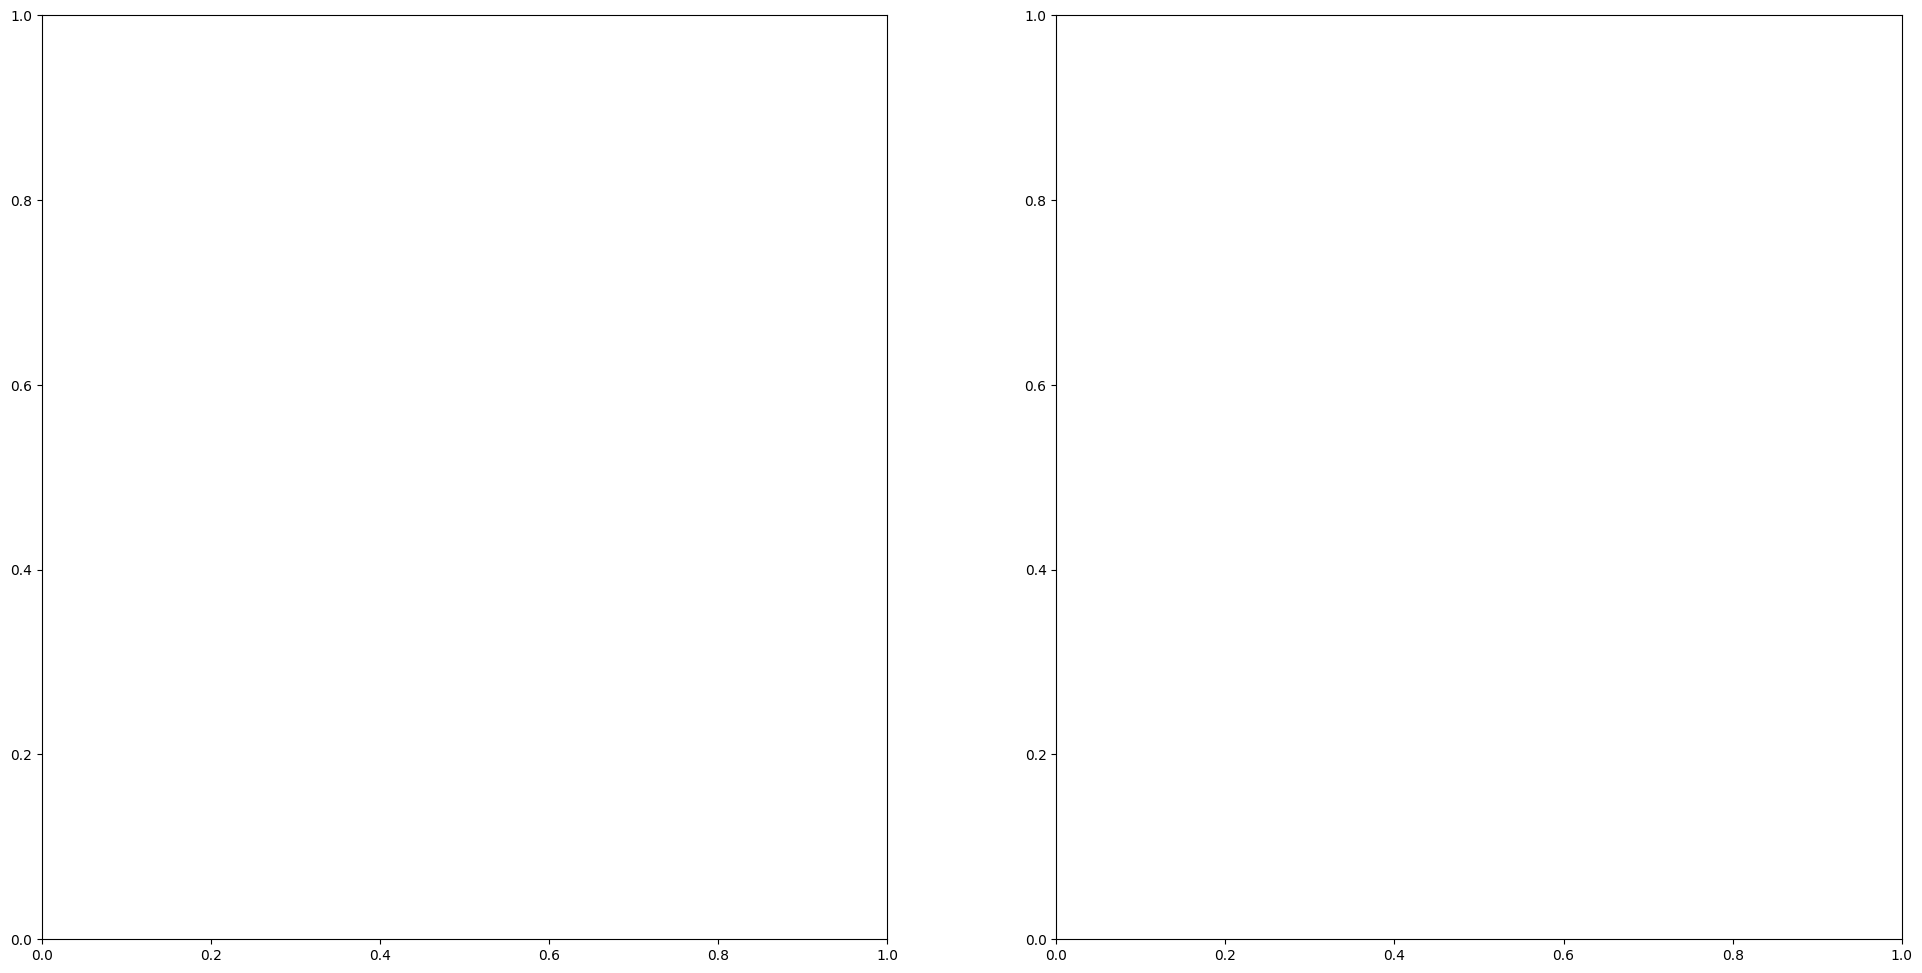

In [21]:
import matplotlib.patches as mpatches

alpha = 0.5

fig, ax = plt.subplots(1, 2, figsize=(24, 12))


ax[0].imshow(image)
ax[0].set_title("Original", fontsize=18)
ax[0].axis("off")


ax[1].imshow(image)                    
ax[1].imshow(label2rgb(preds), alpha=alpha)  
ax[1].set_title(f"Prediction (alpha={alpha})", fontsize=18)
ax[1].axis("off")


handles = []
for i, class_name in enumerate(CLASSES):
    color = np.array(PALETTE[i]) / 255.0
    patch = mpatches.Patch(color=color, label=f"{i}: {class_name}")
    handles.append(patch)

ax[1].legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=16,
)

plt.tight_layout()
plt.show()

# To CSV

In [60]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

image_name = [os.path.basename(f) for f in filename]
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})
df.head(30)
df.to_csv("output.csv", index=False)



# visualize output.csv


In [1]:
import matplotlib.patches as mpatches

def rle_decode(rle_str, shape):

    if isinstance(rle_str, float) and np.isnan(rle_str):

        return np.zeros(shape, dtype=np.uint8)

    s = list(map(int, rle_str.split()))
    starts = np.array(s[0::2]) - 1  
    lengths = np.array(s[1::2])
    ends = starts + lengths

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1

    return img.reshape(shape[0], shape[1]) 


def colorize_label_map(label_map, palette):
    """
    label_map: (H, W), 각 위치에 class index (0,1,2,...)
    palette: [[R, G, B], ...]
    """
    h, w = label_map.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for cls_idx, color in enumerate(palette, start=0):
        color_mask[label_map-1 == cls_idx] = color  
    return color_mask

In [19]:
def visualize_from_csv(
    csv_path,
    image_dir,
    image_name,
    img_size=(2048, 2048),   # RLE 마스크가 인코딩된 사이즈
    alpha=0.5
):
    """
    csv_path: output.csv 경로
    image_dir: 원본 이미지들이 있는 디렉토리
    image_name: 시각화할 이미지 파일 이름 (예: "image1661319116107.png")
    img_size: (H, W) - RLE가 기준하고 있는 segmentation 사이즈
    alpha: overlay 비율
    """

    # CSV 로드
    df = pd.read_csv(csv_path)

    # 해당 image_name의 row만 추출
    df_img = df[df["image_name"] == image_name]
    if len(df_img) == 0:
        print(f"[WARN] {image_name} 에 해당하는 row가 CSV에 없습니다.")
        return

    # image_name -> 원본 이미지 경로
    image_path = os.path.join(image_dir, image_name)
    if not os.path.exists(image_path):
        print(f"[WARN] 원본 이미지가 없습니다: {image_path}")
        return

    # 원본 이미지 읽기 (시각화용)
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # segmentation mask와 동일한 크기로 맞추기
    if (image_rgb.shape[0], image_rgb.shape[1]) != img_size:
        image_vis = cv2.resize(image_rgb, (img_size[1], img_size[0]))
    else:
        image_vis = image_rgb

    # class name -> index 매핑
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(CLASSES)}

    # label map 초기화 (0 = background, 1~ = 각 클래스)
    label_map = np.zeros(img_size, dtype=np.int32)

    # 각 row마다 rle 디코딩해서 label_map에 쌓기
    for _, row in df_img.iterrows():
        cls_name = row["class"]
        rle_str = row["rle"]

        if cls_name not in class_to_idx:
            # CLASSES에 없는 클래스면 스킵
            print(f"[INFO] CLASSES에 없는 클래스: {cls_name} -> 스킵")
            continue

        cls_idx = class_to_idx[cls_name]

        mask = rle_decode(rle_str, img_size)  # (H, W), 0/1

        # 해당 클래스인 위치에 클래스 index 부여
        # 겹치는 영역이 있을 경우, 나중에 오는 클래스로 덮어씀
        label_map[mask == 1] = cls_idx+1

    # color mask 생성
    color_mask = colorize_label_map(label_map, PALETTE)

    # overlay
    overlay = (image_vis * (1 - alpha) + color_mask * alpha).astype(np.uint8)

    # 시각화
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay from CSV", fontsize=18)
    ax[1].axis("off")

    # legend 생성
    handles = []
    for i, class_name in enumerate(CLASSES):
        color = np.array(PALETTE[i]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{i}: {class_name}"))

    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=14,
    )

    plt.tight_layout()
    plt.show()

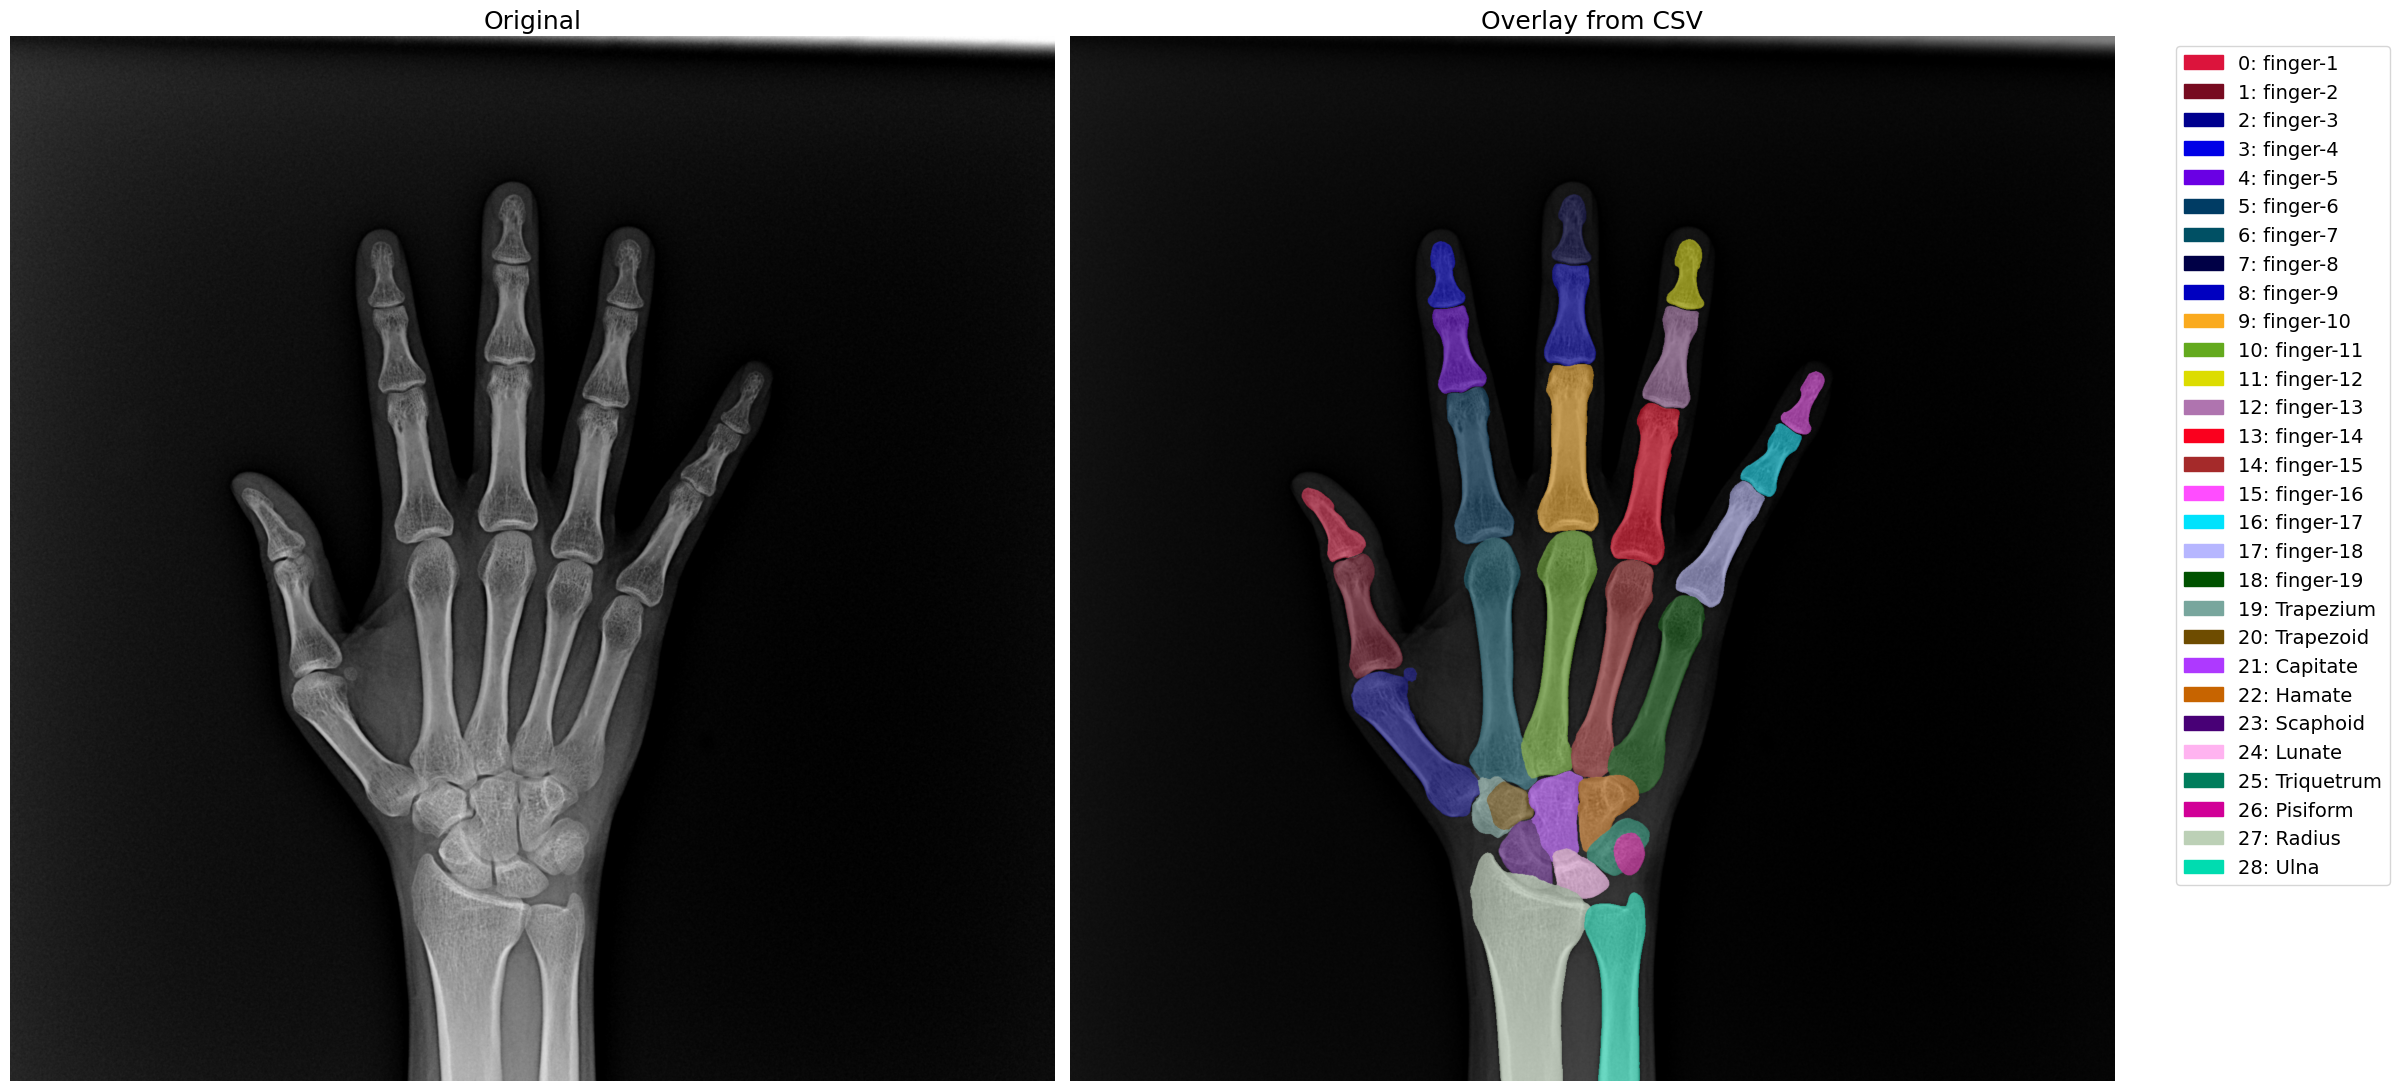

In [23]:
csv_path = "./junsu.csv"
image_dir = "../data/test_merged"  # 실제 이미지 폴더 경로로 수정
image_name = "image1661319116107.png"

visualize_from_csv(
    csv_path=csv_path,
    image_dir=image_dir,
    image_name=image_name,
    img_size=(2048, 2048),   # CSV RLE가 기준한 크기
    alpha=0.5
)

# Test one image


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [ ]:
def test_one_image_visual(model,image_root,thr=0.5,transforms=None, out_size=(2048, 2048)):
    
    image = cv2.imread(image_root)
    model = model.cuda()
    model.eval()
    
    rles = []
    filename_and_class = []

    image = cv2.imread(image_root)
    image = image / 255.
    
    if transforms is not None:
        inputs = {"image": image}
        result = transforms(**inputs)
        image = result["image"]

    image = image.transpose(2, 0, 1)  
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.unsqueeze(0).cuda()
    image_vis = cv2.cvtColor(cv2.imread(image_root), cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        outputs = model(image_tensor)
        outputs = F.interpolate(outputs, size=out_size, mode="bilinear", align_corners=False)
        outputs = torch.sigmoid(outputs)
        preds = (outputs > thr).cpu().numpy()[0]

    color_mask = label2rgb(preds)
    alpha = 0.5
    overlay = (image_vis * (1 - alpha) + color_mask * alpha).astype(np.uint8)
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")
    
    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay (thr={thr})", fontsize=18)
    ax[1].axis("off")
    
    handles = []
    for i, class_name in enumerate(CLASSES):
        color = np.array(PALETTE[i]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{i}: {class_name}"))
    
    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=14,
    )
    
    plt.tight_layout()
    plt.show()




In [ ]:
image_root="../data/train_merged/ID283_image1664155969209.png"
# image_root=os.path.join(image_root,os.listdir(image_root)[0])
# print(image_root)
test_one_image_visual(model,
                      image_root,
                      transforms=test_tf,
                      thr=0.5, out_size=(2048, 2048))

# Visualize each class

In [ ]:
def test_one_image_visual_with_roi(
    model,
    image_root,
    thr=0.5,
    transforms=None,
    out_size=(2048, 2048),
    roi_classes=None,        
    margin=40,
    max_cols=4
):
    """
    - 기존 test_one_image_visual 방식 그대로 사용
    - roi_classes:
        * bbox 계산
        * 클래스별 확률 heatmap 시각화
    """

    assert roi_classes is not None, "roi_classes는 반드시 지정해야 해"

    model = model.cuda()
    model.eval()

    image = cv2.imread(image_root)
    image = image / 255.0

    if transforms is not None:
        inputs = {"image": image}
        result = transforms(**inputs)
        image = result["image"]

    image = image.transpose(2, 0, 1)
    image_tensor = torch.from_numpy(image).float().unsqueeze(0).cuda()

    image_vis = cv2.cvtColor(cv2.imread(image_root), cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        outputs = model(image_tensor)
        outputs = F.interpolate(outputs, size=out_size, mode="bilinear", align_corners=False)
        outputs = torch.sigmoid(outputs)                 
        probs = outputs.cpu().numpy()[0]                 
        preds = (probs > thr).astype(np.uint8) 

    roi_indices = [CLASSES.index(name) for name in roi_classes]
    

    preds_roi = np.zeros_like(preds, dtype=np.uint8)
    preds_roi[roi_indices] = preds[roi_indices]
    
    color_mask = label2rgb(preds_roi)
    
    alpha = 0.5
    overlay = (
        image_vis.astype(np.float32) * (1 - alpha)
        + color_mask.astype(np.float32) * alpha
    ).astype(np.uint8)


    roi_indices = [CLASSES.index(name) for name in roi_classes]


    union = np.zeros_like(preds[0], dtype=bool)
    for idx in roi_indices:
        union |= (preds[idx] == 1)

    ys, xs = np.where(union)
    bbox = None
    if len(xs) > 0 and len(ys) > 0:
        y1, y2 = ys.min(), ys.max()
        x1, x2 = xs.min(), xs.max()

        H, W = union.shape
        y1 = max(0, y1 - margin)
        x1 = max(0, x1 - margin)
        y2 = min(H - 1, y2 + margin)
        x2 = min(W - 1, x2 + margin)

        bbox = (x1, y1, x2, y2)

    # =========================
    # 4) Overlay + bbox 시각화
    # =========================
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay (thr={thr})", fontsize=18)
    ax[1].axis("off")

    if bbox is not None:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle(
            (x1, y1),
            (x2 - x1 + 1),
            (y2 - y1 + 1),
            fill=False,
            linewidth=3
        )
        ax[1].add_patch(rect)

    handles = []
    for name in roi_classes:
        idx = CLASSES.index(name)
        color = np.array(PALETTE[idx]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{idx}: {name}"))

    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=12,
    )

    plt.tight_layout()
    plt.savefig("inference.png")
    plt.show()

    # =========================
    # 5) 클래스별 확률 Heatmap (ROI crop)
    # =========================
    if bbox is None:
        print("[warn] ROI bbox를 찾지 못해 클래스별 시각화를 건너뜀")
        return preds

    x1, y1, x2, y2 = bbox
    preds_crop = preds[:, y1:y2+1, x1:x2+1]

    K = len(roi_indices)
    cols = min(max_cols, K)
    rows = int(np.ceil(K / cols))

    fig2, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for k, cls_idx in enumerate(roi_indices):
        r, c = divmod(k, cols)
        hm = preds_crop[cls_idx]

        im = axes[r, c].imshow(hm, vmin=0.0, vmax=1.0)
        axes[r, c].set_title(
            f"{cls_idx}: {CLASSES[cls_idx]}\nmean={hm.mean():.3f}",
            fontsize=12
        )
        axes[r, c].axis("off")
        plt.colorbar(im, ax=axes[r, c], fraction=0.046, pad=0.04)

    for k in range(K, rows * cols):
        r, c = divmod(k, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    
    plt.show()

    return preds


In [ ]:
roi_classes = ["Trapezium", "Trapezoid", "Capitate", "Hamate",
               "Scaphoid", "Lunate", "Triquetrum", "Pisiform"]

# ROI bbox도 이걸로 잡고, 시각화도 이걸로 하고 싶으면 vis_class_names=None

preds = test_one_image_visual_with_roi(
    model,
    image_root,
    thr=0.5,
    transforms=test_tf,
    out_size=(2048, 2048),
    roi_classes=roi_classes
)

In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def _bbox_from_union_mask(label_chw, class_indices, margin=40):
    union = np.zeros_like(label_chw[0], dtype=bool)
    for idx in class_indices:
        union |= (label_chw[idx] == 1)

    ys, xs = np.where(union)
    if len(xs) == 0 or len(ys) == 0:
        return None

    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    H, W = union.shape
    y1 = max(0, y1 - margin)
    x1 = max(0, x1 - margin)
    y2 = min(H - 1, y2 + margin)
    x2 = min(W - 1, x2 + margin)

    if x2 <= x1 or y2 <= y1:
        return None
    return (x1, y1, x2, y2)


def load_gt_from_image_and_label(image_root, label_root):
    """
    return:
      image_rgb: (H,W,3) uint8
      label_chw: (C,H,W) uint8
    """
    image_bgr = cv2.imread(image_root)
    if image_bgr is None:
        raise FileNotFoundError(image_root)

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    H, W = image_rgb.shape[:2]

    label_hwc = np.zeros((H, W, len(CLASSES)), dtype=np.uint8)

    with open(label_root, "r") as f:
        data = json.load(f)

    for ann in data["annotations"]:
        cname = ann["label"]
        if cname not in CLASS2IND:
            continue

        idx = CLASS2IND[cname]
        pts = np.array(ann["points"], dtype=np.int32)

        m = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(m, [pts], 1)
        label_hwc[..., idx] = m

    return image_rgb, label_hwc.transpose(2, 0, 1)


def visualize_gt_roi_only(
    image_root,
    label_root,
    roi_classes,
    margin=40,
    max_cols=4,
    alpha=0.5
):
    image_vis, label_chw = load_gt_from_image_and_label(image_root, label_root)

    roi_indices = [CLASSES.index(n) for n in roi_classes]

    # roi_classes만 남기기
    label_roi = np.zeros_like(label_chw, dtype=np.uint8)
    label_roi[roi_indices] = label_chw[roi_indices]

    # =========================
    # Overlay + bbox
    # =========================
    color_mask = label2rgb(label_roi)   # 네가 정의한 label2rgb
    overlay = (image_vis.astype(np.float32) * (1 - alpha)
               + color_mask.astype(np.float32) * alpha).astype(np.uint8)

    bbox = _bbox_from_union_mask(label_roi, roi_indices, margin=margin)

    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title("GT Overlay (roi_classes only)", fontsize=18)
    ax[1].axis("off")

    if bbox is not None:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle((x1, y1), x2-x1+1, y2-y1+1,
                              fill=False, linewidth=3)
        ax[1].add_patch(rect)
    else:
        print("[warn] ROI bbox를 찾지 못함")

    handles = []
    for name in roi_classes:
        idx = CLASSES.index(name)
        handles.append(
            mpatches.Patch(color=np.array(PALETTE[idx]) / 255.0,
                            label=f"{idx}: {name}")
        )

    ax[1].legend(handles=handles,
                 bbox_to_anchor=(1.05, 1),
                 loc="upper left",
                 fontsize=12)

    plt.tight_layout()
    plt.show()

    # =========================
    # bbox crop + 클래스별 시각화 (네 블록 그대로)
    # =========================
    if bbox is None:
        print("[warn] ROI bbox를 찾지 못해 클래스별 시각화를 건너뜀")
        return

    x1, y1, x2, y2 = bbox
    label_crop = label_roi[:, y1:y2+1, x1:x2+1]

    K = len(roi_indices)
    cols = min(max_cols, K)
    rows = int(np.ceil(K / cols))

    fig2, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for k, cls_idx in enumerate(roi_indices):
        r, c = divmod(k, cols)
        hm = label_crop[cls_idx].astype(np.float32)

        im = axes[r, c].imshow(hm, vmin=0.0, vmax=1.0)
        axes[r, c].set_title(
            f"{cls_idx}: {CLASSES[cls_idx]}\nmean={hm.mean():.3f}",
            fontsize=12
        )
        axes[r, c].axis("off")
        plt.colorbar(im, ax=axes[r, c], fraction=0.046, pad=0.04)

    for k in range(K, rows * cols):
        r, c = divmod(k, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
visualize_gt_roi_only(
    image_root="../data/train_merged/ID283_image1664155969209.png",
    label_root="../data/train_merged/ID283_image1664155969209.json",
    roi_classes=roi_classes,
    margin=40,
    max_cols=4
)